In [ ]:
import pandas as pd

!pip install stocksymbol -q

from google.colab import drive
drive.mount('drive')


!pip install gnews -q


## ML
! pip install transformers -q

!pip install datasets -q
!pip install optuna -q
! pip install -U accelerate
!pip install evaluate -q

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
import evaluate
from transformers import AutoTokenizer
from datasets import Dataset

Mounted at drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.4/188.4 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━

## Parsing all cycle

### Classical parser


In [ ]:
!pip install dateparser -q

## Source https://github.com/kotartemiy/pygooglenews/blob/master/pygooglenews/__init__.py
import feedparser
from bs4 import BeautifulSoup
import urllib
from dateparser import parse as parse_date
import requests



class GoogleNews:
    def __init__(self, lang = 'en', country = 'USA'):
        self.lang = lang.lower()
        self.country = country.upper()
        self.BASE_URL = 'https://news.google.com/rss'

    def __top_news_parser(self, text):
        """Return subarticles from the main and topic feeds"""
        try:
            bs4_html = BeautifulSoup(text, "html.parser")
            # find all li tags
            lis = bs4_html.find_all('li')
            sub_articles = []
            for li in lis:
                try:
                    sub_articles.append({"url": li.a['href'],
                                         "title": li.a.text,
                                         "publisher": li.font.text})
                except:
                    pass
            return sub_articles
        except:
            return text

    def __ceid(self):
        """Compile correct country-lang parameters for Google News RSS URL"""
        return '?ceid={}:{}&hl={}&gl={}'.format(self.country,self.lang,self.lang,self.country)

    def __add_sub_articles(self, entries):
        for i, val in enumerate(entries):
            if 'summary' in entries[i].keys():
                entries[i]['sub_articles'] = self.__top_news_parser(entries[i]['summary'])
            else:
                entries[i]['sub_articles'] = None
        return entries

    def __scaping_bee_request(self, api_key, url):
        response = requests.get(
            url="https://app.scrapingbee.com/api/v1/",
            params={
                "api_key": api_key,
                "url": url,
                "render_js": "false"
            }
        )
        if response.status_code == 200:
            return response
        if response.status_code != 200:
            raise Exception("ScrapingBee status_code: "  + str(response.status_code) + " " + response.text)

    def __parse_feed(self, feed_url, proxies=None, scraping_bee = None):

        if scraping_bee and proxies:
            raise Exception("Pick either ScrapingBee or proxies. Not both!")

        if proxies:
            r = requests.get(feed_url, proxies = proxies)
        else:
            r = requests.get(feed_url)

        if scraping_bee:
            r = self.__scaping_bee_request(url = feed_url, api_key = scraping_bee)
        else:
            r = requests.get(feed_url)


        if 'https://news.google.com/rss/unsupported' in r.url:
            raise Exception('This feed is not available')

        d = feedparser.parse(r.text)

        if not scraping_bee and not proxies and len(d['entries']) == 0:
            d = feedparser.parse(feed_url)

        return dict((k, d[k]) for k in ('feed', 'entries'))

    def __search_helper(self, query):
        return urllib.parse.quote_plus(query)

    def __from_to_helper(self, validate=None):
        try:
            validate = parse_date(validate).strftime('%Y-%m-%d')
            return str(validate)
        except:
            raise Exception('Could not parse your date')



    def top_news(self, proxies=None, scraping_bee = None):
        """Return a list of all articles from the main page of Google News
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + self.__ceid(), proxies=proxies, scraping_bee=scraping_bee)
        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def topic_headlines(self, topic: str, proxies=None, scraping_bee=None):
        """Return a list of all articles from the topic page of Google News
        given a country and a language"""
        #topic = topic.upper()
        if topic.upper() in ['WORLD', 'NATION', 'BUSINESS', 'TECHNOLOGY', 'ENTERTAINMENT', 'SCIENCE', 'SPORTS', 'HEALTH']:
            d = self.__parse_feed(self.BASE_URL + '/headlines/section/topic/{}'.format(topic.upper()) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        else:
            d = self.__parse_feed(self.BASE_URL + '/topics/{}'.format(topic) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        if len(d['entries']) > 0:
            return d
        else:
            raise Exception('unsupported topic')

    def geo_headlines(self, geo: str, proxies=None, scraping_bee=None):
        """Return a list of all articles about a specific geolocation
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + '/headlines/section/geo/{}'.format(geo) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def search(self, query: str, helper = True, when = None, from_ = None, to_ = None, proxies=None, scraping_bee=None):
        """
        Return a list of all articles given a full-text search parameter,
        a country and a language
        :param bool helper: When True helps with URL quoting
        :param str when: Sets a time range for the artiles that can be found
        """

        if when:
            query += ' when:' + when

        if from_ and not when:
            from_ = self.__from_to_helper(validate=from_)
            query += ' after:' + from_

        if to_ and not when:
            to_ = self.__from_to_helper(validate=to_)
            query += ' before:' + to_

        if helper == True:
            query = self.__search_helper(query)

        search_ceid = self.__ceid()
        search_ceid = search_ceid.replace('?', '&')

        d = self.__parse_feed(self.BASE_URL + '/search?q={}'.format(query) + search_ceid, proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

In [ ]:
import datetime
gn = GoogleNews(lang = 'en')

## function por parsing several days
##Created to break limit of 100 publications per request by Googgle
##Credits to https://stackoverflow.com/questions/72571345/googlenews-date-range
def get_news(search):
   stories = []
   start_date = datetime.date(2020,1,1)
   end_date = datetime.date(2023,9,1)
   print(start_date, end_date)
   delta = datetime.timedelta(days=5)  ## timestamp object to datetime
   date_list = pd.date_range(start_date, end_date).tolist()
   ##print(date_list)

   for date in date_list[:-1]:
    x = (date).strftime('%Y-%m-%d')
    x1 = (date+delta).strftime('%Y-%m-%d')
    ##print(x1)
    result = gn.search(search, from_=(date).strftime('%Y-%m-%d'), to_=(date+delta).strftime('%Y-%m-%d'))
    newsitem = result['entries']

    for item in newsitem:
        story = {
            'title':item.title,
            'link':item.link,
            'published':item.published
        }
        stories.append(story)
   print("Finished parsing of:", search,"for dates:", start_date, '-', end_date )
   return stories

### Parsing

In [ ]:
from stocksymbol import StockSymbol

## Getting stock tickers from S&P 500 index
api_key = '4231f700-99e1-42ec-b8a8-03b27d3695f3'
ss = StockSymbol(api_key)
symbol_list_us = ss.get_symbol_list(index="SPX")
Tickers = pd.DataFrame(symbol_list_us)

Tickers.to_csv('symbol_list_selected.csv')
!cp symbol_list_selected.csv "/content/drive/MyDrive/Colab Notebooks/Data_paper"

In [ ]:
## Read list of stock tickers

symbol_list = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/symbol_list_selected.csv')

In [ ]:
symbol_list

Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0               0             0             0             0           0   
1               1             1             1             1           1   
2               2             2             2             2           2   
3               3             3             3             3           3   
4               4             4             4             4           4   
..            ...           ...           ...           ...         ...   
499           499           499           499           499         499   
500           500           500           500           500         500   
501           501           501           501           501         501   
502           502           502           502           502         502   
503           503           503           503           503         503   

    symbol             shortName                    longName exchange  \
0     AAPL                 apple                  Apple Inc.   NASDAQ   
1     MSFT             microsoft       Microsoft Corporation   NASDAQ   
2    GOOGL              alphabet               Alphabet Inc.   NASDAQ   
3     GOOG              alphabet               Alphabet Inc.   NASDAQ   
4     AMZN                amazon            Amazon.com, Inc.   NASDAQ   
..     ...                   ...                         ...      ...   
499   PENN  penn-national-gaming  Penn National Gaming, Inc.   NASDAQ   
500   NLSN     nielsen-hldgs-plc                Nielsen N.V.     NYSE   
501    PVH                   pvh                   PVH Corp.     NYSE   
502    ALK            alaska-air      Alaska Air Group, Inc.     NYSE   
503    GPS                   gap             Gap, Inc. (The)     NYSE   

        market quoteType  Parsed  
0    us_market    EQUITY       1  
1    us_market    EQUITY       1  
2    us_market    EQUITY       1  
3    us_market    EQUITY       1  
4    us_market    EQUITY       1  
..         ...       ...     ...  
499  us_market    EQUITY       0  
500  us_market    EQUITY       0  
501  us_market    EQUITY       0  
502  us_market    EQUITY       0  
503  us_market    EQUITY       0  

[504 rows x 12 columns]

In [ ]:
##Given that parsing was done in steps we manually adjust already parsed stock tickers
symbol_list.loc[:40, 'Parsed'] =1
symbol_list.to_csv('symbol_list_selected.csv')
!cp symbol_list_selected.csv "/content/drive/MyDrive/Colab Notebooks/Data_paper"

In [ ]:
## init dataset to write to

News_dataset = pd.DataFrame(list())
News_dataset.to_csv('News_dataset.csv')
##!cp News_dataset.csv "/content/drive/MyDrive/Colab Notebooks/Data_paper"

In [ ]:
News_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/News_dataset.csv')

In [ ]:
News_dataset

Unnamed: 0
0      Apple and Imagination Technologies Bury the Hat... https://news.google.com/rss/articles/CBMiQ2h0dH... Thu, 02 Jan 2020 08:00:00 GMT NASDAQ       AAPL
1      Apple's stock could be worth $100 more in 2020,... https://news.google.com/rss/articles/CBMiZmh0dH... Wed, 01 Jan 2020 08:00:00 GMT NASDAQ       AAPL
2      Apple restores Imagination GPU chip agreement a... https://news.google.com/rss/articles/CBMiO2h0dH... Wed, 01 Jan 2020 08:00:00 GMT NASDAQ       AAPL
3      Demolition underway at Apple Valley, Summitview... https://news.google.com/rss/articles/CBMirwFodH... Wed, 01 Jan 2020 08:00:00 GMT NASDAQ       AAPL
4      Want Fresh Fruit in Winter? Try Crab Apple Tree... https://news.google.com/rss/articles/CBMiS2h0dH... Thu, 29 Jun 2023 16:30:05 GMT NASDAQ       AAPL
...                                                                                                                                                      ...
118916 Bret Stephens: How Do We Manage China's Decline... https://news.google.com/rss/articles/CBMicGh0dH... Fri, 01 Sep 2023 07:00:00 GMT NASDAQ       QCOM
118917 Unveiling The Connected Britain Awards 2023 Sho... https://news.google.com/rss/articles/CBMiUWh0dH... Mon, 04 Sep 2023 07:00:00 GMT NASDAQ       QCOM
118918 Closing the Book: Microsoft WordPad 3 Decade St... https://news.google.com/rss/articles/CBMiP2h0dH... Sat, 02 Sep 2023 07:00:00 GMT NASDAQ       QCOM
118919 Monthly Merger Review Snapshot - Law360            https://news.google.com/rss/articles/CBMiRmh0dH... Fri, 01 Sep 2023 07:00:00 GMT NASDAQ       QCOM
118920 Modulární Fairphone 5 má nejdelší Android podpo... https://news.google.com/rss/articles/CBMieWh0dH... Thu, 31 Aug 2023 07:00:00 GMT NASDAQ       QCOM

[4982278 rows x 1 columns]

In [ ]:
del News_dataset

In [ ]:
Symbol_list = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/symbol_list_selected.csv')

##We parse only ~50 top tickers
Symbol_list =Symbol_list.head(51)

##parsing function to collect news from Google News
for index, row in Symbol_list.iterrows():
  if row['Parsed'] == 0:
      ## Run function to get publications from the short name of company
      List_of_news = get_news(row['shortName'])

      Data_frac = pd.DataFrame(List_of_news)

      ## Append additional columns
      Data_frac['exchange'] = row['exchange']
      Data_frac['symbol'] = row['symbol']
      Data_frac.to_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/News_dataset.csv', mode='a', header=False, escapechar='\\')


      ## Run function to get publications from the ticker of company
      List_of_news2 = get_news(row['symbol'])
      Data_frac = pd.DataFrame(List_of_news2)

      ## Append additional columns
      Data_frac['exchange'] = row['exchange']
      Data_frac['symbol'] = row['symbol']
      Data_frac.to_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/News_dataset.csv', mode='a', header=False, escapechar='\\')


  else:
    print(row['shortName'], 'is already parced')

apple is already parced
microsoft is already parced
alphabet is already parced
alphabet is already parced
amazon is already parced
tesla is already parced
meta-platforms is already parced
berkshire-hathaway is already parced
nvidia is already parced
jpmorgan-chase is already parced
visa is already parced
unitedhealth is already parced
johnson-and-johnson is already parced
walmart is already parced
home-depot is already parced
bank-of-america is already parced
procter-and-gamble is already parced
mastercard is already parced
pfizer is already parced
exxon is already parced
walt-disney is already parced
coca-cola is already parced
cisco is already parced
chevron is already parced
broadcom is already parced
adobe is already parced
pepsico is already parced
thermo-fisher-scientific is already parced
eli-lilly is already parced
abbvie is already parced
accenture is already parced
comcast is already parced
nike is already parced
oracle is already parced
netflix is already parced
wells-fargo 

### Data Overview

In [ ]:
News_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/News_dataset.csv', sep=",")

In [ ]:
News_dataset.row.str.extract('(?P<Title>.*?) - ((?P<Source>[A-Z ]*$)|(?P<county>.*?), (?P<state_code>[A-Z]{2}$))')

In [ ]:
test1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/News_datasetHeader.csv', header=0, sep=",")


In [ ]:
import plotly.express as px
to_plot = test1.groupby(test1[' Tiker'])

figa = px.bar(to_plot['Index'].count(), title='Number of publications from 01.2020 to 09.2023')
figa.update_layout(showlegend=False)
figa.update_xaxes(title='Ticker', visible=True, showticklabels=True)

In [ ]:
import yfinance as yf



/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.17) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [ ]:
test1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/News_datasetHeader.csv', header=0, sep=",")

In [ ]:
test1

Index  \
0      Apple and Imagination Technologies Bury the Ha...   
1      Apple's stock could be worth $100 more in 2020...   
2      Apple restores Imagination GPU chip agreement ...   
3      Demolition underway at Apple Valley, Summitvie...   
4      Want Fresh Fruit in Winter? Try Crab Apple Tre...   
...                                                  ...   
85919  After a Texas school shooting, conservatives b...   
85920  Aussies make major announcement on Pat Cummins...   
85921  ERCOT Asked and Texas Listened, and the Power ...   
85922  Television: ‘Yellowstone’ should have received...   
85923  Tent city Vancouver: Locals concerned for safe...   

                                                   Title  \
0      https://news.google.com/rss/articles/CBMiQ2h0d...   
1      https://news.google.com/rss/articles/CBMiZmh0d...   
2      https://news.google.com/rss/articles/CBMiO2h0d...   
3      https://news.google.com/rss/articles/CBMirwFod...   
4      https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                  ...   
85919  https://news.google.com/rss/articles/CBMiamh0d...   
85920  https://news.google.com/rss/articles/CBMiYmh0d...   
85921  https://news.google.com/rss/articles/CBMiZ2h0d...   
85922  https://news.google.com/rss/articles/CBMicGh0d...   
85923  https://news.google.com/rss/articles/CBMiXmh0d...   

                                Link Date; Exchange  Tiker  
0      Thu, 02 Jan 2020 08:00:00 GMT         NASDAQ   AAPL  
1      Wed, 01 Jan 2020 08:00:00 GMT         NASDAQ   AAPL  
2      Wed, 01 Jan 2020 08:00:00 GMT         NASDAQ   AAPL  
3      Wed, 01 Jan 2020 08:00:00 GMT         NASDAQ   AAPL  
4      Thu, 29 Jun 2023 16:30:05 GMT         NASDAQ   AAPL  
...                              ...            ...    ...  
85919  Mon, 18 Jul 2022 07:00:00 GMT           NYSE    ABT  
85920  Sun, 17 Jul 2022 07:00:00 GMT           NYSE    ABT  
85921  Fri, 15 Jul 2022 07:00:00 GMT           NYSE    ABT  
85922  Sun, 17 Jul 2022 07:00:00 GMT           NYSE    ABT  
85923  Fri, 15 Jul 2022 07:00:00 GMT           NYSE    ABT  

[3947955 rows x 5 columns]

In [ ]:
##List of companies in dataset

Companies = test1[' Tiker'].unique()
Companies = Companies.tolist()

In [ ]:
##Get financial data
from stocksymbol import StockSymbol
Stock_data = pd.DataFrame()

for comp in Companies:
  ticker = yf.Ticker(comp)
  hist = ticker.history(period="4y")
  hist['symbol'] = comp
  Stock_data = Stock_data.append(hist)

In [ ]:
Stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'symbol', 'Adj Close'],
      dtype='object')

In [ ]:
Stock_data.to_csv('Stock_data.csv')
!cp Stock_data.csv "/content/drive/MyDrive/Colab Notebooks/Data_paper"

In [ ]:
Stock_data

Open        High         Low       Close  \
Date                                                                        
2020-09-30 00:00:00-04:00  111.769705  115.178098  111.602725  113.753838   
2020-10-01 00:00:00-04:00  115.551368  115.629950  113.773506  114.716461   
2020-10-02 00:00:00-04:00  110.885700  113.321673  110.227598  111.013390   
2020-10-05 00:00:00-04:00  111.887590  114.578941  111.533981  114.431602   
2020-10-06 00:00:00-04:00  113.645814  114.058363  110.257070  111.150917   
...                               ...         ...         ...         ...   
2023-09-25 00:00:00-04:00   97.970001   98.209999   97.160004   97.470001   
2023-09-26 00:00:00-04:00   97.050003   97.529999   96.029999   96.230003   
2023-09-27 00:00:00-04:00   96.589996   96.940002   94.760002   95.529999   
2023-09-28 00:00:00-04:00   96.279999   98.279999   96.120003   98.120003   
2023-09-29 00:00:00-04:00   98.449997   98.510002   96.480003   96.849998   

                                Volume  Dividends  Stock Splits symbol  \
Date                                                                     
2020-09-30 00:00:00-04:00  142675200.0        0.0           0.0   AAPL   
2020-10-01 00:00:00-04:00  116120400.0        0.0           0.0   AAPL   
2020-10-02 00:00:00-04:00  144712000.0        0.0           0.0   AAPL   
2020-10-05 00:00:00-04:00  106243800.0        0.0           0.0   AAPL   
2020-10-06 00:00:00-04:00  161498200.0        0.0           0.0   AAPL   
...                                ...        ...           ...    ...   
2023-09-25 00:00:00-04:00    4096300.0        0.0           0.0    ABT   
2023-09-26 00:00:00-04:00    3967700.0        0.0           0.0    ABT   
2023-09-27 00:00:00-04:00    5391000.0        0.0           0.0    ABT   
2023-09-28 00:00:00-04:00    6092800.0        0.0           0.0    ABT   
2023-09-29 00:00:00-04:00    5150500.0        0.0           0.0    ABT   

                           Adj Close  
Date                                  
2020-09-30 00:00:00-04:00        NaN  
2020-10-01 00:00:00-04:00        NaN  
2020-10-02 00:00:00-04:00        NaN  
2020-10-05 00:00:00-04:00        NaN  
2020-10-06 00:00:00-04:00        NaN  
...                              ...  
2023-09-25 00:00:00-04:00        NaN  
2023-09-26 00:00:00-04:00        NaN  
2023-09-27 00:00:00-04:00        NaN  
2023-09-28 00:00:00-04:00        NaN  
2023-09-29 00:00:00-04:00        NaN  

[27180 rows x 9 columns]

In [ ]:
import plotly.express as px
fig = px.line(Stock_data,color='symbol', y='Close')
fig.update_yaxes(title='Adj. Close', visible=True, showticklabels=True)

##Project

In [ ]:
##import news DataFrame
names = ["index","Title", 'link', 'Date', 'Ex.', 'Company']
News_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/News_dataset.csv', header=0, names = names, sep=",")


In [ ]:
import yfinance as yf

apple = yf.Ticker('AAPL')
test_1 = apple.history(period="5y")
##test_1.set_index(pd.to_datetime(pd.to_datetime(test_1.reset_index()['Date']).dt.date), inplace=True)

test_1 =test_1.reset_index()
test_1.loc[:,'Date'] = pd.to_datetime(test_1.loc[:,'Date'])
        ##print(hist['Date'])
test_1['Date'] = pd.to_datetime(test_1['Date'].dt.date)


test = pd.DataFrame(apple.financials)
test = test.T
test = test['Diluted Average Shares'].sort_index()
test = pd.DataFrame(test)


tol = pd.Timedelta('7 day')
test_2 = pd.merge_asof(test_1, test, right_index=True,left_on='Date', direction='nearest',tolerance=tol)


test_2['Diluted Average Shares'].fillna(method='ffill', inplace=True)
test_2['Diluted Average Shares'].fillna(method='bfill', inplace=True)


In [ ]:
test

Diluted Average Shares
2020-09-30          17528214000.0
2021-09-30          16864919000.0
2022-09-30          16325819000.0
2023-09-30          15812547000.0

In [ ]:
test_1

Open        High         Low       Close  \
Date                                                                        
2019-05-13 00:00:00-04:00   45.289593   45.716646   44.117000   44.809456   
2019-05-14 00:00:00-04:00   44.975936   45.769726   44.734661   45.518803   
2019-05-15 00:00:00-04:00   44.942167   46.264349   44.881848   46.064091   
2019-05-16 00:00:00-04:00   45.820407   46.438069   45.562242   45.861423   
2019-05-17 00:00:00-04:00   45.101406   46.059265   45.060390   45.600845   
...                               ...         ...         ...         ...   
2024-05-07 00:00:00-04:00  183.201504  184.649537  181.074400  182.152924   
2024-05-08 00:00:00-04:00  182.602329  182.822032  181.204216  182.492477   
2024-05-09 00:00:00-04:00  182.312720  184.409882  181.863333  184.320007   
2024-05-10 00:00:00-04:00  184.899994  185.089996  182.130005  183.050003   
2024-05-13 00:00:00-04:00  185.434998  185.768799  184.619995  185.764999   

                              Volume  Dividends  Stock Splits  \
Date                                                            
2019-05-13 00:00:00-04:00  229722400       0.00           0.0   
2019-05-14 00:00:00-04:00  146118800       0.00           0.0   
2019-05-15 00:00:00-04:00  106178800       0.00           0.0   
2019-05-16 00:00:00-04:00  132125600       0.00           0.0   
2019-05-17 00:00:00-04:00  131516400       0.00           0.0   
...                              ...        ...           ...   
2024-05-07 00:00:00-04:00   77305800       0.00           0.0   
2024-05-08 00:00:00-04:00   45057100       0.00           0.0   
2024-05-09 00:00:00-04:00   48983000       0.00           0.0   
2024-05-10 00:00:00-04:00   50727400       0.25           0.0   
2024-05-13 00:00:00-04:00   12899531       0.00           0.0   

                           Diluted Average Shares  
Date                                               
2019-05-13 00:00:00-04:00                       0  
2019-05-14 00:00:00-04:00                       0  
2019-05-15 00:00:00-04:00                       0  
2019-05-16 00:00:00-04:00                       0  
2019-05-17 00:00:00-04:00                       0  
...                                           ...  
2024-05-07 00:00:00-04:00                       0  
2024-05-08 00:00:00-04:00                       0  
2024-05-09 00:00:00-04:00                       0  
2024-05-10 00:00:00-04:00                       0  
2024-05-13 00:00:00-04:00                       0  

[1260 rows x 8 columns]

In [ ]:
test_1.set_index(pd.to_datetime(pd.to_datetime(test_1.reset_index()['Date']).dt.date), inplace=True)

In [ ]:
test_1.index

DatetimeIndex(['2019-05-13', '2019-05-14', '2019-05-15', '2019-05-16',
               '2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24',
               ...
               '2024-04-30', '2024-05-01', '2024-05-02', '2024-05-03',
               '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09',
               '2024-05-10', '2024-05-13'],
              dtype='datetime64[ns]', name='Date', length=1260, freq=None)

In [ ]:
tol = pd.Timedelta('3 day')
test_2 = pd.merge_asof(test_1, test, right_index=True,left_index=True, direction='nearest',tolerance=tol)

In [ ]:
test_2

Date        Open        High         Low       Close     Volume  \
0    2019-05-13   45.289605   45.716657   44.117011   44.809467  229722400   
1    2019-05-14   44.975936   45.769726   44.734661   45.518803  146118800   
2    2019-05-15   44.942159   46.264341   44.881841   46.064083  106178800   
3    2019-05-16   45.820403   46.438065   45.562238   45.861420  132125600   
4    2019-05-17   45.101406   46.059265   45.060390   45.600845  131516400   
...         ...         ...         ...         ...         ...        ...   
1255 2024-05-07  183.201504  184.649537  181.074400  182.152924   77305800   
1256 2024-05-08  182.602329  182.822032  181.204216  182.492477   45057100   
1257 2024-05-09  182.312720  184.409882  181.863333  184.320007   48983000   
1258 2024-05-10  184.899994  185.089996  182.130005  183.050003   50727400   
1259 2024-05-13  185.434998  186.429993  184.619995  186.330002   18951566   

      Dividends  Stock Splits  Diluted Average Shares  
0          0.00           0.0            1.752821e+10  
1          0.00           0.0            1.752821e+10  
2          0.00           0.0            1.752821e+10  
3          0.00           0.0            1.752821e+10  
4          0.00           0.0            1.752821e+10  
...         ...           ...                     ...  
1255       0.00           0.0            1.581255e+10  
1256       0.00           0.0            1.581255e+10  
1257       0.00           0.0            1.581255e+10  
1258       0.25           0.0            1.581255e+10  
1259       0.00           0.0            1.581255e+10  

[1260 rows x 9 columns]

In [ ]:
test_2 = pd.merge(test_1, test, how='left')

In [ ]:
test_2['Diluted Average Shares_y'].unique()

array([nan, 17528214000.0, 16864919000.0, 16325819000.0, 15812547000.0],
      dtype=object)

In [ ]:
test_2['Diluted Average Shares_y'].fillna(method='ffill', inplace=True)

In [ ]:
test_2

Open        High         Low       Close     Volume  \
Date                                                                    
2019-05-13   45.289593   45.716646   44.117000   44.809456  229722400   
2019-05-14   44.975936   45.769726   44.734661   45.518803  146118800   
2019-05-15   44.942167   46.264349   44.881848   46.064091  106178800   
2019-05-16   45.820407   46.438069   45.562242   45.861423  132125600   
2019-05-17   45.101406   46.059265   45.060390   45.600845  131516400   
...                ...         ...         ...         ...        ...   
2024-05-07  183.201504  184.649537  181.074400  182.152924   77305800   
2024-05-08  182.602329  182.822032  181.204216  182.492477   45057100   
2024-05-09  182.312720  184.409882  181.863333  184.320007   48983000   
2024-05-10  184.899994  185.089996  182.130005  183.050003   50727400   
2024-05-13  185.434998  185.768799  184.619995  185.764999   12899531   

            Dividends  Stock Splits  Diluted Average Shares_x  \
Date                                                            
2019-05-13       0.00           0.0                         0   
2019-05-14       0.00           0.0                         0   
2019-05-15       0.00           0.0                         0   
2019-05-16       0.00           0.0                         0   
2019-05-17       0.00           0.0                         0   
...               ...           ...                       ...   
2024-05-07       0.00           0.0                         0   
2024-05-08       0.00           0.0                         0   
2024-05-09       0.00           0.0                         0   
2024-05-10       0.25           0.0                         0   
2024-05-13       0.00           0.0                         0   

            Diluted Average Shares_y  
Date                                  
2019-05-13                       NaN  
2019-05-14                       NaN  
2019-05-15                       NaN  
2019-05-16                       NaN  
2019-05-17                       NaN  
...                              ...  
2024-05-07              1.581255e+10  
2024-05-08              1.581255e+10  
2024-05-09              1.581255e+10  
2024-05-10              1.581255e+10  
2024-05-13              1.581255e+10  

[1260 rows x 9 columns]

In [ ]:
News_dataset

index                                              Title  \
0            0  Apple and Imagination Technologies Bury the Ha...   
1            1  Apple's stock could be worth $100 more in 2020...   
2            2  Apple restores Imagination GPU chip agreement ...   
3            3  Demolition underway at Apple Valley, Summitvie...   
4            4  Want Fresh Fruit in Winter? Try Crab Apple Tre...   
...        ...                                                ...   
6899116  45517  【卓球男子】2024年パリ五輪 日本代表選考ポイント（2023年8月31日現在）｜テレビ東京...   
6899117  45518  人気ベーカリー｜2023年9月 2日｜出没！アド街ック天国：テレビ東京 - テレビ東京・ＢＳ...   
6899118  45519  五線紙｜2023年9月 2日｜出没！アド街ック天国：テレビ東京 - テレビ東京・ＢＳテレ東 ...   
6899119  45520       “敬護”の精神で全面サポート～頼れるスーパー介護施設！：読んで ... - テレ東プラス   
6899120  45521  【公式】激動の20代をプレイバック！東京五輪選考レースの裏側では何が...？2週連続「かすみ...   

                                                      link  \
0        https://news.google.com/rss/articles/CBMiQ2h0d...   
1        https://news.google.com/rss/articles/CBMiZmh0d...   
2        https://news.google.com/rss/articles/CBMiO2h0d...   
3        https://news.google.com/rss/articles/CBMirwFod...   
4        https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                    ...   
6899116  https://news.google.com/rss/articles/CBMiP2h0d...   
6899117  https://news.google.com/rss/articles/CBMiQ2h0d...   
6899118  https://news.google.com/rss/articles/CBMiQ2h0d...   
6899119  https://news.google.com/rss/articles/CBMiQGh0d...   
6899120  https://news.google.com/rss/articles/CBMiP2h0d...   

                                  Date     Ex. Company  
0        Thu, 02 Jan 2020 08:00:00 GMT  NASDAQ    AAPL  
1        Wed, 01 Jan 2020 08:00:00 GMT  NASDAQ    AAPL  
2        Wed, 01 Jan 2020 08:00:00 GMT  NASDAQ    AAPL  
3        Wed, 01 Jan 2020 08:00:00 GMT  NASDAQ    AAPL  
4        Thu, 29 Jun 2023 16:30:05 GMT  NASDAQ    AAPL  
...                                ...     ...     ...  
6899116  Thu, 31 Aug 2023 07:00:00 GMT  NASDAQ     TXN  
6899117  Sat, 02 Sep 2023 07:00:00 GMT  NASDAQ     TXN  
6899118  Sat, 02 Sep 2023 07:00:00 GMT  NASDAQ     TXN  
6899119  Thu, 31 Aug 2023 07:00:00 GMT  NASDAQ     TXN  
6899120  Sat, 02 Sep 2023 07:00:00 GMT  NASDAQ     TXN  

[6899121 rows x 6 columns]

In [ ]:
import numpy as np
import spacy
from sklearn.cluster import DBSCAN
import yfinance as yf
from tqdm import tqdm
tqdm.pandas()

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import BDay

import yfinance as yf

import tensorflow as tf
import torch



from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import optuna
from optuna.samplers import TPESampler


random_state=42

class ML_build:

  ## init class
  def __init__(self):
    return

  ## assign news dataframe into class
  def news_df(self, df):


    self.df_news = df.copy()
    self.df_news.loc[:,'Date'] = pd.to_datetime(self.df_news.loc[:,'Date'])
    return

  ## data cleaning from duplicates, other languages
  def data_preparation(self, title_column = 'Title',
                       drop_dup=True, sources_sep = True, Non_eng = 'drop'):
    ## Drop duplicates. Requiered step Given that we parsed for each company twice
    if drop_dup ==True:
      self.df_news = self.df_news.drop_duplicates()
    else:
      print("duplicates were not excluded")

    ## Drop Non-english news
    if Non_eng == 'drop':
      def isEnglish(s):
        return s.isascii()

      self.df_news = self.df_news[self.df_news[title_column].apply(isEnglish) == True]
    else:
      print("other languages were not excluded")


    if 'Source' not in self.df_news:
      self.df_news[['Title', 'Source']] = self.df_news['Title'].str.rsplit(' - ', n=1, expand=True)
    else:
      pass
    return


  ## finding important new by clusterisation based on rare words
  def first_story_flag(self, Light_model = False):
    if Light_model == False:
      ##advanced vectorisation. Does not support large df.
      sent_vecs = {}
      docs = []
      spacy.cli.download('en_core_web_lg')
      nlp = spacy.load('en_core_web_lg')
      for title in tqdm(self.df_news.Title.head(1000)):
        doc = nlp(title)
        docs.append(doc)
        sent_vecs.update({title: doc.vector})
        sentences = list(sent_vecs.keys())
        vectors = list(sent_vecs.values())
      x = np.array(vectors)
      ## search for optimal eps
      n_classes = {}
      for i in tqdm(np.arange(0.001, 1, 0.002)):
        dbscan = DBSCAN(eps=i, min_samples=2, metric='cosine').fit(x)
        n_classes.update({i: len(pd.Series (dbscan. labels_) .value_counts ())})
      ##print(n_classes)
      res_list = []
      for item in dbscan.labels_:
          if item not in res_list:
              res_list.append(item)
      ##print(res_list)


      ## Get most sensitive classification
      optimal_eps   = max(n_classes, key=n_classes.get)



      self.df_news["DBSCAN"] = -1
      self.df_news["First_story"] = 0
      self.df_news.set_index('Title',inplace=True)


      for i in self.df_news['Company'].unique():

        docs = []
        sent_vecs = {}
        titles = []


        ##for title in tqdm(self.df_news.loc[(self.df_news['Company'] == i), 'Title']):
        for title in tqdm(self.df_news.loc[(self.df_news['Company'] == i)].index.tolist()):
          titles.append(title)
          doc = nlp(title)
          docs.append(doc)
          sent_vecs.update({title: doc.vector})
          sentences = list(sent_vecs.keys())
          vectors = list(sent_vecs.values())
        x = np.array(vectors)

        edges = zip(*nx.to_edgelist(G))
        G1 = igraph.Graph(len(G), zip(*edges[:2]))
        D = 1 - np.array(G1.similarity_jaccard(loops=False))

        dbscan = DBSCAN(D, metric='precomputed', eps=optimal_eps, min_samples=2)

        ##dbscan = DBSCAN(eps=optimal_eps, min_samples=2, metric='cosine').fit(x)

        ##print(dbscan.labels_.shape, titles.shape)

        titles_dbscan = self.df_news.loc[(self.df_news['Company'] == i)].index.tolist()
        titles_dbscan = list(sent_vecs.keys())
        '''result_dbscan = pd.DataFrame({'DBSCAN': dbscan.labels_,
                                      'sent': titles_dbscan})
        if i == self.df_news['Company'].unique()[0]:
          self.df_news = self.df_news.merge(result_dbscan,
                                          left_on='Title', right_on='sent')
        else:
          self.df_news.loc[(self.df_news['Company'] == i), ]'''
        result_dbscan = pd.DataFrame({'DBSCAN': dbscan.labels_,
                                      'Title': titles_dbscan})
        result_dbscan.set_index('Title',inplace=True)

        Story_list = []
        def first_occurance(value):
          if value in Story_list:
            return 0
          else:
            Story_list.append(value)
            return 1

        result_dbscan['First_story'] = result_dbscan['DBSCAN'].apply(first_occurance)
        self.df_news.update(result_dbscan)
      return

      ##self.df_news = self.df_news.rename(columns={"A": "a", "B": "c"})


    else:
      ## run TF-ID model Based on http://ai.intelligentonlinetools.com/ml/text-clustering-word-embedding-machine-learning/
      from sklearn.feature_extraction.text import TfidfVectorizer

      vec = TfidfVectorizer( stop_words='english')##,
                      ##ngram_range=(1, 2))
      x = vec.fit_transform(self.df_news.head(1000).Title)
      ## search for optimal eps
      n_classes = {}
      for i in tqdm(np.arange(0.001, 1, 0.002)):
        dbscan = DBSCAN(eps=i, min_samples=2, metric='cosine').fit(x)
        n_classes.update({i: len(pd.Series (dbscan. labels_) .value_counts ())})
      print(n_classes)

      ## init full dataset

      Final_DBSCAN_df = pd.DataFrame()
      for company in tqdm(self.df_news['Company'].unique()):
        df_train = self.df_news[self.df_news['Company'] == company]
        vec = TfidfVectorizer( stop_words='english')##,
                        ##ngram_range=(1, 2))
        x = vec.fit_transform(self.df_news.Title)

        ## Get most sensetive classification
        optimal_eps   = max(n_classes, key=n_classes.get)
        dbscan = DBSCAN(eps=optimal_eps, min_samples=2, metric='cosine').fit(x)

        result_dbscan = pd.DataFrame({'DBSCAN': dbscan.labels_,
                                      'sent': self.df_news.Title})

        Final_DBSCAN_df = pd.concat([Final_DBSCAN_df, result_dbscan])
      ##print(Final_DBSCAN_df)
      self.df_news = self.df_news.merge(Final_DBSCAN_df,
                                        left_on='Title', right_on='sent')


    ## Get flag for first row in class
    Story_list = []
    def first_occurance(value):
      if value in Story_list:
        return 0
      else:
        Story_list.append(value)
        return 1

    self.df_news['First_story'] = self.df_news['DBSCAN'].apply(first_occurance)

    self.df_news.reset_index(inplace=True)


    return


  ## inital semtiment analysis


    return

  def BERT_sentiment_test(self, column = 'Title' ):
    from datasets import Dataset
    from transformers.pipelines.pt_utils import KeyDataset
    from transformers import pipeline

    nlp = pipeline(task='sentiment-analysis',
               model='ProsusAI/finbert', device=-1, batch_size=1000)


    result = []

    dataset = Dataset.from_pandas(self.df_news)

    for out in tqdm(nlp(KeyDataset(dataset, 'Title'))):
      result.append(out)
    print(out)
    result = pd.DataFrame(result)
    ##result.cou

    self.df_news= self.df_news.join(result.set_axis(self.df_news.index))

    ##self.df_news['FinBERT'] = result.label
    ##self.df_news['Fin_BERT_score'] = result.score
    return

  def BERT_quality_test(self, column = 'Title' ):
    from datasets import Dataset
    from transformers.pipelines.pt_utils import KeyDataset
    from transformers import pipeline

    nlp = pipeline("text-classification", model="ikoghoemmanuell/finetuned_fake_news_roberta",
                   device=-1, batch_size=1000)


    result = []

    dataset = Dataset.from_pandas(self.df_news)

    for out in tqdm(nlp(KeyDataset(dataset, 'Title'))):
      result.append(out)
    result = pd.DataFrame(result)

    self.df_news= self.df_news.join(result.set_axis(self.df_news.index))


    ##self.df_news['FakeBERT'] = result.label
    ##self.df_news['FakeBERT_score'] = result.score
    return

  def BERT_NER_test(self, column = 'Title' ):
    from datasets import Dataset
    from transformers.pipelines.pt_utils import KeyDataset
    from transformers import pipeline

    nlp = pipeline(task='ner',
               model='dslim/bert-base-NER', device=-1, batch_size=1000)

    result = []
    dataset = Dataset.from_pandas(self.df_news)

    for out in tqdm(nlp(KeyDataset(dataset, 'Title'))):
      out1 = [i['word'] for i in out]
      out2 = [i['entity'] for i in out]

      output = {}
      output =dict.fromkeys(out2, out1)
      result.append(output)

    result = pd.DataFrame(result)

    ##self.df_news = pd.concat([self.df_news, result], axis=1, ignore_index=True)

    self.df_news= self.df_news.join(result.set_axis(self.df_news.index))

    return

  def BERT_Relevance(self, column = 'Title' ):
    from datasets import Dataset
    from transformers.pipelines.pt_utils import KeyDataset
    from transformers import pipeline

    model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Data_paper/Relevance_model")

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    nlp = pipeline("text-classification", model=model, tokenizer =tokenizer,
                  device=0, batch_size=1000)


    result = []

    ##some telegram news dont have title. pass source back
    ##self.df_news["Title"].fillna(self.df_news["Source"], inplace = True)
    self.df_news["Title"] = self.df_news["Title"] + self.df_news["Source"]

    dataset = Dataset.from_pandas(self.df_news)

    for out in tqdm(nlp(KeyDataset(dataset, 'Title'))):
      print(out)
      result.append(out)
    result = pd.DataFrame(result)

    self.df_news.drop(['label', "score"], axis=1, inplace=True)

    self.df_news= self.df_news.join(result.set_axis(self.df_news.index))


    ##self.df_news['FakeBERT'] = result.label
    ##self.df_news['FakeBERT_score'] = result.score
    return





  def save_BERT(self):
    self.df_news.to_csv('BERT_project_results.csv')
    !cp BERT_project_results.csv "/content/drive/MyDrive/Colab Notebooks/Data_paper"
    return

  def load_BERT(self):
    del self.df_news

    ##Currently we work with 100000 publications (less than 2% of dataset)
    ## It is done to ensure swift working of the functions bellow.
    self.df_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/BERT_project_results.csv',
                               low_memory=False) ##, nrows=10000)

    self.df_news.set_index('Unnamed: 0',inplace=True)
    ##self.df_news.drop(['Unnamed: 0.1', 'index'], axis=1, inplace=True)




    ##self.df_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/BERT_project_results.csv',
    ##                        low_memory=False)


    return

  def save_BERT_DBSCAN(self):
    self.df_news.to_csv('BERT_DBSCAN_project_results.csv')
    !cp BERT_project_results.csv "/content/drive/MyDrive/Colab Notebooks/Data_paper"
    return

  def load_BERT_DBSCAN(self):
    del self.df_news


    self.df_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_paper/BERT_DBSCAN_project_results.csv',
                               low_memory=False)
    self.df_news.set_index('Unnamed: 0',inplace=True)

    return






  ##Get Source feature, adjust time of publication
  def time_publication_adjustment(self):
    ## assume lag of google news is several hours
    self.df_news['Date'] = pd.to_datetime(self.df_news['Date'])


    ## move all publications of Saturday and Sunday to Monday
    print(self.df_news['Date']) ##+ pd.offsets.CustomBusinessDay(n=1, calendar=USFederalHolidayCalendar()))
    ##self.df_news.loc[:,'Date'] = self.df_news['Date']+ pd.offsets.BusinessDay(0)

    def offset_date(start, offset):
      return start + pd.offsets.CustomBusinessDay(n=offset, calendar=USFederalHolidayCalendar())

    offset = 0
    self.df_news['Date']= self.df_news['Date'].apply(lambda x: offset_date(x,
                                          offset))
    self.df_news['Date'] = self.df_news['Date'].dt.date
    print(self.df_news['Date'])

    self.df_news['Source'] = self.df_news['Title'].str.split(' - ').str[1]

    return



  ## request stock market data from
  def import_stock_data(self):
    Companies = self.df_news['Company'].unique()
    Companies = Companies.tolist()

    Stock_data = pd.DataFrame()

    ##Get index returns
    ticker = yf.Ticker('^GSPC')
    SP500 = ticker.history(period="5y")
    SP500["Returns"] = (SP500.Close - SP500.Open)/SP500.Open

    ##Technical transformations
    SP500 =SP500.reset_index()
    SP500.loc[:,'Date'] = pd.to_datetime(SP500.loc[:,'Date'])
    SP500['Date'] = SP500['Date'].dt.date


    ##stock data for each company
    for comp in Companies:
      try:
        ticker = yf.Ticker(comp)
        hist = ticker.history(period="5y")

        ##Technical transformations
        hist =hist.reset_index()
        hist.loc[:,'Date'] = pd.to_datetime(hist.loc[:,'Date'])
        ##print(hist['Date'])
        hist['Date'] = hist['Date'].dt.date
        hist['Date'] = pd.to_datetime(hist['Date'])

        ##print(hist)
        ##test_1 = apple.history(period="5y")
        ##test_1.set_index(pd.to_datetime(pd.to_datetime(test_1.reset_index()['Date']).dt.date), inplace=True)


        stock_count = pd.DataFrame(ticker.financials)
        ##print(stock_count)
        stock_count = stock_count.T
        stock_count = stock_count['Diluted Average Shares'].sort_index()
        stock_count = pd.DataFrame(stock_count)

        tol = pd.Timedelta('7 day')
        hist = pd.merge_asof(hist, stock_count, right_index=True,left_on='Date', direction='nearest',tolerance=tol)


        hist['Diluted Average Shares'].fillna(method='ffill', inplace=True)
        hist['Diluted Average Shares'].fillna(method='bfill', inplace=True)
        hist["Market_Cap"] = hist["Diluted Average Shares"] * hist["Close"]

        hist['Date'] = hist['Date'].dt.date


        try:
          Earn_releases = ticker.get_earnings_dates(limit=20)

          ##Technical transformations
          Earn_releases.reset_index(inplace=True)
          Earn_releases.rename(columns={'Earnings Date':'Date'}, inplace=True)
          Earn_releases.loc[:,'Date'] = pd.to_datetime(Earn_releases.loc[:,'Date'])
          Earn_releases['Date'] = Earn_releases['Date'].dt.date

          hist = pd.merge(hist, Earn_releases, how="left", on='Date')
        except:
          print("Error in parcing releases for", comp)

        ## append symbol
        hist['symbol'] = comp

        ##Add index returns for each company
        hist['SP500_returns'] = SP500["Returns"]
        hist['SP500_returns_yesterday'] = SP500["Returns"].shift(-1)

        ##Stock_data = Stock_data.append(hist) ##Change later
        ##print(hist)
        Stock_data = pd.concat([Stock_data, hist], ignore_index=True)
      except:
        print(comp, "not found on yfinance")

    ##Create returns variable
    Stock_data["Returns"] = (Stock_data.Close - Stock_data.Open)/Stock_data.Open
    Stock_data["Returns_binary"] = 0
    Stock_data.loc[Stock_data["Returns"]>0,["Returns_binary"]] = 1
    ## Create previos returns feature
    Stock_data["Returns_yesterday"] = Stock_data["Returns"].shift(-1)

    '''##Technical transformations
    Stock_data =Stock_data.reset_index()
    Stock_data.loc[:,'Date'] = pd.to_datetime(Stock_data.loc[:,'Date'])
    Stock_data['Date'] = Stock_data['Date'].dt.date'''

    self.df_stock = Stock_data
    return

  ##function to get features from BERT models, publishers
  def One_hot_encode(self, Interactions = True, OHE = True):
    ##self.df_news.Title.str.rsplit(" - ", n=1, expand=True)
    ##print(self.df_news.columns)
    self.df_news.reset_index(drop=True, inplace=True)

    ##We have too many Sources. We drop all except top 10.
    ##Credit to https://stackoverflow.com/questions/32511061/remove-low-frequency-values-from-pandas-dataframe

    '''threshold = 10 # Anything that occurs less than this will be removed.
    value_top10 = self.df_news.sort_values(['Source'], ascending=False).head(10)
    to_remove = self.df_news[self.df_news.Source != value_top10].index
    self.df_news.Source.replace(to_remove, 'Other', inplace=True)'''

    ## init Encoder
    OHE = OneHotEncoder(categories='auto', sparse=True)

    ##selected columns for encoding
    columns_ohe= ['FinBERT', 'FakeBERT'] ## simple features currently.


    ## NOTE: OneHotEncoder has mamory problems on large dataset
    ## Current roundabout solution


    if OHE == True:

      ##cycle to decrease memory usage.


      ##feature_arr = ohe.fit_transform(self.df_news[one_column]).toarray()
      OHE.fit(self.df_news[columns_ohe].head(1000))
      feature_arr = OHE.transform(self.df_news[columns_ohe]).toarray()
      feature_labels = OHE.categories_

      feature_labels = np.array(feature_labels, dtype=object).ravel()
      feature_labels = [item for sublist in feature_labels for item in sublist]
      ##print(feature_arr)
      ##print(feature_labels)
      features = pd.DataFrame(feature_arr, columns=feature_labels)
      print(features)

      ##self.df_news = pd.concat([self.df_news, features], axis=1)
      self.df_news = self.df_news.join(features.set_axis(self.df_news.index))

    else:

      cols1 = ['negative', 'neutral', 'positive']
      for col in tqdm(cols1):
        self.df_news[col] = 0
        self.df_news.loc[self.df_news['FinBERT'] == col, col] = 1

      cols2 = ['LABEL_0', 'LABEL_1']
      for col in tqdm(cols2):
        self.df_news[col] = 0
        self.df_news.loc[self.df_news['FakeBERT'] == col, col] = 1

      cols3 = ['Rel_neg', 'Rel_neut', 'Rel_pos'] ## new names for Relevance model
      for index in tqdm([0, 1, 2]):
        New_name = cols3[index]
        Old_name = cols1[index]
        self.df_news[New_name] = 0
        self.df_news.loc[self.df_news['label'] == Old_name, New_name] = 1
      ##self.df_news[['negative', 'neutral', 'postive']]= pd.get_dummies(
       ##   self.df_news['FinBERT'], dtype=float)
      ##cols2 = ['LABEL_0', 'LABEL_1']
      ##self.df_news[['LABEL_0', 'LABEL_1']]= pd.get_dummies(
       ##   self.df_news['FakeBERT'], dtype=float)

    ##interactions between variables
    if Interactions == True:
      ## NER BERT: dummy = 1 if there is organisation in text
      self.df_news.loc[:, 'B-ORG'] = self.df_news['B-ORG'].notnull().astype('int')
      self.df_news.drop(['I-ORG', 'B-MISC', 'B-PER', 'I-PER',
                         'B-LOC', 'I-LOC', 'I-MISC'], axis=1,
                        inplace=True)

      self.df_news['positive*Label_1'] = self.df_news['positive'] * self.df_news['LABEL_1']
      self.df_news['negative*Label_1'] = self.df_news['negative'] * self.df_news['LABEL_1']
      return
    else:
      return

  ## merging dataframes to fit in classifiers
  def prepare_final(self, Interactions = True):

    ## To solve the error when running time_publication_adjustment(naive = False)
    self.df_news['Date'] = pd.to_datetime(self.df_news['Date']).dt.date


    ##Groupby and combine datasets
    New_indicators= self.df_news.groupby(['Company', 'Date']).sum()
    self.df = pd.merge(self.df_stock, New_indicators, left_on=['symbol', 'Date'],
                       right_on=['Company', 'Date'])
    self.df.set_index('Date', inplace = True)

    ## Market uncertanty index
    for date in self.df.index.unique():
      Set = self.df[self.df.index == date]
      Positive_sum = Set['positive'].sum()
      Negative_sum = Set['negative'].sum()
      try:
        Uncert = max(0, 1- Negative_sum / (Positive_sum + Negative_sum))
      except:
        Uncert = 0
      self.df.loc[self.df.index  == date, 'Uncert']  = Uncert

    if Interactions == True:
      self.df['positive*Label_1*Uncert'] = self.df['positive*Label_1'] * self.df.Uncert
      self.df['negative*Label_1*Uncert'] = self.df['negative*Label_1'] * self.df.Uncert
    else:
      pass


    ##drop outside columns: current stock data, leftover columns
    self.df.drop(['Open', 'High', 'Low', 'Close', 'Volume',
                  'Dividends', 'Stock Splits',
                  'Returns', 'symbol'], axis=1, inplace =True)
    try:
      self.df.drop([ 'Adj Close'], axis=1, inplace =True)
    except:
      pass
    return

  def train_test_split(self):

    X = self.df.drop(['Returns_binary'], axis=1).copy()
    y = self.df['Returns_binary'].copy()
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,
                                                                            y,
                                                                            test_size=0.2,
                                                                            random_state=42)

    return




  def LR_class(self, naive=True, metric = "f1_weighted"):

    ## Running StandardScaler() for Loogistic Regression
    from sklearn import preprocessing
    scaler = preprocessing.StandardScaler().fit(self.X_train)
    X_scaled = scaler.transform(self.X_train)
    self.X_train = X_scaled

    ##run basic model
    if naive == True:
      LR_final = LogisticRegression()
      scores = cross_val_score(LR_final, self.X_train, self.y_train,
                              cv=5 , scoring=metric)
      self.LR_cv_results = scores
      print("Results of basic Logistic Regression:")
      print('Metric: ', metric, " mean score of cross val: ", scores.mean())

    else:
        ##initiation of optuna for hyperparameter tunning

        ##objective function for maximisation
        def objective(trial):

          X_train, X_val, y_train, y_val = train_test_split(self.X_train, self.y_train,
                                                        test_size=0.2,
                                                        random_state=42)

          params = {
              'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
              'C' : trial.suggest_float("C", 1e-2, 1, log=True)}
          model = LogisticRegression(**params)
          model.fit(X_train, y_train)
          y_pred = model.predict(X_val)


          f1_result = f1_score(y_val, y_pred, average='weighted')

          return f1_result   ##f1_score(self.y_train, y_pred)

        sampler = TPESampler(seed=42)
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(objective, n_trials=100)

        ##optuna results
        print("Number of finished trials: {}".format(len(study.trials)))

        print("Best trial:")
        trial = study.best_trial

        print("  Value: {}".format(trial.value))

        print("  Params: ")
        for key, value in trial.params.items():
          print("    {}: {}".format(key, value))

        ##feed best parameters for cross validation
        params_final = study.best_trial.params
        LR_final = LogisticRegression(**params_final)


        scores = cross_val_score(LR_final, self.X_train, self.y_train,
                                cv=5 , scoring="f1_weighted")

        self.LR_cv_results = scores

        LR_final.fit(self.X_train, self.y_train)
        ##Report
        print("Results of hyper-tuned Logistic Regression:")

        ## Train results
        print('Metric: ', metric, " mean score of cross val: ", scores.mean())


        roc_train = roc_auc_score(self.y_train,
                                LR_final.predict_proba(self.X_train)[:, 1])
        Gini_train = 2*roc_train -1

        print('ROC_AUC train: ',roc_train)
        print('Gini train: ',Gini_train)
        print('F1 train (cross validation): ',scores.mean())

        ## Test results
        roc_test =roc_auc_score(self.y_test,
                                  LR_final.predict_proba(scaler.transform(self.X_test))[:, 1])
        Gini_test = 2*roc_test -1

        y_pred = LR_final.predict(scaler.transform(self.X_test))
        f1_result = f1_score(self.y_test, y_pred, average='weighted')

        print('')
        print('Results on the holdout sample')
        print('ROC_AUC test: ',roc_test)
        print('Gini test: ',Gini_test)
        print('F1-score test: ',f1_result)
        return




  def RF_class(self, naive=True, metric = "f1_weighted"):

    ##run basic model
    if naive == True:
      LR_final = RandomForestClassifier(random_state=42)
      scores = cross_val_score(LR_final, self.X_train, self.y_train,
                              cv=5 , scoring=metric)
      self.LR_cv_results = scores
      print("Results of basic Random Forest:")
      print('Metric: ', metric, " mean score of cross val: ", scores.mean())

      print(LR_final.predict_proba(self.X_train)[:, 1])
      roc_train = roc_auc_score(self.y_train,
                                LR_final.predict_proba(self.X_train)[:, 1])
      Gini_train = 2*roc_train -1

      print('ROC_AUC train: ',roc_train)
      print('Gini train: ',Gini_train)

      roc_test =roc_auc_score(self.y_test,
                                LR_final.predict_proba(scaler.transform(self.X_test))[:, 1])
      Gini_test = 2*roc_test -1

      print('ROC_AUC test: ',roc_test)
      print('Gini test: ',Gini_test)
      return
    else:
      ##initiation of optuna for hyperparameter tunning

      ##objective function for maximisation
      def objective(trial):
        ##test validation split for optuna
        X_train, X_val, y_train, y_val = train_test_split(self.X_train, self.y_train,
                                                        test_size=0.2,
                                                        random_state=42)

        params = {
            'n_estimators' : trial.suggest_int('n_estimators' , 5, 200),
            'min_samples_split': trial.suggest_int('min_samples_split', 3, 30),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 3, 10),
            'max_depth' : trial.suggest_int('max_depth', 3, 30),
            'bootstrap' : True,
            'random_state' : 42
        }
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1_result = f1_score(y_val, y_pred, average='weighted')
        return f1_result

      sampler = TPESampler(seed=123)
      study = optuna.create_study(direction='maximize', sampler=sampler)
      study.optimize(objective, n_trials=100)

      ##optuna results
      print("Number of finished trials: {}".format(len(study.trials)))

      print("Best trial:")
      trial = study.best_trial

      print("  Value: {}".format(trial.value))

      print("  Params: ")
      for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
      params_final = study.best_trial.params

      ##feed best parameters for cross validation
      RF_final = RandomForestClassifier(**params_final)
      RF_final = RandomForestClassifier(**params_final)


      scores = cross_val_score(RF_final, self.X_train, self.y_train,
                              cv=5, scoring="f1_weighted")

      RF_final.fit(self.X_train, self.y_train)
      ##report


      self.RF_cv_results = scores
      print("Results of hyper-tuned Random Forest:")
      print('Metric: ', metric, " mean score of cross val: ", scores.mean())
      ## Train results
      roc_train = roc_auc_score(self.y_train,
                                RF_final.predict_proba(self.X_train)[:, 1])
      Gini_train = 2*roc_train -1

      print('ROC_AUC train: ',roc_train)
      print('Gini train: ',Gini_train)

      ## Test results
      roc_test =roc_auc_score(self.y_test,
                                RF_final.predict_proba(self.X_test)[:, 1])
      Gini_test = 2*roc_test -1
      y_pred = RF_final.predict(self.X_test)
      f1_result = f1_score(self.y_test, y_pred, average='weighted')

      print('')
      print('Results on the holdout sample')
      print('ROC_AUC test: ',roc_test)
      print('Gini test: ',Gini_test)
      print('F1-score test: ',f1_result)


      ##Plot feature importance
      feature_names = self.X_train.columns
      importances = RF_final.feature_importances_
      forest_importances = pd.Series(importances, index=feature_names)

      import matplotlib.pyplot as plt
      fig, ax = plt.subplots()
      std = np.std([importances for tree in RF_final.estimators_], axis=0)
      forest_importances.plot.bar(yerr=std, ax=ax)
      ax.set_title("Feature importances for RF")
      ax.set_ylabel("Mean decrease in impurity")
      fig.tight_layout()
      plt.show()
      return

  def LightGBM(self):

    ## init dataset for LightGBM
    dtrain = lgb.Dataset(self.X_train, label=self.y_train)

    def objective(trial):


      ##test validation split for optuna
      X_train, X_val, y_train, y_val = train_test_split(self.X_train, self.y_train,
                                                        test_size=0.2,
                                                        random_state=42)

      dtrain = lgb.Dataset(X_train, label=y_train)

      ## params to optimize
      param = {
          "objective": "binary",
          "metric": "binary_logloss",
          "verbosity": -1,
          "boosting_type": "gbdt",
          "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
          "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
          "num_leaves": trial.suggest_int("num_leaves", 2, 256),
          "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
          "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
          "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
          "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
          'verbose': -1
          }
      ##fit LightGBM in trial
      gbm = lgb.train(param, dtrain)
      preds = gbm.predict(X_val)
      pred_labels = np.rint(preds)
      f1_result = f1_score(y_val, pred_labels, average='weighted')
      return f1_result



    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200)

    ##optuna results
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    self.best_LightGBM_params = trial.params


    ## CV results
    cv_results = lgb.cv(
        trial.params,
        dtrain,
        num_boost_round=100,
        nfold=5,
        metrics='f1')
    print(cv_results)
    gbm = lgb.train(trial.params, dtrain)
    pred = gbm.predict(self.X_train)

    ##Binary prediction
    pred_binary = [1 if i>0.5 else 0 for i in pred]


    f1_result =f1_score(self.y_train, pred_binary, average='weighted')


    print("Results of hyper-tuned LightGBM:")

    ## Train results
    roc_train = roc_auc_score(self.y_train, pred)
    Gini_train = 2*roc_train -1

    print('ROC_AUC train: ',roc_train)
    print('Gini train: ',Gini_train)
    print('F1-score train', f1_result)

    ## Test results
    pred = gbm.predict(self.X_test)

    ##Binary prediction
    pred_binary = [1 if i>0.5 else 0 for i in pred]

    roc_test =roc_auc_score(self.y_test, pred_binary)
    Gini_test = 2*roc_test -1

    f1_result = f1_score(self.y_test, pred_binary, average='weighted')

    print('')
    print('Results on the holdout sample')
    print('ROC_AUC test: ',roc_test)
    print('Gini test: ',Gini_test)
    print('F1-score test: ',f1_result)


    return





In [ ]:
ML = ML_build()
ML.news_df(News_dataset) ##init with small size
##ML.load_BERT()
##ML.One_hot_encode(OHE=False)

##Import stock data and merge data on Ticker + Date
ML.import_stock_data()

ERROR:yfinance:FB: No data found, symbol may be delisted


FB not found on yfinance


ERROR:yfinance:BRK.B: No data found, symbol may be delisted


BRK.B not found on yfinance


In [ ]:
ML.load_BERT()
ML.One_hot_encode(OHE=False)

100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


In [ ]:
## Split class in two stages

##Stage 1: download dataset
df = ML_build()
df.news_df(News_dataset.head(5)) ##init with small size
df.load_BERT()



<ipython-input-44-c503dba2b84a>:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.df_news.loc[:,'Date'] = pd.to_datetime(self.df_news.loc[:,'Date'])


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
import evaluate
from transformers import AutoTokenizer
from datasets import Dataset

In [ ]:
data = df.df_news.copy()

In [ ]:
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from transformers import pipeline

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Data_paper/Relevance_model")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
nlp = pipeline("text-classification", model=model, tokenizer =tokenizer,
              device=0, batch_size=1000)


result = []

dataset = Dataset.from_pandas(df.df_news)


x = nlp(KeyDataset(dataset, 'Title'))

In [ ]:
for value in enumerate(x):

  print("Extracted entities:")
  for entity in extracted_entities:
      print(entity)

In [ ]:
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from transformers import pipeline

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Data_paper/Relevance_model")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
nlp = pipeline("text-classification", model=model, tokenizer =tokenizer,
              device=0, batch_size=1000)


result = []

dataset = Dataset.from_pandas(data)

for out in tqdm(nlp(KeyDataset(dataset, 'Title'))):
  result.append(out)
result = pd.DataFrame(result)

data= data.join(result.set_axis(data.index))





81000it [01:28, 914.97it/s]


KeyboardInterrupt: 

In [ ]:
##Stage 2: prepare dataset for classification
ML = ML_build()
ML.news_df(DATA)

##encoding specific variables
ML.One_hot_encode(OHE=False)

##Import stock data and merge data on Ticker + Date
ML.import_stock_data()

<ipython-input-40-09448d57588d>:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.df_news.loc[:,'Date'] = pd.to_datetime(self.df_news.loc[:,'Date'])
100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
<ipython-input-40-09448d57588d>:536: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.df_news.loc[:, 'B-ORG'] = self.df_news['B-ORG'].notnull().astype('int')
<ipython-input-40-09448d57588d>:418: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To r

Error in parcing releases for BRK.B


<ipython-input-40-09448d57588d>:439: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Earn_releases.loc[:,'Date'] = pd.to_datetime(Earn_releases.loc[:,'Date'])
<ipython-input-40-09448d57588d>:453: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Stock_data = Stock_data.append(hist) ##Change later
<ipython-input-40-09448d57588d>:429: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  hist.loc[:,'Date'] = pd.to_datetime(hist.loc[:,'Date'])
<ipython-input-40-09448d57

In [ ]:
ML.save_BERT()

In [ ]:
ML.df_news

Title  \
Unnamed: 0                                                      
0           Apple and Imagination Technologies Bury the Ha...   
1           Apple's stock could be worth $100 more in 2020...   
2           Apple restores Imagination GPU chip agreement ...   
3           Demolition underway at Apple Valley, Summitvie...   
4            Want Fresh Fruit in Winter? Try Crab Apple Trees   
...                                                       ...   
6899078     Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...   
6899079     SCHG: The No-Brainer ETF I'm Looking To Buy On...   
6899080                         Baldur's Gate 3 Patch 2 notes   
6899081     SCHD: 4 Reasons The Gold Standard High-Yield E...   
6899086     Padova Meeting: Bertolini chiude in bellezza l...   

                                                         link  \
Unnamed: 0                                                      
0           https://news.google.com/rss/articles/CBMiQ2h0d...   
1           https://news.google.com/rss/articles/CBMiZmh0d...   
2           https://news.google.com/rss/articles/CBMiO2h0d...   
3           https://news.google.com/rss/articles/CBMirwFod...   
4           https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                       ...   
6899078     https://news.google.com/rss/articles/CBMicmh0d...   
6899079     https://news.google.com/rss/articles/CBMiWmh0d...   
6899080     https://news.google.com/rss/articles/CBMiRWh0d...   
6899081     https://news.google.com/rss/articles/CBMicWh0d...   
6899086     https://news.google.com/rss/articles/CBMic2h0d...   

                                Date     Ex. Company   FinBERT  \
Unnamed: 0                                                       
0          2020-01-02 08:00:00+00:00  NASDAQ    AAPL   neutral   
1          2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive   
2          2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive   
3          2020-01-01 08:00:00+00:00  NASDAQ    AAPL   neutral   
4          2023-06-29 16:30:05+00:00  NASDAQ    AAPL   neutral   
...                              ...     ...     ...       ...   
6899078    2023-09-01 07:00:00+00:00  NASDAQ     TXN   neutral   
6899079    2023-09-04 07:00:00+00:00  NASDAQ     TXN   neutral   
6899080    2023-08-31 07:00:00+00:00  NASDAQ     TXN   neutral   
6899081    2023-09-02 07:00:00+00:00  NASDAQ     TXN   neutral   
6899086    2023-09-03 07:00:00+00:00  NASDAQ     TXN   neutral   

            Fin_BERT_score FakeBERT  FakeBERT_score                    Source  \
Unnamed: 0                                                                      
0                 0.768137  LABEL_1        0.999787                  Wccftech   
1                 0.527611  LABEL_0        0.999753                      CNBC   
2                 0.459613  LABEL_0        0.999752                   9to5Mac   
3                 0.892646  LABEL_0        0.999748    Yakima Herald-Republic   
4                 0.916618  LABEL_1        0.999787  Lake Minnetonka Magazine   
...                    ...      ...             ...                       ...   
6899078           0.658862  LABEL_1        0.999788                  TipRanks   
6899079           0.724231  LABEL_1        0.999788             Seeking Alpha   
6899080           0.913695  LABEL_0        0.999562                 Shacknews   
6899081           0.827059  LABEL_1        0.999788             Seeking Alpha   
6899086           0.845374  LABEL_0        0.999695            Queen Atletica   

                                                        B-ORG  \
Unnamed: 0                                                      
0           ['Apple', 'and', 'I', '##ma', '##gin', '##atio...   
1                                ['Apple', 'Gene', 'Munster']   
2           ['Apple', 'I', '##ma', '##gin', '##ation', 'GP...   
3                                                         NaN   
4                                                         NaN

In [ ]:
##Stage 2: prepare dataset for classification
ML = ML_build()
ML.news_df(News_dataset.head(5)) ##init with small size
ML.load_BERT()
ML.BERT_Relevance()

332it [00:02, 205.18it/s]                     

{'label': 'negative', 'score': 0.34191185235977173}
{'label': 'negative', 'score': 0.34684881567955017}
{'label': 'negative', 'score': 0.35287943482398987}
{'label': 'neutral', 'score': 0.35680824518203735}
{'label': 'negative', 'score': 0.3523831367492676}
{'label': 'neutral', 'score': 0.3606172502040863}
{'label': 'neutral', 'score': 0.3505028188228607}
{'label': 'neutral', 'score': 0.3527783155441284}
{'label': 'negative', 'score': 0.358315646648407}
{'label': 'neutral', 'score': 0.3424220085144043}
{'label': 'negative', 'score': 0.3396044969558716}
{'label': 'neutral', 'score': 0.3515549898147583}
{'label': 'neutral', 'score': 0.362166166305542}
{'label': 'neutral', 'score': 0.3690127730369568}
{'label': 'neutral', 'score': 0.3507958948612213}
{'label': 'neutral', 'score': 0.3728535771369934}
{'label': 'neutral', 'score': 0.37061697244644165}
{'label': 'neutral', 'score': 0.36192527413368225}
{'label': 'neutral', 'score': 0.36784061789512634}
{'label': 'neutral', 'score': 0.3585436

667it [00:02, 460.03it/s]

{'label': 'neutral', 'score': 0.3582867681980133}
{'label': 'negative', 'score': 0.36910486221313477}
{'label': 'neutral', 'score': 0.36006757616996765}
{'label': 'neutral', 'score': 0.3413061201572418}
{'label': 'neutral', 'score': 0.34046268463134766}
{'label': 'negative', 'score': 0.3366221487522125}
{'label': 'negative', 'score': 0.3845338821411133}
{'label': 'negative', 'score': 0.34219107031822205}
{'label': 'negative', 'score': 0.3544519245624542}
{'label': 'negative', 'score': 0.34474796056747437}
{'label': 'neutral', 'score': 0.3416893184185028}
{'label': 'negative', 'score': 0.3486712872982025}
{'label': 'neutral', 'score': 0.37477633357048035}
{'label': 'neutral', 'score': 0.34353107213974}
{'label': 'negative', 'score': 0.34931790828704834}
{'label': 'negative', 'score': 0.3392362892627716}
{'label': 'negative', 'score': 0.3344990909099579}
{'label': 'neutral', 'score': 0.3608183264732361}
{'label': 'negative', 'score': 0.342960923910141}
{'label': 'negative', 'score': 0.34

1659it [00:05, 511.67it/s]

{'label': 'neutral', 'score': 0.34256452322006226}
{'label': 'neutral', 'score': 0.3790253698825836}
{'label': 'neutral', 'score': 0.36147627234458923}
{'label': 'negative', 'score': 0.3429187536239624}
{'label': 'negative', 'score': 0.3902945816516876}
{'label': 'negative', 'score': 0.3474068343639374}
{'label': 'neutral', 'score': 0.36090537905693054}
{'label': 'positive', 'score': 0.37646764516830444}
{'label': 'negative', 'score': 0.33904796838760376}
{'label': 'negative', 'score': 0.33972111344337463}
{'label': 'negative', 'score': 0.3407115936279297}
{'label': 'neutral', 'score': 0.35646089911460876}
{'label': 'neutral', 'score': 0.3499123454093933}
{'label': 'neutral', 'score': 0.3544967472553253}
{'label': 'neutral', 'score': 0.3496262729167938}
{'label': 'negative', 'score': 0.3506317138671875}
{'label': 'negative', 'score': 0.3392100930213928}
{'label': 'neutral', 'score': 0.34685182571411133}
{'label': 'neutral', 'score': 0.3466933071613312}
{'label': 'neutral', 'score': 0.3

1981it [00:05, 711.11it/s]

{'label': 'neutral', 'score': 0.39612793922424316}
{'label': 'neutral', 'score': 0.3489390015602112}
{'label': 'negative', 'score': 0.3419325649738312}
{'label': 'neutral', 'score': 0.36897122859954834}
{'label': 'neutral', 'score': 0.34438368678092957}
{'label': 'neutral', 'score': 0.33777478337287903}
{'label': 'negative', 'score': 0.3387422561645508}
{'label': 'negative', 'score': 0.3493902087211609}
{'label': 'neutral', 'score': 0.359036922454834}
{'label': 'neutral', 'score': 0.35999515652656555}
{'label': 'negative', 'score': 0.3804193139076233}
{'label': 'negative', 'score': 0.34127986431121826}
{'label': 'neutral', 'score': 0.3539288640022278}
{'label': 'neutral', 'score': 0.34835806488990784}
{'label': 'negative', 'score': 0.34178704023361206}
{'label': 'neutral', 'score': 0.3576850891113281}
{'label': 'negative', 'score': 0.3478524684906006}
{'label': 'neutral', 'score': 0.3410990536212921}
{'label': 'negative', 'score': 0.3401983380317688}
{'label': 'neutral', 'score': 0.338

2260it [00:07, 274.38it/s]

{'label': 'neutral', 'score': 0.34161555767059326}
{'label': 'negative', 'score': 0.3497371971607208}
{'label': 'negative', 'score': 0.34337931871414185}
{'label': 'neutral', 'score': 0.3533393442630768}
{'label': 'neutral', 'score': 0.3595167398452759}
{'label': 'neutral', 'score': 0.35508936643600464}
{'label': 'neutral', 'score': 0.3845822811126709}
{'label': 'negative', 'score': 0.3409927189350128}
{'label': 'neutral', 'score': 0.34890249371528625}
{'label': 'positive', 'score': 0.3626856207847595}
{'label': 'neutral', 'score': 0.3616109788417816}
{'label': 'neutral', 'score': 0.34836509823799133}
{'label': 'neutral', 'score': 0.34648001194000244}
{'label': 'negative', 'score': 0.3549332618713379}
{'label': 'negative', 'score': 0.3456534743309021}
{'label': 'neutral', 'score': 0.3561084270477295}
{'label': 'neutral', 'score': 0.3623686134815216}
{'label': 'neutral', 'score': 0.3763526976108551}
{'label': 'neutral', 'score': 0.363739013671875}
{'label': 'neutral', 'score': 0.3564840

2817it [00:07, 495.55it/s]

{'label': 'neutral', 'score': 0.3455467224121094}
{'label': 'neutral', 'score': 0.3717269003391266}
{'label': 'negative', 'score': 0.34532999992370605}
{'label': 'neutral', 'score': 0.37653815746307373}
{'label': 'neutral', 'score': 0.3426463305950165}
{'label': 'negative', 'score': 0.33924105763435364}
{'label': 'negative', 'score': 0.33678126335144043}
{'label': 'negative', 'score': 0.33942073583602905}
{'label': 'neutral', 'score': 0.3383690416812897}
{'label': 'negative', 'score': 0.33793264627456665}
{'label': 'neutral', 'score': 0.35888877511024475}
{'label': 'neutral', 'score': 0.3401009142398834}
{'label': 'neutral', 'score': 0.37545081973075867}
{'label': 'neutral', 'score': 0.34421244263648987}
{'label': 'neutral', 'score': 0.358864426612854}
{'label': 'negative', 'score': 0.3396104872226715}
{'label': 'negative', 'score': 0.3417939245700836}
{'label': 'neutral', 'score': 0.35710984468460083}
{'label': 'negative', 'score': 0.3426012694835663}
{'label': 'negative', 'score': 0.

3382it [00:10, 333.55it/s]

{'label': 'neutral', 'score': 0.34849074482917786}
{'label': 'negative', 'score': 0.3481085002422333}
{'label': 'negative', 'score': 0.34361934661865234}
{'label': 'neutral', 'score': 0.3602339029312134}
{'label': 'negative', 'score': 0.3795533776283264}
{'label': 'negative', 'score': 0.3554989695549011}
{'label': 'negative', 'score': 0.3430379033088684}
{'label': 'negative', 'score': 0.3480272591114044}
{'label': 'negative', 'score': 0.3379805386066437}
{'label': 'neutral', 'score': 0.33721116185188293}
{'label': 'positive', 'score': 0.35782986879348755}
{'label': 'neutral', 'score': 0.35989320278167725}
{'label': 'neutral', 'score': 0.35017991065979004}
{'label': 'negative', 'score': 0.3375290632247925}
{'label': 'neutral', 'score': 0.35095682740211487}
{'label': 'neutral', 'score': 0.3621763586997986}
{'label': 'neutral', 'score': 0.34400075674057007}
{'label': 'neutral', 'score': 0.3433707356452942}
{'label': 'negative', 'score': 0.3600992262363434}
{'label': 'neutral', 'score': 0.

3948it [00:10, 583.29it/s]

{'label': 'negative', 'score': 0.3418146073818207}
{'label': 'neutral', 'score': 0.3579631447792053}
{'label': 'neutral', 'score': 0.34540367126464844}
{'label': 'negative', 'score': 0.3374844789505005}
{'label': 'neutral', 'score': 0.34590205550193787}
{'label': 'neutral', 'score': 0.3674277365207672}
{'label': 'negative', 'score': 0.35690441727638245}
{'label': 'neutral', 'score': 0.37733328342437744}
{'label': 'neutral', 'score': 0.37454867362976074}
{'label': 'neutral', 'score': 0.35698702931404114}
{'label': 'negative', 'score': 0.3467257022857666}
{'label': 'neutral', 'score': 0.3831135630607605}
{'label': 'negative', 'score': 0.35555097460746765}
{'label': 'neutral', 'score': 0.34702855348587036}
{'label': 'neutral', 'score': 0.3726939558982849}
{'label': 'neutral', 'score': 0.35410964488983154}
{'label': 'negative', 'score': 0.350713849067688}
{'label': 'neutral', 'score': 0.34136125445365906}
{'label': 'negative', 'score': 0.3398151099681854}
{'label': 'negative', 'score': 0.3

4440it [00:13, 338.39it/s]

{'label': 'neutral', 'score': 0.37185633182525635}
{'label': 'neutral', 'score': 0.34545695781707764}
{'label': 'neutral', 'score': 0.34332016110420227}
{'label': 'neutral', 'score': 0.34863561391830444}
{'label': 'neutral', 'score': 0.3701033592224121}
{'label': 'neutral', 'score': 0.3470907211303711}
{'label': 'neutral', 'score': 0.34730178117752075}
{'label': 'negative', 'score': 0.336353600025177}
{'label': 'neutral', 'score': 0.3436686396598816}
{'label': 'neutral', 'score': 0.34329384565353394}
{'label': 'negative', 'score': 0.3495314121246338}
{'label': 'neutral', 'score': 0.3647623062133789}
{'label': 'negative', 'score': 0.33914676308631897}
{'label': 'neutral', 'score': 0.3483692407608032}
{'label': 'negative', 'score': 0.3404626250267029}
{'label': 'negative', 'score': 0.3368823230266571}
{'label': 'neutral', 'score': 0.36090776324272156}
{'label': 'neutral', 'score': 0.35910898447036743}
{'label': 'neutral', 'score': 0.3439854085445404}
{'label': 'neutral', 'score': 0.33906

4759it [00:13, 486.43it/s]

{'label': 'neutral', 'score': 0.3560258448123932}
{'label': 'neutral', 'score': 0.3825679123401642}
{'label': 'neutral', 'score': 0.370639830827713}
{'label': 'neutral', 'score': 0.3917585611343384}
{'label': 'neutral', 'score': 0.3833296000957489}
{'label': 'neutral', 'score': 0.34485623240470886}
{'label': 'negative', 'score': 0.34464386105537415}
{'label': 'neutral', 'score': 0.34391048550605774}
{'label': 'negative', 'score': 0.33620455861091614}
{'label': 'neutral', 'score': 0.3885902464389801}
{'label': 'neutral', 'score': 0.35206449031829834}
{'label': 'neutral', 'score': 0.3455665409564972}
{'label': 'neutral', 'score': 0.3446236252784729}
{'label': 'neutral', 'score': 0.34148332476615906}
{'label': 'neutral', 'score': 0.3610405921936035}
{'label': 'neutral', 'score': 0.36676809191703796}
{'label': 'neutral', 'score': 0.3682004511356354}
{'label': 'neutral', 'score': 0.3446637988090515}
{'label': 'negative', 'score': 0.3397088646888733}
{'label': 'negative', 'score': 0.35192978

5658it [00:16, 499.16it/s]

{'label': 'neutral', 'score': 0.3532201945781708}
{'label': 'negative', 'score': 0.3574959635734558}
{'label': 'neutral', 'score': 0.34449800848960876}
{'label': 'neutral', 'score': 0.3560885787010193}
{'label': 'neutral', 'score': 0.3485153317451477}
{'label': 'neutral', 'score': 0.3420269191265106}
{'label': 'neutral', 'score': 0.3471341133117676}
{'label': 'negative', 'score': 0.35056495666503906}
{'label': 'neutral', 'score': 0.34228092432022095}
{'label': 'neutral', 'score': 0.35945338010787964}
{'label': 'neutral', 'score': 0.3456140160560608}
{'label': 'neutral', 'score': 0.3469984829425812}
{'label': 'negative', 'score': 0.3771681785583496}
{'label': 'negative', 'score': 0.3456343114376068}
{'label': 'negative', 'score': 0.34380069375038147}
{'label': 'negative', 'score': 0.34116142988204956}
{'label': 'negative', 'score': 0.34045445919036865}
{'label': 'neutral', 'score': 0.3541305363178253}
{'label': 'neutral', 'score': 0.33957651257514954}
{'label': 'neutral', 'score': 0.358

5977it [00:16, 678.10it/s]

{'label': 'neutral', 'score': 0.34059926867485046}
{'label': 'neutral', 'score': 0.3570336401462555}
{'label': 'negative', 'score': 0.34053611755371094}
{'label': 'negative', 'score': 0.33778586983680725}
{'label': 'negative', 'score': 0.3433670699596405}
{'label': 'neutral', 'score': 0.3610650300979614}
{'label': 'neutral', 'score': 0.3516436815261841}
{'label': 'neutral', 'score': 0.34015050530433655}
{'label': 'neutral', 'score': 0.36247164011001587}
{'label': 'neutral', 'score': 0.36611849069595337}
{'label': 'negative', 'score': 0.34551581740379333}
{'label': 'neutral', 'score': 0.33907806873321533}
{'label': 'neutral', 'score': 0.3433043360710144}
{'label': 'negative', 'score': 0.349918395280838}
{'label': 'negative', 'score': 0.34358569979667664}
{'label': 'neutral', 'score': 0.3425745368003845}
{'label': 'neutral', 'score': 0.33854940533638}
{'label': 'neutral', 'score': 0.35103610157966614}
{'label': 'negative', 'score': 0.37970489263534546}
{'label': 'negative', 'score': 0.35

6574it [00:18, 386.64it/s]

{'label': 'neutral', 'score': 0.37037724256515503}
{'label': 'neutral', 'score': 0.3553391098976135}
{'label': 'neutral', 'score': 0.34290698170661926}
{'label': 'neutral', 'score': 0.33856454491615295}
{'label': 'neutral', 'score': 0.33744144439697266}
{'label': 'neutral', 'score': 0.38321778178215027}
{'label': 'neutral', 'score': 0.36678287386894226}
{'label': 'negative', 'score': 0.34268033504486084}
{'label': 'neutral', 'score': 0.3888322710990906}
{'label': 'neutral', 'score': 0.3789275288581848}
{'label': 'negative', 'score': 0.34945353865623474}
{'label': 'neutral', 'score': 0.3710935711860657}
{'label': 'neutral', 'score': 0.34560757875442505}
{'label': 'negative', 'score': 0.3388071358203888}
{'label': 'neutral', 'score': 0.3408587872982025}
{'label': 'negative', 'score': 0.3389606773853302}
{'label': 'neutral', 'score': 0.3742171823978424}
{'label': 'neutral', 'score': 0.338091641664505}
{'label': 'neutral', 'score': 0.34355536103248596}
{'label': 'neutral', 'score': 0.35670

6821it [00:18, 494.00it/s]


{'label': 'negative', 'score': 0.3399231731891632}
{'label': 'neutral', 'score': 0.3444964587688446}
{'label': 'neutral', 'score': 0.3594234585762024}
{'label': 'neutral', 'score': 0.3402651846408844}
{'label': 'negative', 'score': 0.33924826979637146}
{'label': 'neutral', 'score': 0.37519702315330505}
{'label': 'neutral', 'score': 0.38129922747612}
{'label': 'neutral', 'score': 0.3640412390232086}
{'label': 'negative', 'score': 0.34594014286994934}
{'label': 'neutral', 'score': 0.359541654586792}
{'label': 'neutral', 'score': 0.3564663827419281}
{'label': 'neutral', 'score': 0.36349228024482727}
{'label': 'neutral', 'score': 0.3612058758735657}
{'label': 'neutral', 'score': 0.36189207434654236}
{'label': 'negative', 'score': 0.3461340665817261}
{'label': 'negative', 'score': 0.3402494788169861}
{'label': 'negative', 'score': 0.34214499592781067}
{'label': 'negative', 'score': 0.3371001183986664}
{'label': 'negative', 'score': 0.3381514549255371}
{'label': 'negative', 'score': 0.37046

7249it [00:21, 304.88it/s]

{'label': 'negative', 'score': 0.34107476472854614}
{'label': 'negative', 'score': 0.33827683329582214}
{'label': 'neutral', 'score': 0.3880375027656555}
{'label': 'neutral', 'score': 0.34267666935920715}
{'label': 'neutral', 'score': 0.3471294343471527}
{'label': 'negative', 'score': 0.3447907269001007}
{'label': 'neutral', 'score': 0.3479447364807129}
{'label': 'negative', 'score': 0.33965733647346497}
{'label': 'neutral', 'score': 0.3544582724571228}
{'label': 'neutral', 'score': 0.35148510336875916}
{'label': 'neutral', 'score': 0.3558197319507599}
{'label': 'negative', 'score': 0.34324267506599426}
{'label': 'negative', 'score': 0.3389052152633667}
{'label': 'neutral', 'score': 0.3516232669353485}
{'label': 'negative', 'score': 0.3392539322376251}
{'label': 'neutral', 'score': 0.34069186449050903}
{'label': 'neutral', 'score': 0.3546319603919983}
{'label': 'neutral', 'score': 0.35265737771987915}
{'label': 'negative', 'score': 0.35350584983825684}
{'label': 'neutral', 'score': 0.3

7869it [00:21, 625.15it/s]

{'label': 'negative', 'score': 0.33938395977020264}
{'label': 'negative', 'score': 0.33930447697639465}
{'label': 'neutral', 'score': 0.35304880142211914}
{'label': 'neutral', 'score': 0.36511892080307007}
{'label': 'neutral', 'score': 0.3539780080318451}
{'label': 'neutral', 'score': 0.342303991317749}
{'label': 'neutral', 'score': 0.355646550655365}
{'label': 'neutral', 'score': 0.3564804494380951}
{'label': 'neutral', 'score': 0.3482092618942261}
{'label': 'negative', 'score': 0.3393269181251526}
{'label': 'neutral', 'score': 0.3818438947200775}
{'label': 'negative', 'score': 0.34358155727386475}
{'label': 'negative', 'score': 0.36432981491088867}
{'label': 'neutral', 'score': 0.35734567046165466}
{'label': 'neutral', 'score': 0.34599921107292175}
{'label': 'neutral', 'score': 0.34673115611076355}
{'label': 'neutral', 'score': 0.34451916813850403}
{'label': 'neutral', 'score': 0.3500595688819885}
{'label': 'neutral', 'score': 0.3709791302680969}
{'label': 'neutral', 'score': 0.34468

8300it [00:24, 300.09it/s]

{'label': 'negative', 'score': 0.3389526307582855}
{'label': 'neutral', 'score': 0.3590768277645111}
{'label': 'neutral', 'score': 0.34765392541885376}
{'label': 'neutral', 'score': 0.3384944200515747}
{'label': 'neutral', 'score': 0.3580118715763092}
{'label': 'negative', 'score': 0.33930251002311707}
{'label': 'negative', 'score': 0.349397748708725}
{'label': 'neutral', 'score': 0.3520108163356781}
{'label': 'negative', 'score': 0.3427245318889618}
{'label': 'negative', 'score': 0.3393024206161499}
{'label': 'neutral', 'score': 0.38197389245033264}
{'label': 'neutral', 'score': 0.35656479001045227}
{'label': 'negative', 'score': 0.3384501338005066}
{'label': 'neutral', 'score': 0.35017502307891846}
{'label': 'neutral', 'score': 0.3715813457965851}
{'label': 'neutral', 'score': 0.3976406455039978}
{'label': 'negative', 'score': 0.3423090875148773}
{'label': 'negative', 'score': 0.3441476821899414}
{'label': 'neutral', 'score': 0.34299105405807495}
{'label': 'negative', 'score': 0.3503

8934it [00:24, 625.55it/s]

{'label': 'neutral', 'score': 0.356329083442688}
{'label': 'positive', 'score': 0.3401848077774048}
{'label': 'neutral', 'score': 0.34968313574790955}
{'label': 'negative', 'score': 0.3397328853607178}
{'label': 'neutral', 'score': 0.34879252314567566}
{'label': 'negative', 'score': 0.34299060702323914}
{'label': 'neutral', 'score': 0.3508492112159729}
{'label': 'neutral', 'score': 0.36120280623435974}
{'label': 'neutral', 'score': 0.34585168957710266}
{'label': 'neutral', 'score': 0.3458899259567261}
{'label': 'neutral', 'score': 0.37894970178604126}
{'label': 'neutral', 'score': 0.3506307005882263}
{'label': 'negative', 'score': 0.34540119767189026}
{'label': 'negative', 'score': 0.3401659429073334}
{'label': 'negative', 'score': 0.337475061416626}
{'label': 'negative', 'score': 0.3355683982372284}
{'label': 'neutral', 'score': 0.33596071600914}
{'label': 'neutral', 'score': 0.35645225644111633}
{'label': 'neutral', 'score': 0.3569961488246918}
{'label': 'negative', 'score': 0.340801

9494it [00:27, 355.24it/s]

{'label': 'negative', 'score': 0.34560832381248474}
{'label': 'neutral', 'score': 0.3762681782245636}
{'label': 'negative', 'score': 0.3491932451725006}
{'label': 'neutral', 'score': 0.33583512902259827}
{'label': 'neutral', 'score': 0.338848739862442}
{'label': 'neutral', 'score': 0.35385560989379883}
{'label': 'negative', 'score': 0.3460495173931122}
{'label': 'neutral', 'score': 0.3581482768058777}
{'label': 'neutral', 'score': 0.3506765067577362}
{'label': 'neutral', 'score': 0.3725568652153015}
{'label': 'neutral', 'score': 0.3593599200248718}
{'label': 'negative', 'score': 0.34222716093063354}
{'label': 'neutral', 'score': 0.36537647247314453}
{'label': 'negative', 'score': 0.351942777633667}
{'label': 'neutral', 'score': 0.344309538602829}
{'label': 'neutral', 'score': 0.35342109203338623}
{'label': 'negative', 'score': 0.34934335947036743}
{'label': 'neutral', 'score': 0.34320172667503357}
{'label': 'negative', 'score': 0.33947473764419556}
{'label': 'negative', 'score': 0.3401

10000it [00:27, 364.22it/s]

{'label': 'negative', 'score': 0.3639252185821533}
{'label': 'negative', 'score': 0.3427446186542511}
{'label': 'negative', 'score': 0.34226110577583313}
{'label': 'negative', 'score': 0.3425055146217346}
{'label': 'neutral', 'score': 0.3633667528629303}
{'label': 'neutral', 'score': 0.3433539569377899}
{'label': 'neutral', 'score': 0.34493789076805115}
{'label': 'neutral', 'score': 0.3489716947078705}
{'label': 'neutral', 'score': 0.3618904948234558}
{'label': 'neutral', 'score': 0.3431950509548187}
{'label': 'neutral', 'score': 0.38686347007751465}
{'label': 'neutral', 'score': 0.34002685546875}
{'label': 'negative', 'score': 0.349990576505661}
{'label': 'negative', 'score': 0.33718109130859375}
{'label': 'neutral', 'score': 0.35247042775154114}
{'label': 'negative', 'score': 0.3382348418235779}
{'label': 'neutral', 'score': 0.35362640023231506}
{'label': 'neutral', 'score': 0.3685176968574524}
{'label': 'neutral', 'score': 0.3432416021823883}
{'label': 'negative', 'score': 0.3373893

In [ ]:
ML.df_news[ML.df_news['label']=='neutral']

Title  \
Unnamed: 0                                                      
0           Apple and Imagination Technologies Bury the Ha...   
1           Apple's stock could be worth $100 more in 2020...   
2           Apple restores Imagination GPU chip agreement ...   
3           Demolition underway at Apple Valley, Summitvie...   
4            Want Fresh Fruit in Winter? Try Crab Apple Trees   
...                                                       ...   
12266       Just Got the Apple Watch Series 7? Here Are So...   
12267       Deals: Apple Pencil 2 Drops to $99.99 on Veriz...   
12268        Apple's silicon teams want to make chips greener   
12269       Gwyneth Paltrow on her 'crazy' 70-hour labour ...   
12270       COVID Vaccine Proof Can Now Be Added to iPhone...   

                                                         link  \
Unnamed: 0                                                      
0           https://news.google.com/rss/articles/CBMiQ2h0d...   
1           https://news.google.com/rss/articles/CBMiZmh0d...   
2           https://news.google.com/rss/articles/CBMiO2h0d...   
3           https://news.google.com/rss/articles/CBMirwFod...   
4           https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                       ...   
12266       https://news.google.com/rss/articles/CBMic2h0d...   
12267       https://news.google.com/rss/articles/CBMiPWh0d...   
12268       https://news.google.com/rss/articles/CBMiYmh0d...   
12269       https://news.google.com/rss/articles/CBMiZWh0d...   
12270       https://news.google.com/rss/articles/CBMie2h0d...   

                                 Date     Ex. Company   FinBERT  \
Unnamed: 0                                                        
0           2020-01-02 08:00:00+00:00  NASDAQ    AAPL   neutral   
1           2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive   
2           2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive   
3           2020-01-01 08:00:00+00:00  NASDAQ    AAPL   neutral   
4           2023-06-29 16:30:05+00:00  NASDAQ    AAPL   neutral   
...                               ...     ...     ...       ...   
12266       2021-10-28 07:00:00+00:00  NASDAQ    AAPL   neutral   
12267       2021-10-28 07:00:00+00:00  NASDAQ    AAPL  negative   
12268       2021-10-28 07:00:00+00:00  NASDAQ    AAPL   neutral   
12269       2021-10-28 07:00:00+00:00  NASDAQ    AAPL   neutral   
12270       2021-10-28 07:00:00+00:00  NASDAQ    AAPL   neutral   

            Fin_BERT_score FakeBERT  FakeBERT_score                    Source  \
Unnamed: 0                                                                      
0                 0.768137  LABEL_1        0.999787                  Wccftech   
1                 0.527611  LABEL_0        0.999753                      CNBC   
2                 0.459613  LABEL_0        0.999752                   9to5Mac   
3                 0.892646  LABEL_0        0.999748    Yakima Herald-Republic   
4                 0.916618  LABEL_1        0.999787  Lake Minnetonka Magazine   
...                    ...      ...             ...                       ...   
12266             0.914853  LABEL_1        0.999789                iDrop News   
12267             0.960976  LABEL_1        0.999787                 MacRumors   
12268             0.749663  LABEL_0        0.999752             Computerworld   
12269             0.695218  LABEL_0        0.999732           Cosmopolitan UK   
12270             0.924473  LABEL_1        0.999789              NBC New York   

                                                        B-ORG  \
Unnamed: 0                                                      
0           ['Apple', 'and', 'I', '##ma', '##gin', '##atio...   
1                                ['Apple', 'Gene', 'Munster']   
2           ['Apple', 'I', '##ma', '##gin', '##ation', 'GP...   
3                                                         NaN   
4                                               

In [ ]:
ML.df_news

Title  \
Unnamed: 0                                                      
0           Apple and Imagination Technologies Bury the Ha...   
1           Apple's stock could be worth $100 more in 2020...   
2           Apple restores Imagination GPU chip agreement ...   
3           Demolition underway at Apple Valley, Summitvie...   
4            Want Fresh Fruit in Winter? Try Crab Apple Trees   
...                                                       ...   
6899078     Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...   
6899079     SCHG: The No-Brainer ETF I'm Looking To Buy On...   
6899080                         Baldur's Gate 3 Patch 2 notes   
6899081     SCHD: 4 Reasons The Gold Standard High-Yield E...   
6899086     Padova Meeting: Bertolini chiude in bellezza l...   

                                                         link  \
Unnamed: 0                                                      
0           https://news.google.com/rss/articles/CBMiQ2h0d...   
1           https://news.google.com/rss/articles/CBMiZmh0d...   
2           https://news.google.com/rss/articles/CBMiO2h0d...   
3           https://news.google.com/rss/articles/CBMirwFod...   
4           https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                       ...   
6899078     https://news.google.com/rss/articles/CBMicmh0d...   
6899079     https://news.google.com/rss/articles/CBMiWmh0d...   
6899080     https://news.google.com/rss/articles/CBMiRWh0d...   
6899081     https://news.google.com/rss/articles/CBMicWh0d...   
6899086     https://news.google.com/rss/articles/CBMic2h0d...   

                                Date     Ex. Company   FinBERT  \
Unnamed: 0                                                       
0          2020-01-02 08:00:00+00:00  NASDAQ    AAPL   neutral   
1          2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive   
2          2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive   
3          2020-01-01 08:00:00+00:00  NASDAQ    AAPL   neutral   
4          2023-06-29 16:30:05+00:00  NASDAQ    AAPL   neutral   
...                              ...     ...     ...       ...   
6899078    2023-09-01 07:00:00+00:00  NASDAQ     TXN   neutral   
6899079    2023-09-04 07:00:00+00:00  NASDAQ     TXN   neutral   
6899080    2023-08-31 07:00:00+00:00  NASDAQ     TXN   neutral   
6899081    2023-09-02 07:00:00+00:00  NASDAQ     TXN   neutral   
6899086    2023-09-03 07:00:00+00:00  NASDAQ     TXN   neutral   

            Fin_BERT_score FakeBERT  FakeBERT_score                    Source  \
Unnamed: 0                                                                      
0                 0.768137  LABEL_1        0.999787                  Wccftech   
1                 0.527611  LABEL_0        0.999753                      CNBC   
2                 0.459613  LABEL_0        0.999752                   9to5Mac   
3                 0.892646  LABEL_0        0.999748    Yakima Herald-Republic   
4                 0.916618  LABEL_1        0.999787  Lake Minnetonka Magazine   
...                    ...      ...             ...                       ...   
6899078           0.658862  LABEL_1        0.999788                  TipRanks   
6899079           0.724231  LABEL_1        0.999788             Seeking Alpha   
6899080           0.913695  LABEL_0        0.999562                 Shacknews   
6899081           0.827059  LABEL_1        0.999788             Seeking Alpha   
6899086           0.845374  LABEL_0        0.999695            Queen Atletica   

                                                        B-ORG  \
Unnamed: 0                                                      
0           ['Apple', 'and', 'I', '##ma', '##gin', '##atio...   
1                                ['Apple', 'Gene', 'Munster']   
2           ['Apple', 'I', '##ma', '##gin', '##ation', 'GP...   
3                                                         NaN   
4                                                         NaN

In [ ]:
## Split class in two stages

##Stage 1: download dataset
df = ML_build()
df.news_df(News_dataset.head(5)) ##init with small size
df.load_BERT()
DATA = df.df_news


<ipython-input-44-c503dba2b84a>:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.df_news.loc[:,'Date'] = pd.to_datetime(self.df_news.loc[:,'Date'])


In [ ]:
## Split class in two stages

##Stage 1: download dataset
df = ML_build()
df.news_df(News_dataset.head(5)) ##init with small size
df.load_BERT()
DATA = df.df_news


##Stage 2: prepare dataset for classification
ML = ML_build()
ML.news_df(DATA)

##encoding specific variables
ML.One_hot_encode(OHE=False)

##Import stock data and merge data on Ticker + Date
ML.import_stock_data()

<ipython-input-20-32b5307508fa>:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.df_news.loc[:,'Date'] = pd.to_datetime(self.df_news.loc[:,'Date'])
<ipython-input-20-32b5307508fa>:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.df_news.loc[:,'Date'] = pd.to_datetime(self.df_news.loc[:,'Date'])
100%|██████████| 2/2 [00:00<00:00,  2.02it/s]
<ipython-input-20-32b5307508fa>:529: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

KeyError: 'Date'

In [ ]:
## Split class in two stages

##Stage 1: download dataset
df = ML_build()
df.news_df(News_dataset.head(5)) ##init with small size
df.load_BERT()
DATA = df.df_news


##Stage 2: prepare dataset for classification
ML = ML_build()
ML.news_df(DATA)

##encoding specific variables
ML.One_hot_encode(OHE=False)

##Import stock data and merge data on Ticker + Date
ML.import_stock_data()
ML.prepare_final()

##train-test split with fixed random state = 42
ML.train_test_split()

In [ ]:
ML.LR_class(naive=False)

[I 2023-12-24 11:42:10,444] A new study created in memory with name: no-name-39beea58-a244-4591-8332-db536303d1c7
[I 2023-12-24 11:42:10,680] Trial 0 finished with value: 0.6857146935047442 and parameters: {'tol': 0.0003751655787285152, 'C': 0.7969454818643931}. Best is trial 0 with value: 0.6857146935047442.
[I 2023-12-24 11:42:10,864] Trial 1 finished with value: 0.6870777873196136 and parameters: {'tol': 0.0007322619478695938, 'C': 0.15751320499779725}. Best is trial 1 with value: 0.6870777873196136.
[I 2023-12-24 11:42:10,967] Trial 2 finished with value: 0.687209491673003 and parameters: {'tol': 0.0001568626218019941, 'C': 0.020511104188433976}. Best is trial 2 with value: 0.687209491673003.
[I 2023-12-24 11:42:11,201] Trial 3 finished with value: 0.6858502831797962 and parameters: {'tol': 5.9025528556031264e-05, 'C': 0.5399484409787431}. Best is trial 2 with value: 0.687209491673003.
[I 2023-12-24 11:42:11,429] Trial 4 finished with value: 0.6866748231189571 and parameters: {'tol

Number of finished trials: 100
Best trial:
  Value: 0.6876386088046715
  Params: 
    tol: 0.000348735160507815
    C: 0.06263187905446393
Results of hyper-tuned Logistic Regression:
Metric:  f1_weighted  mean score of cross val:  0.6941170051475584
ROC_AUC train:  0.7622980159229003
Gini train:  0.5245960318458005
F1 train (cross validation):  0.6941170051475584

Results on the holdout sample
ROC_AUC test:  0.761320287324126
Gini test:  0.5226405746482521
F1-score test:  0.6915659046563661


[I 2023-12-24 11:00:30,989] A new study created in memory with name: no-name-9ee2dacd-987b-4c57-a21e-238264c1b8e5
[I 2023-12-24 11:00:44,726] Trial 0 finished with value: 0.6891001787778379 and parameters: {'n_estimators': 141, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_depth': 18}. Best is trial 0 with value: 0.6891001787778379.
[I 2023-12-24 11:00:58,795] Trial 1 finished with value: 0.689402733410047 and parameters: {'n_estimators': 146, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_depth': 22}. Best is trial 1 with value: 0.689402733410047.
[I 2023-12-24 11:01:09,032] Trial 2 finished with value: 0.6884418786819844 and parameters: {'n_estimators': 99, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_depth': 23}. Best is trial 1 with value: 0.689402733410047.
[I 2023-12-24 11:01:18,589] Trial 3 finished with value: 0.6859575790721347 and parameters: {'n_estimators': 90, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 23}. Best is trial 1 with value:

Number of finished trials: 100
Best trial:
  Value: 0.6932444847887684
  Params: 
    n_estimators: 190
    min_samples_split: 27
    min_samples_leaf: 3
    max_depth: 21
Results of hyper-tuned Random Forest:
Metric:  f1_weighted  mean score of cross val:  0.6941481988251864
ROC_AUC train:  0.9147185388563569
Gini train:  0.8294370777127138

Results on the holdout sample
ROC_AUC test:  0.7648148300314711
Gini test:  0.5296296600629422
F1-score test:  0.6939170998048377


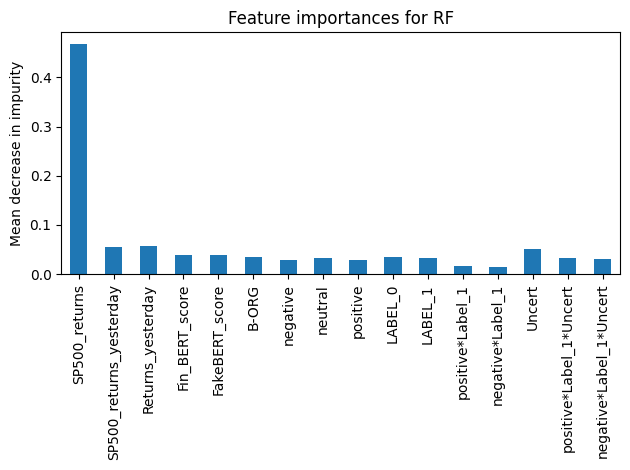

In [ ]:
ML.RF_class(naive=False)

In [ ]:
ML.LightGBM()

[I 2023-12-24 11:25:53,034] A new study created in memory with name: no-name-e21809b9-09ae-4420-89d4-41fb2aa8b1a5
[I 2023-12-24 11:25:53,627] Trial 0 finished with value: 0.6636104175939423 and parameters: {'lambda_l1': 0.0004907528919738577, 'lambda_l2': 0.0005137745293074045, 'num_leaves': 147, 'feature_fraction': 0.7446752271244113, 'bagging_fraction': 0.4856646174697634, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 0 with value: 0.6636104175939423.
[I 2023-12-24 11:25:54,149] Trial 1 finished with value: 0.6738148238203904 and parameters: {'lambda_l1': 0.004690243938827555, 'lambda_l2': 1.0508267341848759e-07, 'num_leaves': 103, 'feature_fraction': 0.9092424187984727, 'bagging_fraction': 0.4776532569901038, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 1 with value: 0.6738148238203904.
[I 2023-12-24 11:25:54,709] Trial 2 finished with value: 0.6815091666451832 and parameters: {'lambda_l1': 0.01324078179818013, 'lambda_l2': 0.009675906655572256, 'num_leave

Number of finished trials: 200
Best trial:
  Value: 0.6919570248796897
  Params: 
    lambda_l1: 2.2824110659168677e-07
    lambda_l2: 0.01724892216963634
    num_leaves: 9
    feature_fraction: 0.6794366464041097
    bagging_fraction: 0.9845270692487704
    bagging_freq: 3
    min_child_samples: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3371
[LightGBM] [Info] Number of data points in the train set: 29116, number of used features: 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3371
[LightGBM] [Info] Number of data points in the train set: 29117, number of used features: 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `forc

In [ ]:
ML.df.to_csv("Final_df.csv")

In [ ]:
ML.df.describe().to_excel("Final_df_description.xlsx")

In [ ]:
## Theoretically Full iteration of class in one run


## init class and import news df
ML = ML_build()
ML.news_df(News_dataset)

## Drop Non-english, duplicates and other
ML.data_preparation()


## Run DBSCAN model
ML.first_story_flag() ##WIP. Breaks on large dataset

## Run ML moddels
ML.BERT_sentiment_test()
ML.BERT_quality_test()
ML.BERT_NER_test()


##Save current changes to news dataframe
ML.save_BERT()
ML.load_BERT()

## Date adjustmens
ML.time_publication_adjustment() ##WIP. Non-naive (false) breaks on large dataset

##encoding specific variables
ML.One_hot_encode()

##Import stock data and merge data on Ticker + Date
ML.import_stock_data()
ML.prepare_final()

##train-test split with fixed random state = 42
ML.train_test_split()



####Data overveiw (Submission 2)

In [ ]:
# install the sweetviz package
!pip install sweetviz
# load the sweetviz
import sweetviz
# use analyze
analyze_df = sweetviz.analyze([ML.df, "df"], target_feat = 'Returns_binary')
# then show
analyze_df.show_html('analyze.html')

####Discontinued functions

In [ ]:
  def BERT_sentiment(self, column = 'Title' ):
    from transformers import pipeline
    nlp = pipeline(task='sentiment-analysis',
               model='ProsusAI/finbert', device=0)

    def classifier(text):
      return nlp(text)
      return f'{nlp(text)}'

    ## Cool code from stackoverflow https://stackoverflow.com/questions/64342621/how-to-apply-a-sentiment-classifier-to-a-dataframe
    self.df_news = (
    self.df_news
    .assign(sentiment = lambda x: x[column].progress_apply(lambda s: classifier(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))))

In [ ]:

  def BERT_quality(self, column = 'Title' ):
    from transformers import pipeline
    nlp = pipeline("text-classification", model="ikoghoemmanuell/finetuned_fake_news_roberta",
                   device=0)

    def classifier(text):
      return nlp(text)
      return f'{nlp(text)}'

    ## Cool code from stackoverflow https://stackoverflow.com/questions/64342621/how-to-apply-a-sentiment-classifier-to-a-dataframe
    self.df_news = (
    self.df_news
    .assign(sentiment = lambda x: x[column].progress_apply(lambda s: classifier(s)))
    .assign(
         Fake = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score_fake = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))))
    return







## Diploma extention

Fine-tuning BERT

Groupby news by date, time
Calculate rolling CAPM
Get abnormal returns
Fine-tune BERT

# Новый раздел

###Functions

In [ ]:
ML = ML_build()
ML.news_df(News_dataset.head(5)) ##init with small size
ML.load_BERT()
ML.One_hot_encode(OHE=False)

##Import stock data and merge data on Ticker + Date
ML.import_stock_data()

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]
ERROR:yfinance:FB: No data found, symbol may be delisted


FB not found on yfinance


ERROR:yfinance:BRK.B: No data found, symbol may be delisted


BRK.B not found on yfinance


In [ ]:
ML.df_news

Title  \
0        Apple and Imagination Technologies Bury the Ha...   
1        Apple's stock could be worth $100 more in 2020...   
2        Apple restores Imagination GPU chip agreement ...   
3        Demolition underway at Apple Valley, Summitvie...   
4         Want Fresh Fruit in Winter? Try Crab Apple Trees   
...                                                    ...   
5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...   
5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...   
5206363                      Baldur's Gate 3 Patch 2 notes   
5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...   
5206365  Padova Meeting: Bertolini chiude in bellezza l...   

                                                      link  \
0        https://news.google.com/rss/articles/CBMiQ2h0d...   
1        https://news.google.com/rss/articles/CBMiZmh0d...   
2        https://news.google.com/rss/articles/CBMiO2h0d...   
3        https://news.google.com/rss/articles/CBMirwFod...   
4        https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                    ...   
5206361  https://news.google.com/rss/articles/CBMicmh0d...   
5206362  https://news.google.com/rss/articles/CBMiWmh0d...   
5206363  https://news.google.com/rss/articles/CBMiRWh0d...   
5206364  https://news.google.com/rss/articles/CBMicWh0d...   
5206365  https://news.google.com/rss/articles/CBMic2h0d...   

                              Date     Ex. Company   FinBERT  Fin_BERT_score  \
0        2020-01-02 08:00:00+00:00  NASDAQ    AAPL   neutral        0.768137   
1        2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive        0.527611   
2        2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive        0.459613   
3        2020-01-01 08:00:00+00:00  NASDAQ    AAPL   neutral        0.892646   
4        2023-06-29 16:30:05+00:00  NASDAQ    AAPL   neutral        0.916618   
...                            ...     ...     ...       ...             ...   
5206361  2023-09-01 07:00:00+00:00  NASDAQ     TXN   neutral        0.658862   
5206362  2023-09-04 07:00:00+00:00  NASDAQ     TXN   neutral        0.724231   
5206363  2023-08-31 07:00:00+00:00  NASDAQ     TXN   neutral        0.913695   
5206364  2023-09-02 07:00:00+00:00  NASDAQ     TXN   neutral        0.827059   
5206365  2023-09-03 07:00:00+00:00  NASDAQ     TXN   neutral        0.845374   

        FakeBERT  FakeBERT_score                    Source  ... negative  \
0        LABEL_1        0.999787                  Wccftech  ...        0   
1        LABEL_0        0.999753                      CNBC  ...        0   
2        LABEL_0        0.999752                   9to5Mac  ...        0   
3        LABEL_0        0.999748    Yakima Herald-Republic  ...        0   
4        LABEL_1        0.999787  Lake Minnetonka Magazine  ...        0   
...          ...             ...                       ...  ...      ...   
5206361  LABEL_1        0.999788                  TipRanks  ...        0   
5206362  LABEL_1        0.999788             Seeking Alpha  ...        0   
5206363  LABEL_0        0.999562                 Shacknews  ...        0   
5206364  LABEL_1        0.999788             Seeking Alpha  ...        0   
5206365  LABEL_0        0.999695            Queen Atletica  ...        0   

        neutral  positive  LABEL_0  LABEL_1  Rel_neg  Rel_neut  Rel_pos  \
0             1         0        0        1        0         1        0   
1             0         1        1        0        0         0        1   
2             0         1        1        0        0         0        1   
3             1         0        1        0        0         1        0   
4             1         0        0        1        0         1        0   
...         ...       ...      ...      ...      ...       ...      ...   
5206361       1         0        0        1        0         1        0   
5206362       1         0        0        1        0         0        1   
5206363       

In [ ]:
conf_df = ML.df_news.copy()

Pret = conf_df['FinBERT']
Fine = conf_df['label']

In [ ]:
conf_df.columns

Index(['Title', 'link', 'Date', 'Ex.', 'Company', 'FinBERT', 'Fin_BERT_score',
       'FakeBERT', 'FakeBERT_score', 'Source', 'B-ORG', 'label', 'score',
       'negative', 'neutral', 'positive', 'LABEL_0', 'LABEL_1', 'Rel_neg',
       'Rel_neut', 'Rel_pos', 'positive*Label_1', 'negative*Label_1'],
      dtype='object')

In [ ]:
Fine_num = Fine.map({'positive': 0, 'negative': 1, 'neutral': 2})
Pret_num = Pret.map({'positive': 0, 'negative': 1, 'neutral': 2})

In [ ]:
df_confusion = pd.crosstab(Fine_num, Pret_num)

In [ ]:
df_confusion

FinBERT       0       1        2
label                           
0        478461  166623   967246
1          1532   92517    11776
2        262110  460421  2765680

In [ ]:
ML.df_news.columns

Index(['Title', 'link', 'Date', 'Ex.', 'Company', 'FinBERT', 'Fin_BERT_score',
       'FakeBERT', 'FakeBERT_score', 'Source', 'B-ORG', 'label', 'score',
       'negative', 'neutral', 'positive', 'LABEL_0', 'LABEL_1', 'Rel_neg',
       'Rel_neut', 'Rel_pos', 'positive*Label_1', 'negative*Label_1'],
      dtype='object')

In [ ]:
import scipy.stats as sci

df_stock = ML.df_stock.copy()
##df_stock = df_stock.drop('Adj Close', axis=1)
df_stock.dropna()

def Beta_calculation(df,window, stock='Returns', market ='SP500_returns'):


  df['Beta'] = np.nan
  df['AR'] = np.nan
  df['AR_signif'] = np.nan




  risk_free = yf.Ticker('^IRX')
  risk_free = risk_free.history(period="5y")['Close'] *0.01
  risk_free =risk_free.reset_index()
  risk_free.loc[:,'Date'] = pd.to_datetime(risk_free.loc[:,'Date'])
  risk_free['Date'] = risk_free['Date'].dt.date


  for i in df['symbol'].unique():
    sliced = df[df['symbol'] == i].copy()
    covariance = sliced[stock].rolling(window).cov(sliced[market])
    variance = sliced[market].rolling(window).var()
    ##print(covariance, variance)

    beta = covariance/variance
    sliced['Beta']= beta
    if i == 'AAPL':
      print(beta)
      print(sliced)
    ##df.loc[df['symbol'] == i, 'Beta'] = beta



    ##print(sliced)
    ##print(risk_free[risk_free['Date'].isin(sliced['Date'])])
    '''try:
      sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()
    except:
      sliced = sliced[sliced['Date'].isin(risk_free['Date'])]
      print(sliced)
      sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()


    sliced['model_ret'] = sliced['Risk_free'] + sliced['Beta'] *( sliced[market] - sliced['Risk_free'])'''


    sliced['model_ret'] = 0 + sliced['Beta'] *( sliced[market] - 0)
    sliced['AR'] = sliced['Returns'] - sliced['model_ret']
    sliced['AR'] = sliced['AR']*100

    '''est_window = 200
    sliced['Var'] = sliced['AR'].rolling(est_window, center=True).var()
    sliced['Statistic'] = sliced['AR']/ sliced['Var']
    crit_val = sci.norm.ppf(0.99)
    def test_crit(stat, crit):
      if stat >= crit:
        return 1
      elif stat <= -crit:
        return -1
      else:
        return 0
    sliced['AR_signif'] = sliced['Statistic'].apply(lambda x: test_crit(x, crit_val))'''
    crit_val = sci.norm.ppf(0.95)
    def test_crit(stat, crit):
      if stat >= crit:
        return 1
      elif stat <= -crit:
        return 2
      else:
        return 0
    sliced['AR_signif'] = sliced['AR'].apply(lambda x: test_crit(x, crit_val))




    df.update(sliced)
  return df
df_stock = Beta_calculation(df_stock, 20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1254    1.062148
1255    1.011901
1256    0.841437
1257    1.336750
1258    1.487619
Length: 1259, dtype: float64
            Date        Open        High         Low       Close     Volume  \
0     2019-06-13   46.976108   47.480371   46.710709   46.843407   86698400   
1     2019-06-14   46.216095   46.708293   45.914502   46.503212   75046000   
2     2019-06-17   46.541815   47.038843   46.365686   46.780678   58676400   
3     2019-06-18   47.301829   48.324830   47.099160   47.880886  106204000   
4     2019-06-19   48.177654   48.225911   47.605835   47.740948   84496800   
...          ...         ...         ...         ...         ...        ...   
1254  2024-06-06  195.690002  196.500000  194.169998  194.479996   41181800   
1255  2024-06-07  194.649994  196.940002  194.139999  196.889999   53103900   
1256  2024-06-10  196.899994  197.300003  192.149994  193.119995   972621

In [ ]:
from inspect import EndOfBlock
import scipy.stats as sci

df_stock = ML.df_stock.copy()
##df_stock = df_stock.drop('Adj Close', axis=1)
##df_stock.dropna()

def Beta_calculation(df,window, stock='Returns', market ='SP500_returns'):


  symbols = df['symbol'].dropna().unique()
  df.set_index(['symbol', "Date"],  inplace=True)



  df['Beta'] = np.nan
  df['AR'] = np.nan
  df['AR_signif'] = np.nan

  est_window = 50
  event_window = 10

  df['Event'] = np.nan
  df['Event_ID'] = np.nan





  risk_free = yf.Ticker('^IRX')
  risk_free = risk_free.history(period="5y")['Close'] *0.01
  risk_free =risk_free.reset_index()
  risk_free.loc[:,'Date'] = pd.to_datetime(risk_free.loc[:,'Date'])
  risk_free['Date'] = risk_free['Date'].dt.date

  unique_ID = 0
  for i in symbols:

    unique_ID = round(unique_ID/100)*100
    unique_ID += 100


    print(i)
    sliced_by_company = df.loc[i].copy()
    sliced_by_company.reset_index(inplace=True)



    print(sliced_by_company.index[sliced_by_company['Reported EPS'].notna()].tolist())
    ##print(sliced_by_company[sliced_by_company['Reported EPS'].notna()])

    for event in sliced_by_company.index[sliced_by_company['Surprise(%)'].notna()].tolist():

      unique_ID += 1

      Start_of_slice = int(event- event_window/2 -est_window)
      End_of_slice = int(event+ event_window/2)

      ##print(Start_of_slice,int(event-event_window/2),  End_of_slice)
      sliced = sliced_by_company[Start_of_slice : End_of_slice].copy()

      sliced["Event_ID"] = unique_ID
      sliced.loc[int(event-event_window/2)  : End_of_slice, "Event" ] = 1

      stock_var = sliced.loc[Start_of_slice: int(event-event_window/2), stock]
      market_var = sliced.loc[Start_of_slice: int(event-event_window/2), market]

      '''covariance = sliced[stock].cov(sliced[market])
      variance = sliced[market].var()'''

      covariance = stock_var.cov(market_var)
      variance = market_var.var()

      ##print(covariance, variance)

      beta = covariance/variance
      sliced['Beta']= beta
      if i == 'AAPL':
        print(beta)
        ##print(sliced)
      ##df.loc[df['symbol'] == i, 'Beta'] = beta



      ##print(sliced)
      ##print(risk_free[risk_free['Date'].isin(sliced['Date'])])
      '''sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].copy()
      try:
        sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()
      except:
        ##print(sliced['Risk_free'])
        print(len(sliced['Date']))
        sliced = sliced[sliced['Date'].isin(risk_free['Date'])]
        print(len(sliced['Date']))

        sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()'''

      ## CAPM with risk-free
      ##sliced['model_ret'] = sliced['Risk_free'] + sliced['Beta'] *( sliced[market] - sliced['Risk_free'])

      sliced['model_ret'] = 0 + sliced['Beta'] *( sliced[market] - 0)
      sliced['AR'] = sliced['Returns'] - sliced['model_ret']
      sliced['AR'] = sliced['AR']*100



      crit_val = sci.norm.ppf(0.95)
      def test_crit(stat, crit):
        if stat >= crit:
          return 1
        elif stat <= -crit:
          return 2
        else:
          return 0
      sliced['AR_signif'] = sliced['AR'].apply(lambda x: test_crit(x, crit_val))

      sliced_by_company.update(sliced, overwrite=False)


      if i == 'AAPL':
        test_df = df.copy()

      print(unique_ID)

    sliced_by_company['symbol'] = i
    sliced_by_company.set_index(['symbol', 'Date'], inplace=True)

    try:
      df.update(sliced_by_company, overwrite=False)
    except:
      print(sliced_by_company)


  df.reset_index(inplace= True)
  return df, test_df
df_stock, test_df = Beta_calculation(df_stock, 30)

AAPL
[409, 472, 534, 600, 662, 725, 787, 851, 917, 980, 1042, 1106, 1167, 1185, 1230]
1.4767233893418172
101
1.488769846900304
102
1.0854431517597662
103
1.3951718258828703
104
1.2182002961148852
105
1.2237553627223947
106
1.2765426411070098
107
1.2026242250288397
108
1.572371515478394
109
1.0851377928451327
110
0.9687637635661989
111
1.2363566190733197
112
1.0192213952548923
113
1.1440082666258171
114
0.6890105967669198
115
MSFT
[598, 660, 723, 785, 849, 910, 973, 1035, 1099, 1165, 1190, 1225, 1243]
201
202
203
204
205
206
207
208
209
210
211
212
213
GOOGL
[471, 534, 598, 665, 723, 785, 849, 917, 973, 1035, 1099, 1165, 1190, 1225]
301
302
303
304
305
306
307
308
309
310
311
312
313
314
GOOG
[471, 534, 598, 665, 723, 785, 849, 917, 973, 1035, 1099, 1165, 1190, 1225]
401
402
403
404
405
406
407
408
409
410
411
412
413
414
AMZN
[413, 473, 536, 600, 667, 725, 787, 851, 917, 975, 1042, 1101, 1167, 1228, 1244]
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
TSLA
[409, 470, 533, 

In [ ]:
df_stock.to_csv('df_stock.csv', index=True)

In [ ]:
df_stock = pd.read_csv("/content/df_stock.csv")
df_stock['Date'] = pd.to_datetime(df_stock.loc[:,'Date'])
df_stock['Date'] = df_stock['Date'] .dt.date

In [ ]:
News_df = ML.df_news.copy()

In [ ]:
News_df[0].columns

Index(['positive', 'negative', 'positive*Label_1', 'negative*Label_1',
       'positive*Label_0', 'negative*Label_0', 'Rel_pos*Label_1',
       'Rel_neg*Label_1', 'Rel_pos*Label_0', 'Rel_neg*Label_0'],
      dtype='object')

In [ ]:
New_cols = ["N_", "n_", "P_", "L0_", "L1_", "RN_", "Rn_", "RP_" ]
old_cols = ['negative', 'neutral', 'positive', 'LABEL_0', 'LABEL_1', 'Rel_neg',
       'Rel_neut', 'Rel_pos']
for lag in [20, 40, 60, 120]:
  names = [ i + str(lag) for i in New_cols]
  print(names)
  News_df[names] = News_df[old_cols].rolling(window=lag).sum()

['N_20', 'n_20', 'P_20', 'L0_20', 'L1_20', 'RN_20', 'Rn_20', 'RP_20']
['N_40', 'n_40', 'P_40', 'L0_40', 'L1_40', 'RN_40', 'Rn_40', 'RP_40']
['N_60', 'n_60', 'P_60', 'L0_60', 'L1_60', 'RN_60', 'Rn_60', 'RP_60']
['N_120', 'n_120', 'P_120', 'L0_120', 'L1_120', 'RN_120', 'Rn_120', 'RP_120']


In [ ]:
def prepare_news_df( curated= True, Organisation = True):
  News_df = ML.df_news.copy()
  News_df =News_df.reset_index()

  Date_col= pd.to_datetime(News_df['Date'], utc=True, errors='coerce')
  News_df['Date'] = Date_col.dt.date





  News_df['positive*Label_0'] = News_df['positive'] * News_df['LABEL_0']
  News_df['negative*Label_0'] = News_df['negative'] * News_df['LABEL_0']


  ##Relevance adjustment
  News_df['Rel_pos*Label_1'] = News_df['Rel_pos'] * News_df['LABEL_1']
  News_df['Rel_neg*Label_1'] = News_df['Rel_neg'] * News_df['LABEL_1']
  News_df['Rel_pos*Label_0'] = News_df['Rel_pos'] * News_df['LABEL_0']
  News_df['Rel_neg*Label_0'] = News_df['Rel_neg'] * News_df['LABEL_0']

  Original_News_df = News_df.copy()

  if Organisation == True:
    News_df = News_df[News_df['B-ORG'] == 1]

  if curated==True:
    sources_df = pd.read_excel("/content/Sources_class.xlsx", header=1).fillna(0)

    News_df = News_df.merge(sources_df, on="Source", how='left')
    News_df =News_df.drop("Source", axis=1)
    News_df =News_df.drop("count", axis=1)
    News_df = News_df[(News_df['Relevant'] >0) | (News_df['Traditional'] >0)]

  News_df = News_df[["Date", "Company", 'positive', 'negative',
                    'positive*Label_1', 'negative*Label_1', 'positive*Label_0','negative*Label_0',
                    'Rel_pos*Label_1', 'Rel_neg*Label_1', 'Rel_pos*Label_0', 'Rel_neg*Label_0']]


  News_df= News_df.groupby(['Company', 'Date']).sum()

  return News_df, Original_News_df

def merge_stock_news(news_df, stock_df, only_rel =True, no_Events=False ):

  df_stock = pd.merge(stock_df, news_df.reset_index(), left_on=['symbol', 'Date'],
                       right_on=['Company', 'Date'], how="left")


  print(df_stock)
  df_stock = df_stock[df_stock['Date'] >= pd.to_datetime('2020-01-01').date() ]
  df_stock = df_stock[df_stock['Date'] <= pd.to_datetime('2023-09-01').date() ]


  ## Market uncertanty index

  Uncertainty_df = pd.DataFrame()
  for date in df_stock.Date.unique():
    Set = df_stock[df_stock.Date == date]
    Positive_sum = Set['positive'].sum()
    Negative_sum = Set['negative'].sum()
    try:

      Uncert = max(0, 1- Negative_sum / (Positive_sum + Negative_sum))
      ##print(Positive_sum, Negative_sum, Uncert)

    except:
      Uncert = 0
    df_stock.loc[df_stock.Date == date, 'Uncert']  = Uncert
    day_dict = {"Date": date, "Uncert": Uncert}
    Uncertainty_df = pd.concat([Uncertainty_df, pd.DataFrame([day_dict])], ignore_index=True)
    ##Uncertainty_df = Uncertainty_df.append(day_dict)

  print(Uncertainty_df)

  ## Event window

  try:
    df_stock["Event_only_index"] =np.nan
    df_stock.loc[(df_stock["Event"]==1) & (df_stock["Event_ID"].notna()), "Event_only_index"] = df_stock["Event_ID"]

  except:
    print('Error in EVENT_ID column')


  ## Amihud computation

  df_stock["Illiquidity"] = abs(df_stock["Returns"])/(df_stock["High"] * df_stock["High"]*df_stock["Volume"]/2)

  grouped = df_stock.drop("Date", axis=1).groupby('symbol')
  print(grouped)


  results = {'symbol':[], 'illiquidity':[]}
  for item, grp in grouped:
    print(item)
    ##print(grp.tail(2))

    ##subset_mean = grp.tail(2).sum()[0]
    subset_mean =grp["Illiquidity"].mean()
    print(subset_mean)
    results['symbol'].append(item)
    results['illiquidity'].append(subset_mean)

  print(results)
  res_df = pd.DataFrame(results)
  Quant = res_df["illiquidity"].quantile(0.75)
  res_df['Illiq'] = res_df['illiquidity'].ge(Quant).astype(int)
  df_stock = df_stock.merge(res_df, on='symbol', how='left')


  ##Sentiment index
  New_cols = ["PL1_", "NL1_", "PL0_", "NL0_", "RPL1_","RNL1_", "RPL0_", "RNL0_"]
  old_cols = ['positive*Label_1', 'negative*Label_1', 'positive*Label_0', 'negative*Label_0', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
        'Rel_pos*Label_0', 'Rel_neg*Label_0']
  for lag in [20, 40, 60, 120]:
    names = [ i + str(lag) for i in New_cols]
    print(names)
    df_stock[names] = df_stock[old_cols].rolling(window=lag).sum()

  df_stock.reset_index(inplace=True)



  if no_Events == True:

    df_stock["Date"] = pd.to_datetime(df_stock["Date"])

    test = df_stock[["Date",  'Volume', 'Dividends', 'Stock Splits', 'Market_Cap', 'SP500_returns', 'SP500_returns_yesterday', 'Returns', 'AR', 'EPS Estimate', 'Reported EPS',
       'Surprise(%)', 'symbol', 'positive*Label_1',
       'negative*Label_1', 'positive*Label_0', 'negative*Label_0', 'Uncert',
       'Event_only_index', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', "Illiq",'PL1_20', 'NL1_20', 'PL0_20',
       'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20', 'PL1_40',
       'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40',
       'RNL0_40', 'PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60',
       'RPL0_60', 'RNL0_60', 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120',
       'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120']]
    model_run = test.groupby(['symbol', 'Date']).sum()
    ##return model_run, df_stock

  else:

    test = df_stock[['Date', 'Volume', 'Dividends', 'Stock Splits', 'Market_Cap', 'SP500_returns', 'SP500_returns_yesterday', 'Returns', 'AR', 'EPS Estimate', 'Reported EPS',
        'Surprise(%)', 'symbol', 'Event', 'Event_ID', 'positive*Label_1',
        'negative*Label_1', 'positive*Label_0', 'negative*Label_0', 'Uncert',
        'Event_only_index', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
        'Rel_pos*Label_0', 'Rel_neg*Label_0', "Illiq",'PL1_20', 'NL1_20', 'PL0_20',
        'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20', 'PL1_40',
        'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40',
        'RNL0_40', 'PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60',
        'RPL0_60', 'RNL0_60', 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120',
        'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120']]

    test2 = test.drop(test[test['Event_only_index'] == 0.0].index)
    ##model_run = test2.groupby(['symbol', 'Event_only_index']).sum()

    ##text_cols = df.columns[1:3]
    data_cols = set(test2.columns) - set(["Date", 'symbol'])
    d1 = dict.fromkeys(data_cols, 'sum')
    d2 = dict.fromkeys(["Date"], 'first')
    d = {**d1, **d2}

    model_run = test2.groupby(['symbol', 'Event_only_index']).agg(d)
    print(model_run)

    ## Fill in uncertainty index
    model_run.drop("Uncert", axis=1, inplace=True)

    def get_uncertainty(df, df_uncert):

      date = df['Date']
      Index_value = df_uncert[df_uncert['Date'] == date]['Uncert'].values[0]
      print(date, Index_value)
      return Index_value

    model_run['Uncert']= model_run.apply(lambda x: get_uncertainty(x, Uncertainty_df), axis =1)
  ##model_run= model_run.merge(Uncertainty_df, how='left', on=['Date'])
  print(model_run)
  ##model_run.set_index(['symbol', 'Event_only_index'], inplace=True)




  ##functions for other columns
  def new_dummy(df, key_col, col_to_apply):
    for i in col_to_apply:
      name = i +"_" + key_col
      print(name)
      df[name] = df[key_col]* df[i]
    return df


  def new_index(df, Positive, all_cols, scale=10):
    for i in Positive:
      name = i +"_" + "index"
      print(name)

      Index_of_Negative = all_cols.index(i) +1
      neg_col = all_cols[Index_of_Negative]
      df[name] = (df[i] - df[neg_col])/ (df[i] + df[neg_col])/10
    return df

  Lag_list = ['PL1_20', 'NL1_20',
       'PL0_20', 'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20',
       'PL1_40', 'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40',
       'RNL0_40', 'PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60',
       'RPL0_60', 'RNL0_60', 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120',
       'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120']

  Positive_values = ['PL1_20', 'PL0_20',  'RPL1_20',  'RPL0_20',
        'PL1_40', 'PL0_40',  'RPL1_40', 'RPL0_40', 'PL1_60', 'PL0_60', 'RPL1_60',
        'RPL0_60', 'PL1_120', 'PL0_120', 'RPL1_120',  'RPL0_120']
  Negative_values = list(set(Lag_list) - set(Positive_values))
  model_run = new_index(model_run, Positive_values, Lag_list)



  index_list =['PL1_20_index', 'PL0_20_index','RPL1_20_index', 'RPL0_20_index',
               'PL1_40_index', 'PL0_40_index', 'RPL1_40_index', 'RPL0_40_index',
               'PL1_60_index', 'PL0_60_index', 'RPL1_60_index', 'RPL0_60_index',
               'PL1_120_index', 'PL0_120_index','RPL1_120_index', 'RPL0_120_index']

  model_run = new_dummy(model_run, "Uncert", index_list)
  model_run = new_dummy(model_run, "Illiq", index_list)


  Col_list = ['positive*Label_1', 'negative*Label_1', 'positive*Label_0',
              'negative*Label_0', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
              'Rel_pos*Label_0', 'Rel_neg*Label_0']
  model_run = new_dummy(model_run, "Uncert", Col_list)
  model_run = new_dummy(model_run, "Illiq", Col_list)




  return model_run, df_stock

News_df = prepare_news_df(curated= True, Organisation = True)

model_run = merge_stock_news(News_df[0], df_stock, only_rel=False, no_Events=False )

      symbol        Date        Open        High         Low       Close  \
0       AAPL  2019-05-24   43.477633   43.945705   43.096419   43.180866   
1       AAPL  2019-05-28   43.168803   43.571731   42.925117   43.002323   
2       AAPL  2019-05-29   42.565612   43.272548   42.464278   42.797237   
3       AAPL  2019-05-30   42.934752   43.243583   42.625921   43.019199   
4       AAPL  2019-05-31   42.519763   42.944408   42.220585   42.239887   
...      ...         ...         ...         ...         ...         ...   
61692    TXN  2024-05-17  195.000000  196.550003  193.830002  195.020004   
61693    TXN  2024-05-20  195.020004  199.270004  194.500000  199.199997   
61694    TXN  2024-05-21  197.169998  199.300003  196.839996  199.009995   
61695    TXN  2024-05-22  199.970001  203.619995  199.649994  202.539993   
61696    TXN  2024-05-23  202.600006  202.949997  196.839996  197.289993   

          Volume  Dividends  Stock Splits  Diluted Average Shares  ...  \
0       94858

In [ ]:
model_run[0]

RNL1_60  NL0_60  NL1_40  RNL0_120  RNL1_40  \
symbol Event_only_index                                               
AAPL   101.0                18.0   794.0   144.0     271.0     14.0   
       102.0                 0.0     0.0     0.0       0.0      0.0   
       103.0                 0.0   451.0    74.0       0.0      0.0   
       104.0                 0.0     0.0     0.0       0.0      0.0   
       105.0                23.0   605.0    84.0       0.0     20.0   
...                          ...     ...     ...       ...      ...   
XOM    1806.0               30.0   929.0   102.0     138.0     30.0   
       1807.0               20.0  1074.0   224.0     170.0      0.0   
       1808.0               19.0  1155.0   254.0     128.0      9.0   
       1809.0               20.0  1382.0   278.0     138.0     20.0   
       1810.0                0.0     0.0     0.0       0.0      0.0   

                         Rel_neg*Label_0  RPL1_20  RPL0_60  positive*Label_0  \
symbol Event_only_index                                                        
AAPL   101.0                         0.0    174.0    723.0              15.0   
       102.0                         4.0     74.0      0.0               8.0   
       103.0                         0.0     95.0    372.0               2.0   
       104.0                         0.0      0.0      0.0               7.0   
       105.0                         1.0    194.0    561.0              10.0   
...                                  ...      ...      ...               ...   
XOM    1806.0                        3.0     99.0   1659.0              30.0   
       1807.0                        0.0    331.0   1895.0              26.0   
       1808.0                        2.0    341.0   1602.0              20.0   
       1809.0                        1.0    430.0   1806.0              36.0   
       1810.0                        1.0    251.0      0.0              80.0   

                         PL1_120  ...  Rel_neg*Label_0_Uncert  \
symbol Event_only_index           ...                           
AAPL   101.0               274.0  ...                0.000000   
       102.0                 0.0  ...                2.598071   
       103.0                 0.0  ...                0.000000   
       104.0                 0.0  ...                0.000000   
       105.0                 0.0  ...                0.712166   
...                          ...  ...                     ...   
XOM    1806.0              486.0  ...                1.253571   
       1807.0              495.0  ...                0.000000   
       1808.0              695.0  ...                1.004049   
       1809.0              783.0  ...                0.542614   
       1810.0                0.0  ...                0.642045   

                         positive*Label_1_Illiq  negative*Label_1_Illiq  \
symbol Event_only_index                                                   
AAPL   101.0                                0.0                     0.0   
       102.0                                0.0                     0.0   
       103.0                                0.0                     0.0   
       104.0                                0.0                     0.0   
       105.0                                0.0                     0.0   
...                                         ...                     ...   
XOM    1806.0                              30.0                    50.0   
       1807.0                             130.0                    70.0   
       1808.0                              50.0                    80.0   
       1809.0                             110.0                   150.0   
       1810.0                             300.0                   300.0   

                         positive*Label_0_Illiq  negative*Label_0_Illiq  \
symbol Event_only_index                                                   
AAPL   101.0                                0.0                     0.0   
       102.0 

In [ ]:
!pip install linearmodels -q
import linearmodels as lm
model_run[0]['const'] = 1
model_run[0]['Market_Cap'] = np.log(model_run[0]['Market_Cap'])
model_run[0]['Volume'] = np.log(model_run[0]['Volume'])

In [ ]:
for i in model_run[0].columns:
  print(i)

RNL1_60
NL0_60
NL1_40
RNL0_120
RNL1_40
Rel_neg*Label_0
RPL1_20
RPL0_60
positive*Label_0
PL1_120
Market_Cap
Rel_pos*Label_0
NL0_120
Event
Rel_pos*Label_1
negative*Label_0
RNL0_60
SP500_returns
Rel_neg*Label_1
PL1_60
RPL1_60
Returns
RNL0_20
Stock Splits
Event_only_index
PL1_40
PL0_20
Dividends
PL1_20
PL0_60
PL0_120
RNL1_20
NL1_60
Illiq
NL0_40
RPL1_40
EPS Estimate
Volume
Reported EPS
RNL1_120
RPL1_120
NL0_20
RPL0_20
RPL0_120
AR
Event_ID
PL0_40
RNL0_40
Surprise(%)
positive*Label_1
SP500_returns_yesterday
NL1_120
NL1_20
negative*Label_1
RPL0_40
Date
Uncert
PL1_20_index
PL0_20_index
RPL1_20_index
RPL0_20_index
PL1_40_index
PL0_40_index
RPL1_40_index
RPL0_40_index
PL1_60_index
PL0_60_index
RPL1_60_index
RPL0_60_index
PL1_120_index
PL0_120_index
RPL1_120_index
RPL0_120_index
PL1_20_index_Uncert
PL0_20_index_Uncert
RPL1_20_index_Uncert
RPL0_20_index_Uncert
PL1_40_index_Uncert
PL0_40_index_Uncert
RPL1_40_index_Uncert
RPL0_40_index_Uncert
PL1_60_index_Uncert
PL0_60_index_Uncert
RPL1_60_index_Unce

In [ ]:
endog = model_run[0]['AR']

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'Surprise(%)', 'Dividends', 'Market_Cap']]
m = lm.PanelOLS(endog,exogen, entity_effects=True, check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True, )

print(H1)
exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0',
                       'Surprise(%)', 'Dividends', 'Market_Cap',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True, check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True, )

print(H1)

'''exogen = model_run[0][['positive*Label_1','negative*Label_1’, ‘negative*Label_0',
                       'Surprise(%)', 'Dividends', 'Market_Cap',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True, check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True, )

print(H1)'''


exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'Dividends', 'Market_Cap', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True, check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True, )

print(H1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0281
Estimator:                   PanelOLS   R-squared (Between):             -963.44
No. Observations:                 343   R-squared (Within):               0.0281
Date:                Fri, May 24 2024   R-squared (Overall):             -140.60
Time:                        10:32:09   Log-likelihood                   -968.46
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.7288
Entities:                          39   P-value                           0.1278
Avg Obs:                       8.7949   Distribution:                   F(5,299)
Min Obs:                       2.0000                                           
Max Obs:                       13.000   F-statistic (robust):             2.2280
                            

In [ ]:
endog = model_run[0]['AR']

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'Dividends', 'Market_Cap', 'Volume',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True, check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True, )

print(H1)

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'positive*Label_1_Uncert',
                       'negative*Label_1_Uncert', 'positive*Label_0_Uncert',
                       'negative*Label_0_Uncert', 'Dividends', 'Market_Cap', 'Volume',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H2  = m.fit(cov_type='clustered', cluster_entity=True)

print(H2)


exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'positive*Label_1_Illiq',
                       'negative*Label_1_Illiq', 'positive*Label_0_Illiq',
                       'negative*Label_0_Illiq',  'Market_Cap', 'Volume', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H3  = m.fit(cov_type='clustered', cluster_entity=True)

print(H3)

In [ ]:
for i in model_run[0].columns:
  print(i)

PL0_40
PL1_20
AR
RNL1_40
negative*Label_1
Dividends
NL1_60
RPL0_40
NL0_60
SP500_returns_yesterday
NL0_120
NL0_20
RNL0_20
RNL0_60
RPL1_120
Rel_pos*Label_1
RPL1_60
Volume
RNL0_120
EPS Estimate
Rel_neg*Label_1
Surprise(%)
NL0_40
PL0_60
Rel_pos*Label_0
RPL0_120
negative*Label_0
Illiq
RPL1_20
RPL0_60
PL0_20
positive*Label_1
Stock Splits
RPL1_40
PL1_120
positive*Label_0
PL1_60
Reported EPS
RNL0_40
Rel_neg*Label_0
Event_only_index
PL1_40
RNL1_60
PL0_120
SP500_returns
RNL1_120
Market_Cap
RPL0_20
Event
RNL1_20
NL1_120
Returns
NL1_40
NL1_20
Event_ID
Date
Uncert
PL1_20_index
PL0_20_index
RPL1_20_index
RPL0_20_index
PL1_40_index
PL0_40_index
RPL1_40_index
RPL0_40_index
PL1_60_index
PL0_60_index
RPL1_60_index
RPL0_60_index
PL1_120_index
PL0_120_index
RPL1_120_index
RPL0_120_index
PL1_20_index_Uncert
PL0_20_index_Uncert
RPL1_20_index_Uncert
RPL0_20_index_Uncert
PL1_40_index_Uncert
PL0_40_index_Uncert
RPL1_40_index_Uncert
RPL0_40_index_Uncert
PL1_60_index_Uncert
PL0_60_index_Uncert
RPL1_60_index_Unce

In [ ]:
model_run[0]

PL0_40  PL1_20        AR  RNL1_40  negative*Label_1  \
symbol Event_only_index                                                        
AAPL   101.0              322.0    63.0  1.545491     14.0               8.0   
       102.0                0.0    76.0 -4.929750      0.0               2.0   
       103.0              158.0    53.0  0.325211      0.0               3.0   
       104.0                0.0     0.0  1.179269      0.0               3.0   
       105.0              219.0   112.0  0.256054     20.0               0.0   
...                         ...     ...       ...      ...               ...   
XOM    1806.0             639.0    38.0 -5.201969     30.0               5.0   
       1807.0             670.0   172.0  2.177860      0.0               7.0   
       1808.0             615.0   124.0  0.159685      9.0               8.0   
       1809.0             800.0   235.0 -3.582040     20.0              15.0   
       1810.0               0.0   122.0  2.444896      0.0              30.0   

                         Dividends  NL1_60  RPL0_40  NL0_60  \
symbol Event_only_index                                       
AAPL   101.0                   0.0   183.0    564.0   794.0   
       102.0                   0.0     0.0      0.0     0.0   
       103.0                   0.0   144.0    276.0   451.0   
       104.0                   0.0     0.0      0.0     0.0   
       105.0                   0.0   145.0    392.0   605.0   
...                            ...     ...      ...     ...   
XOM    1806.0                  0.0   115.0   1046.0   929.0   
       1807.0                  0.0   276.0   1403.0  1074.0   
       1808.0                  0.0   369.0   1014.0  1155.0   
       1809.0                  0.0   376.0   1307.0  1382.0   
       1810.0                  0.0     0.0      0.0     0.0   

                         SP500_returns_yesterday  ...  Rel_pos*Label_0_Uncert  \
symbol Event_only_index                           ...                           
AAPL   101.0                           -0.017352  ...               10.639594   
       102.0                           -0.007033  ...                8.443730   
       103.0                            0.019769  ...                2.758621   
       104.0                            0.024475  ...                3.787500   
       105.0                            0.007162  ...                5.697329   
...                                          ...  ...                     ...   
XOM    1806.0                           0.048685  ...               17.967857   
       1807.0                           0.002456  ...               15.720472   
       1808.0                           0.054004  ...               12.550607   
       1809.0                          -0.006152  ...               23.332386   
       1810.0                          -0.016814  ...               60.352273   

                         Rel_neg*Label_0_Uncert  positive*Label_1_Illiq  \
symbol Event_only_index                                                   
AAPL   101.0                           0.000000                     0.0   
       102.0                           2.598071                     0.0   
       103.0                           0.000000                     0.0   
       104.0                           0.000000                     0.0   
       105.0                           0.712166                     0.0   
...                                         ...                     ...   
XOM    1806.0                          1.253571                    30.0   
       1807.0                          0.000000                   130.0   
       1808.0                          1.004049                    50.0   
       1809.0                          0.542614                   110.0   
       1810.0                          0.642045                   300.0   

                         negative*Label_1_Illiq  positive*Label_0_Illiq  \
symbol Event_only_index                                    

In [ ]:
News_df[1][['Title','Company', 'B-ORG']]

Title Company B-ORG
0        Apple and Imagination Technologies Bury the Ha...    AAPL     1
1        Apple's stock could be worth $100 more in 2020...    AAPL     1
2        Apple restores Imagination GPU chip agreement ...    AAPL     1
3        Demolition underway at Apple Valley, Summitvie...    AAPL     0
4         Want Fresh Fruit in Winter? Try Crab Apple Trees    AAPL     0
...                                                    ...     ...   ...
5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...     TXN     1
5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...     TXN     0
5206363                      Baldur's Gate 3 Patch 2 notes     TXN     1
5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...     TXN     0
5206365  Padova Meeting: Bertolini chiude in bellezza l...     TXN     0

[5206366 rows x 3 columns]

In [ ]:
model_run[0]
print(model_run())\
print(model_run[0])
print(apple.run)
if succes == True:
  while i > =10:
    print(model_run[0])
    i += 1

Volume  Dividends  Stock Splits  SP500_returns  \
symbol Event_only_index                                                       
AAPL   101.0             1245466000        0.0           0.0      -0.005386   
       102.0              946392400        0.0           0.0       0.006134   
       103.0              806333100        0.0           0.0       0.026433   
       104.0              711266200        0.0           0.0       0.024671   
       105.0             1189197800        0.0           0.0       0.005733   
...                             ...        ...           ...            ...   
XOM    1806.0             209301000        0.0           0.0       0.032358   
       1807.0             205698100        0.0           0.0       0.027663   
       1808.0             186339300        0.0           0.0       0.043519   
       1809.0             173614300        0.0           0.0      -0.018431   
       1810.0             164849400        0.0           0.0      -0.011892   

                         SP500_returns_yesterday   Returns         AR  \
symbol Event_only_index                                                 
AAPL   101.0                           -0.017352  0.007502   0.905491   
       102.0                           -0.007033 -0.040165  -5.029750   
       103.0                            0.019769  0.031943  -0.102789   
       104.0                            0.024475  0.046213   0.698269   
       105.0                            0.007162  0.009545  -1.486946   
...                                          ...       ...        ...   
XOM    1806.0                           0.048685 -0.036023 -28.929969   
       1807.0                           0.002456  0.042515 -37.355140   
       1808.0                           0.054004  0.031994 -45.242315   
       1809.0                          -0.006152 -0.051314 -53.211039   
       1810.0                          -0.016814  0.018615 -50.120105   

                         EPS Estimate  Reported EPS  Surprise(%)  ...  \
symbol Event_only_index                                           ...   
AAPL   101.0                     1.41          1.68       0.1902  ...   
       102.0                     0.99          1.40       0.4189  ...   
       103.0                     1.01          1.30       0.2912  ...   
       104.0                     1.24          1.24       0.0030  ...   
       105.0                     1.89          2.10       0.1117  ...   
...                               ...           ...          ...  ...   
XOM    1806.0                    3.74          4.14       0.1077  ...   
       1807.0                    3.79          4.45       0.1733  ...   
       1808.0                    3.29          3.40       0.0319  ...   
       1809.0                    2.59          2.83       0.0943  ...   
       1810.0                    2.01          1.94      -0.0369  ...   

                         Rel_pos*Label_0_Uncert  Rel_neg*Label_0_Uncert  \
symbol Event_only_index                                                   
AAPL   101.0                         363.283919               11.910948   
       102.0                         322.755900               77.461416   
       103.0                         221.834700                5.995532   
       104.0                         174.082050               31.086080   
       105.0                         290.120179               35.524920   
...                                         ...                     ...   
XOM    1806.0                        360.359862               22.175991   
       1807.0                        262.294192                0.000000   
       1808.0                        282.455122               16.295488   
       1809.0                        297.267007               26.541697   
       1810.0                        849.929478               22.971067   

                         positive*Label_1_Illiq  negative*Label_1_Illiq  \
symbol Event_only_index                           

In [ ]:
model_run[0]

Volume  Dividends  Stock Splits    Market_Cap  \
symbol Date                                                           
AAPL   2020-01-02  135480400        0.0           0.0  1.278867e+12   
       2020-01-03  146322800        0.0           0.0  1.266434e+12   
       2020-01-06  118387200        0.0           0.0  1.276525e+12   
       2020-01-07  108872000        0.0           0.0  1.270521e+12   
       2020-01-08  132079200        0.0           0.0  1.290959e+12   
...                      ...        ...           ...           ...   
XOM    2023-08-28   10382100        0.0           0.0  4.506701e+11   
       2023-08-29    9665000        0.0           0.0  4.533536e+11   
       2023-08-30   11922100        0.0           0.0  4.577711e+11   
       2023-08-31   17479800        0.0           0.0  4.590510e+11   
       2023-09-01   14828400        0.0           0.0  4.686704e+11   

                   SP500_returns  SP500_returns_yesterday   Returns        AR  \
symbol Date                                                                     
AAPL   2020-01-02       0.004062                 0.002631  0.013874  0.822130   
       2020-01-03       0.002631                 0.008929  0.000942 -0.272142   
       2020-01-06       0.008929                -0.001444  0.020457  0.665910   
       2020-01-07      -0.001444                 0.004465 -0.004836 -0.254856   
       2020-01-08       0.004465                 0.002655  0.020292  1.341170   
...                          ...                      ...       ...       ...   
XOM    2023-08-28       0.001645                 0.014636  0.006547  0.564982   
       2023-08-29       0.014636                 0.003229  0.001368 -0.517260   
       2023-08-30       0.003229                -0.002070  0.003984  0.266155   
       2023-08-31      -0.002070                -0.003273  0.000630  0.143860   
       2023-09-01      -0.003273                -0.002933  0.011765  1.288405   

                   EPS Estimate  Reported EPS  ...  Rel_pos*Label_0_Uncert  \
symbol Date                                    ...                           
AAPL   2020-01-02           0.0           0.0  ...                0.985915   
       2020-01-03           0.0           0.0  ...                0.396396   
       2020-01-06           0.0           0.0  ...                0.568966   
       2020-01-07           0.0           0.0  ...                0.785714   
       2020-01-08           0.0           0.0  ...                1.318681   
...                         ...           ...  ...                     ...   
XOM    2023-08-28           0.0           0.0  ...                1.331818   
       2023-08-29           0.0           0.0  ...                0.687692   
       2023-08-30           0.0           0.0  ...                5.125000   
       2023-08-31           0.0           0.0  ...                2.418605   
       2023-09-01           0.0           0.0  ...                0.000000   

                   Rel_neg*Label_0_Uncert  positive*Label_1_Illiq  \
symbol Date                                                         
AAPL   2020-01-02                     0.0                     0.0   
       2020-01-03                     0.0                     0.0   
       2020-01-06                     0.0                     0.0   
       2020-01-07                     0.0                     0.0   
       2020-01-08                     0.0                     0.0   
...                                   ...                     ...   
XOM    2023-08-28                     0.0                     4.0   
       2023-08-29                     0.0                     1.0   
       2023-08-30                     0.0                     1.0   
       2023-08-31                     0.0                     1.0   
       2023-09-01                     0.0                     0.0   

                   negative*Label_1_Illiq  positive*Label_0_Illiq  \
symbol Date                                                   

In [ ]:
model_run = merge_stock_news(News_df[0], df_stock, only_rel=False)

       Unnamed: 0 symbol        Date        Open        High         Low  \
0               0   AAPL  2019-05-06   49.167437   50.262508   48.977306   
1               1   AAPL  2019-05-07   49.550111   49.920749   48.334703   
2               2   AAPL  2019-05-08   48.592226   49.420148   48.556127   
3               3   AAPL  2019-05-09   48.231214   48.539277   47.331093   
4               4   AAPL  2019-05-10   47.696978   48.042470   46.573532   
...           ...    ...         ...         ...         ...         ...   
61694       61694    TXN  2024-04-29  177.479996  179.789993  177.309998   
61695       61695    TXN  2024-04-30  178.419998  179.240005  176.309998   
61696       61696    TXN  2024-05-01  175.839996  178.710007  174.399994   
61697       61697    TXN  2024-05-02  179.809998  179.809998  173.649994   
61698       61698    TXN  2024-05-03  177.490005  179.679993  177.429993   

            Close     Volume  Dividends  Stock Splits  ...  positive  \
0       50.1758

<ipython-input-40-a30966fb115b>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df[key_col]* df[i]
<ipython-input-40-a30966fb115b>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df[key_col]* df[i]


In [ ]:
model_run[0].columns

Index(['Volume', 'Dividends', 'Stock Splits', 'SP500_returns',
       'SP500_returns_yesterday', 'Returns', 'AR', 'EPS Estimate',
       'Reported EPS', 'Surprise(%)',
       ...
       'Illiq_Uncert', 'positive*Label_1_Illiq', 'negative*Label_1_Illiq',
       'positive*Label_0_Illiq', 'negative*Label_0_Illiq',
       'Rel_pos*Label_1_Illiq', 'Rel_neg*Label_1_Illiq',
       'Rel_pos*Label_0_Illiq', 'Rel_neg*Label_0_Illiq', 'Illiq_Illiq'],
      dtype='object', length=152)

In [ ]:
!pip install yahoo_fin

In [ ]:
model_run[1][["Date", "symbol", "Returns", 'SP500_returns', "Beta", "AR"]]

Date symbol   Returns  SP500_returns      Beta        AR
0      2020-01-02   AAPL  0.013874       0.004062       NaN       NaN
1      2020-01-03   AAPL  0.000942       0.002631       NaN       NaN
2      2020-01-06   AAPL  0.020457       0.008929       NaN       NaN
3      2020-01-07   AAPL -0.004836      -0.001444       NaN       NaN
4      2020-01-08   AAPL  0.020292       0.004465       NaN       NaN
...           ...    ...       ...            ...       ...       ...
45271  2023-08-28    TXN -0.003073       0.001645  1.264017 -5.838210
45272  2023-08-29    TXN  0.015528       0.014636  1.264017 -5.617244
45273  2023-08-30    TXN  0.016274       0.003229  1.264017 -4.095687
45274  2023-08-31    TXN -0.004502      -0.002070  1.264017 -5.486555
45275  2023-09-01    TXN -0.000882      -0.003273  1.264017 -4.942490

[45276 rows x 6 columns]

In [ ]:
model_run[1].columns

Index(['index', 'Unnamed: 0', 'symbol', 'Date', 'Open', 'High', 'Low', 'Close',
       'Volume', 'Dividends', 'Stock Splits', 'EPS Estimate', 'Reported EPS',
       'Surprise(%)', 'SP500_returns', 'SP500_returns_yesterday', 'Returns',
       'Returns_binary', 'Returns_yesterday', 'Beta', 'AR', 'AR_signif',
       'Event', 'Event_ID', 'Company', 'positive', 'negative',
       'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', 'Uncert', 'Event_only_index',
       'Illiquidity', 'illiquidity', 'Illiq', 'PL1_20', 'NL1_20', 'PL0_20',
       'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20', 'PL1_40',
       'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40',
       'RNL0_40', 'PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60',
       'RPL0_60', 'RNL0_60', 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120',
       'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120

In [ ]:
for i in model_run[0].columns:
  print(i)

Volume
Dividends
Stock Splits
Market_Cap
SP500_returns
SP500_returns_yesterday
Returns
AR
EPS Estimate
Reported EPS
Surprise(%)
positive*Label_1
negative*Label_1
positive*Label_0
negative*Label_0
Uncert
Event_only_index
Rel_pos*Label_1
Rel_neg*Label_1
Rel_pos*Label_0
Rel_neg*Label_0
Illiq
PL1_20
NL1_20
PL0_20
NL0_20
RPL1_20
RNL1_20
RPL0_20
RNL0_20
PL1_40
NL1_40
PL0_40
NL0_40
RPL1_40
RNL1_40
RPL0_40
RNL0_40
PL1_60
NL1_60
PL0_60
NL0_60
RPL1_60
RNL1_60
RPL0_60
RNL0_60
PL1_120
NL1_120
PL0_120
NL0_120
RPL1_120
RNL1_120
RPL0_120
RNL0_120
PL1_20_index
PL0_20_index
RPL1_20_index
RPL0_20_index
PL1_40_index
PL0_40_index
RPL1_40_index
RPL0_40_index
PL1_60_index
PL0_60_index
RPL1_60_index
RPL0_60_index
PL1_120_index
PL0_120_index
RPL1_120_index
RPL0_120_index
PL1_20_index_Uncert
PL0_20_index_Uncert
RPL1_20_index_Uncert
RPL0_20_index_Uncert
PL1_40_index_Uncert
PL0_40_index_Uncert
RPL1_40_index_Uncert
RPL0_40_index_Uncert
PL1_60_index_Uncert
PL0_60_index_Uncert
RPL1_60_index_Uncert
RPL0_60_index_Unc

In [ ]:
'Rel_pos*Label_1_Illiq', 'Rel_neg*Label_1_Illiq',
       'Rel_pos*Label_0_Illiq', 'Rel_neg*Label_0_Illiq'

In [ ]:
!pip install linearmodels -q
import linearmodels as lm
model_run[0]['const'] = 1
model_run[0]['Market_Cap'] = np.log(model_run[0]['Market_Cap'])
model_run[0]['Volume'] = np.log(model_run[0]['Volume'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 6.0 MB/s eta 0:00:00


In [ ]:
import linearmodels as lm

In [ ]:
model_run[0]['const'] = 1

In [ ]:
exogen

positive*Label_1  negative*Label_1  positive*Label_0  \
symbol Date                                                               
AAPL   2020-01-02               0.0               1.0               3.0   
       2020-01-03               0.0               1.0               1.0   
       2020-01-06               0.0               1.0               0.0   
       2020-01-07               1.0               0.0               0.0   
       2020-01-08               1.0               0.0               3.0   
...                             ...               ...               ...   
XOM    2023-08-28               4.0               0.0               4.0   
       2023-08-29               1.0               0.0               1.0   
       2023-08-30               1.0               1.0               2.0   
       2023-08-31               1.0               0.0               2.0   
       2023-09-01               0.0               0.0               0.0   

                   negative*Label_0  Surprise(%)  positive*Label_1_Illiq  \
symbol Date                                                                
AAPL   2020-01-02               1.0          0.0                     0.0   
       2020-01-03               1.0          0.0                     0.0   
       2020-01-06               0.0          0.0                     0.0   
       2020-01-07               1.0          0.0                     0.0   
       2020-01-08               1.0          0.0                     0.0   
...                             ...          ...                     ...   
XOM    2023-08-28               1.0          0.0                     4.0   
       2023-08-29               1.0          0.0                     1.0   
       2023-08-30               4.0          0.0                     1.0   
       2023-08-31               0.0          0.0                     1.0   
       2023-09-01               0.0          0.0                     0.0   

                   negative*Label_1_Illiq  positive*Label_0_Illiq  \
symbol Date                                                         
AAPL   2020-01-02                     0.0                     0.0   
       2020-01-03                     0.0                     0.0   
       2020-01-06                     0.0                     0.0   
       2020-01-07                     0.0                     0.0   
       2020-01-08                     0.0                     0.0   
...                                   ...                     ...   
XOM    2023-08-28                     0.0                     4.0   
       2023-08-29                     0.0                     1.0   
       2023-08-30                     1.0                     2.0   
       2023-08-31                     0.0                     2.0   
       2023-09-01                     0.0                     0.0   

                   negative*Label_0_Illiq  Market_Cap     Volume  const  
symbol Date                                                              
AAPL   2020-01-02                     0.0   27.876995  18.724338      1  
       2020-01-03                     0.0   27.867226  18.801326      1  
       2020-01-06                     0.0   27.875162  18.589471      1  
       2020-01-07                     0.0   27.870448  18.505683      1  
       2020-01-08                     0.0   27.886406  18.698912      1  
...                                   ...         ...        ...    ...  
XOM    2023-08-28                     1.0   26.834001  16.155594      1  
       2023-08-29                     1.0   26.839938  16.084022      1  
       2023-08-30                     4.0   26.849635  16.293904      1  
       2023-08-31                     0.0   26.852427  16.676556      1  
       2023-09-01                     0.0   26.873166  16.512055      1  

[45276 rows x 12 columns]

In [ ]:
model_run[0]

NL0_20  RNL1_40  NL1_40  PL0_60  Rel_pos*Label_0  RPL0_20  RNL1_20  \
0     524.0     39.0   325.0  1701.0             61.0    961.0     17.0   
1     698.0     20.0   251.0  1780.0             50.0    938.0      3.0   
2     483.0     10.0   208.0  1386.0             37.0    770.0     10.0   
3     743.0     20.0   303.0  1502.0             28.0    715.0      9.0   
4     593.0     52.0   328.0  1500.0             49.0    829.0     22.0   
..      ...      ...     ...     ...              ...      ...      ...   
346   458.0     50.0   281.0  1549.0             65.0    880.0      0.0   
347   538.0     20.0   414.0  1339.0             48.0   1052.0     18.0   
348   499.0     23.0   448.0  1580.0             52.0    862.0     13.0   
349   682.0     62.0   580.0  1627.0             56.0   1131.0     36.0   
350   759.0     85.0   792.0  2260.0            148.0   1359.0     45.0   

     PL0_120  SP500_returns_yesterday  PL0_40  ...  Rel_neg*Label_0_Uncert  \
0     3071.0                -0.017352  1291.0  ...                1.346812   
1     3603.0                -0.007033  1074.0  ...                8.094276   
2     3094.0                 0.019769   994.0  ...                0.587143   
3     3020.0                 0.024475   949.0  ...                3.102679   
4     2990.0                 0.007162  1018.0  ...                3.879208   
..       ...                      ...     ...  ...                     ...   
346   3077.0                 0.048685   942.0  ...                2.058680   
347   2920.0                 0.002456   916.0  ...                0.000000   
348   2904.0                 0.054004   959.0  ...                1.605333   
349   3210.0                -0.006152  1163.0  ...                2.603939   
350   3918.0                -0.016814  1705.0  ...                2.441281   

     positive*Label_1_Illiq  negative*Label_1_Illiq  positive*Label_0_Illiq  \
0                       0.0                     0.0                     0.0   
1                       0.0                     0.0                     0.0   
2                       0.0                     0.0                     0.0   
3                       0.0                     0.0                     0.0   
4                       0.0                     0.0                     0.0   
..                      ...                     ...                     ...   
346                    80.0                    80.0                   450.0   
347                   190.0                   120.0                   290.0   
348                   140.0                   180.0                   350.0   
349                   250.0                   260.0                   460.0   
350                   600.0                   520.0                  1220.0   

     negative*Label_0_Illiq  Rel_pos*Label_1_Illiq  Rel_neg*Label_1_Illiq  \
0                       0.0                    0.0                    0.0   
1                       0.0                    0.0                    0.0   
2                       0.0                    0.0                    0.0   
3                       0.0                    0.0                    0.0   
4                       0.0                    0.0                    0.0   
..                      ...                    ...                    ...   
346                   230.0                  210.0                    0.0   
347                   280.0                  260.0                    0.0   
348                   350.0                  300.0                   20.0   
349                   430.0                  600.0                   40.0   
350                   880.0                 1420.0                   30.0   

     Rel_pos*Label_0_Illiq  Rel_neg*Label_0_Illiq  const  
0                      0.0                    0.0      1  
1                      0.0                    0.0      1  
2                      0.0                    0.0      1  
3                      0.0                    0.0      1 

In [ ]:
model_run[0]['Market_Cap'] = np.log(model_run[0]['Market_Cap'])

In [ ]:
model_run[0]['Volume'] = np.log(model_run[0]['Volume'])

In [ ]:
model_run[0]['Volume']

symbol  Date      
AAPL    2020-01-02    135480400
        2020-01-03    146322800
        2020-01-06    118387200
        2020-01-07    108872000
        2020-01-08    132079200
                        ...    
XOM     2023-08-28     10382100
        2023-08-29      9665000
        2023-08-30     11922100
        2023-08-31     17479800
        2023-09-01     14828400
Name: Volume, Length: 45276, dtype: int64

In [ ]:
model_run[0]['Market_Cap']

symbol  Date      
AAPL    2020-01-02    1.278867e+12
        2020-01-03    1.266434e+12
        2020-01-06    1.276525e+12
        2020-01-07    1.270521e+12
        2020-01-08    1.290959e+12
                          ...     
XOM     2023-08-28    4.506701e+11
        2023-08-29    4.533536e+11
        2023-08-30    4.577711e+11
        2023-08-31    4.590510e+11
        2023-09-01    4.686704e+11
Name: Market_Cap, Length: 45276, dtype: float64

In [ ]:
model_run[0][['Rel_pos*Label_1','Rel_neg*Label_1',
                       'Rel_pos*Label_0','Rel_neg*Label_0',
                       'Surprise(%)', 'Uncert', 'Rel_pos*Label_1_Uncert',
                       'Rel_neg*Label_1_Uncert', 'Rel_pos*Label_0_Uncert',
                       'Rel_neg*Label_0_Uncert', 'Surprise(%)', 'const']]

Rel_pos*Label_1  \
symbol                                   Event_only_index                    
AAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPL 1010.0                       24.0   
                                         1020.0                       18.0   
                                         1030.0                       15.0   
                                         1040.0                       16.0   
                                         1050.0                       28.0   
...                                                                    ...   
XOMXOMXOMXOMXOMXOMXOMXOMXOMXOM           18060.0                      21.0   
                                         18070.0                      26.0   
                                         18080.0                      30.0   
                                         18090.0                      60.0   
                                         18100.0                     142.0   

                                                           Rel_neg*Label_1  \
symbol                                   Event_only_index                    
AAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPL 1010.0                        3.0   
                                         1020.0                        0.0   
                                         1030.0                        0.0   
                                         1040.0                        2.0   
                                         1050.0                        2.0   
...                                                                    ...   
XOMXOMXOMXOMXOMXOMXOMXOMXOMXOM           18060.0                       0.0   
                                         18070.0                       0.0   
                                         18080.0                       2.0   
                                         18090.0                       4.0   
                                         18100.0                       3.0   

                                                           Rel_pos*Label_0  \
symbol                                   Event_only_index                    
AAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPL 1010.0                       61.0   
                                         1020.0                       50.0   
                                         1030.0                       37.0   
                                         1040.0                       28.0   
                                         1050.0                       49.0   
...                                                                    ...   
XOMXOMXOMXOMXOMXOMXOMXOMXOMXOM           18060.0                      65.0   
                                         18070.0                      48.0   
                                         18080.0                      52.0   
                                         18090.0                      56.0   
                                         18100.0                     148.0   

                                                           Rel_neg*Label_0  \
symbol                                   Event_only_index                    
AAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPL 1010.0                        2.0   
                                         1020.0                       12.0   
                                         1030.0                        1.0   
                                         1040.0                        5.0   
                                         1050.0                        6.0   
...                                                                    ...   
XOMXOMXOMXOMXOMXOMXOMXOMXOMXOM           18060.0                       4.0   
                                         18070.0                       0.0   
                                         18080.0                       3.0   
                                         18090.0                       5.0   
                                         18100.0                       4.0   


In [ ]:
endog = model_run[0]['AR']

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'Dividends', 'Market_Cap', 'Volume',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True, check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True, )

print(H1)

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'positive*Label_1_Uncert',
                       'negative*Label_1_Uncert', 'positive*Label_0_Uncert',
                       'negative*Label_0_Uncert', 'Dividends', 'Market_Cap', 'Volume',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H2  = m.fit(cov_type='clustered', cluster_entity=True)

print(H2)


exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'positive*Label_1_Illiq',
                       'negative*Label_1_Illiq', 'positive*Label_0_Illiq',
                       'negative*Label_0_Illiq',  'Market_Cap', 'Volume', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H3  = m.fit(cov_type='clustered', cluster_entity=True)

print(H3)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0028
Estimator:                   PanelOLS   R-squared (Between):             -14.396
No. Observations:               45276   R-squared (Within):               0.0028
Date:                Fri, May 24 2024   R-squared (Overall):             -0.0156
Time:                        13:00:18   Log-likelihood                 -7.65e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.150
Entities:                          49   P-value                           0.0000
Avg Obs:                       924.00   Distribution:                 F(8,45219)
Min Obs:                       924.00                                           
Max Obs:                       924.00   F-statistic (robust):             7.0124
                            

In [ ]:
model_run_final = model_run[0].copy()
model_run_final.columns = model_run[0].columns.str.lower().str.replace('*','_').str.replace('(%)','_percent')

In [ ]:
model_run_final

rnl1_60  nl0_60  nl1_40  rnl0_120  rnl1_40  \
symbol Event_only_index                                               
AAPL   101.0                18.0   794.0   144.0     271.0     14.0   
       102.0                 0.0     0.0     0.0       0.0      0.0   
       103.0                 0.0   451.0    74.0       0.0      0.0   
       104.0                 0.0     0.0     0.0       0.0      0.0   
       105.0                23.0   605.0    84.0       0.0     20.0   
...                          ...     ...     ...       ...      ...   
XOM    1806.0               30.0   929.0   102.0     138.0     30.0   
       1807.0               20.0  1074.0   224.0     170.0      0.0   
       1808.0               19.0  1155.0   254.0     128.0      9.0   
       1809.0               20.0  1382.0   278.0     138.0     20.0   
       1810.0                0.0     0.0     0.0       0.0      0.0   

                         rel_neg_label_0  rpl1_20  rpl0_60  positive_label_0  \
symbol Event_only_index                                                        
AAPL   101.0                         0.0    174.0    723.0              15.0   
       102.0                         4.0     74.0      0.0               8.0   
       103.0                         0.0     95.0    372.0               2.0   
       104.0                         0.0      0.0      0.0               7.0   
       105.0                         1.0    194.0    561.0              10.0   
...                                  ...      ...      ...               ...   
XOM    1806.0                        3.0     99.0   1659.0              30.0   
       1807.0                        0.0    331.0   1895.0              26.0   
       1808.0                        2.0    341.0   1602.0              20.0   
       1809.0                        1.0    430.0   1806.0              36.0   
       1810.0                        1.0    251.0      0.0              80.0   

                         pl1_120  ...  rel_neg_label_0_uncert  \
symbol Event_only_index           ...                           
AAPL   101.0               274.0  ...                0.000000   
       102.0                 0.0  ...                2.598071   
       103.0                 0.0  ...                0.000000   
       104.0                 0.0  ...                0.000000   
       105.0                 0.0  ...                0.712166   
...                          ...  ...                     ...   
XOM    1806.0              486.0  ...                1.253571   
       1807.0              495.0  ...                0.000000   
       1808.0              695.0  ...                1.004049   
       1809.0              783.0  ...                0.542614   
       1810.0                0.0  ...                0.642045   

                         positive_label_1_illiq  negative_label_1_illiq  \
symbol Event_only_index                                                   
AAPL   101.0                                0.0                     0.0   
       102.0                                0.0                     0.0   
       103.0                                0.0                     0.0   
       104.0                                0.0                     0.0   
       105.0                                0.0                     0.0   
...                                         ...                     ...   
XOM    1806.0                              30.0                    50.0   
       1807.0                             130.0                    70.0   
       1808.0                              50.0                    80.0   
       1809.0                             110.0                   150.0   
       1810.0                             300.0                   300.0   

                         positive_label_0_illiq  negative_label_0_illiq  \
symbol Event_only_index                                                   
AAPL   101.0                                0.0                     0.0   
       102.0 

In [ ]:
for i in model_run_final:
  print(i)

rnl1_60
nl0_60
nl1_40
rnl0_120
rnl1_40
rel_neg_label_0
rpl1_20
rpl0_60
positive_label_0
pl1_120
market_cap
rel_pos_label_0
nl0_120
event
rel_pos_label_1
negative_label_0
rnl0_60
sp500_returns
rel_neg_label_1
pl1_60
rpl1_60
returns
rnl0_20
stock splits
event_only_index
pl1_40
pl0_20
dividends
pl1_20
pl0_60
pl0_120
rnl1_20
nl1_60
illiq
nl0_40
rpl1_40
eps estimate
volume
reported eps
rnl1_120
rpl1_120
nl0_20
rpl0_20
rpl0_120
ar
event_id
pl0_40
rnl0_40
surprise(%)
positive_label_1
sp500_returns_yesterday
nl1_120
nl1_20
negative_label_1
rpl0_40
date
uncert
pl1_20_index
pl0_20_index
rpl1_20_index
rpl0_20_index
pl1_40_index
pl0_40_index
rpl1_40_index
rpl0_40_index
pl1_60_index
pl0_60_index
rpl1_60_index
rpl0_60_index
pl1_120_index
pl0_120_index
rpl1_120_index
rpl0_120_index
pl1_20_index_uncert
pl0_20_index_uncert
rpl1_20_index_uncert
rpl0_20_index_uncert
pl1_40_index_uncert
pl0_40_index_uncert
rpl1_40_index_uncert
rpl0_40_index_uncert
pl1_60_index_uncert
pl0_60_index_uncert
rpl1_60_index_unce

In [ ]:
m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + positive_label_1 + negative_label_1 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H100  = m.fit(cov_type='clustered', cluster_entity=True )
print(H100)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + positive_label_1 + negative_label_1 + positive_label_0  + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H101  = m.fit(cov_type='clustered', cluster_entity=True )
print(H101)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + positive_label_1 + negative_label_1 + negative_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H102  = m.fit(cov_type='clustered', cluster_entity=True )
print(H102)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H103  = m.fit(cov_type='clustered', cluster_entity=True )
print(H103)



m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1  + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H104  = m.fit(cov_type='clustered', cluster_entity=True )
print(H104)


m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent+ rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H105  = m.fit(cov_type='clustered', cluster_entity=True )
print(H105)


m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent+ rel_pos_label_1 + rel_neg_label_1 + rel_neg_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H106  = m.fit(cov_type='clustered', cluster_entity=True )
print(H106)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H107  = m.fit(cov_type='clustered', cluster_entity=True )
print(H107)



report = Stargazer([H100, H101, H102, H103, H104, H105, H106, H107])
##report.render_html()
with open("Report0.html", "w") as file:
    file.write(report.render_html())

                          PanelOLS Estimation Summary                           
Dep. Variable:                     ar   R-squared:                        0.0020
Estimator:                   PanelOLS   R-squared (Between):             -15.107
No. Observations:               45276   R-squared (Within):               0.0020
Date:                Fri, May 24 2024   R-squared (Overall):             -0.0174
Time:                        13:00:59   Log-likelihood                -7.652e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      14.773
Entities:                          49   P-value                           0.0000
Avg Obs:                       924.00   Distribution:                 F(6,45221)
Min Obs:                       924.00                                           
Max Obs:                       924.00   F-statistic (robust):             5.3757
                            

In [ ]:
m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + positive_label_1 + negative_label_1 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H100  = m.fit(cov_type='clustered', cluster_entity=True )
print(H100)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + positive_label_1 + negative_label_1 + positive_label_0  + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H101  = m.fit(cov_type='clustered', cluster_entity=True )
print(H101)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + positive_label_1 + negative_label_1 + negative_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H102  = m.fit(cov_type='clustered', cluster_entity=True )
print(H102)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H103  = m.fit(cov_type='clustered', cluster_entity=True )
print(H103)



m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1  + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H104  = m.fit(cov_type='clustered', cluster_entity=True )
print(H104)


m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent+ rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H105  = m.fit(cov_type='clustered', cluster_entity=True )
print(H105)


m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent+ rel_pos_label_1 + rel_neg_label_1 + rel_neg_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H106  = m.fit(cov_type='clustered', cluster_entity=True )
print(H106)

m = lm.PanelOLS.from_formula('ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + EntityEffects', data = model_run_final, check_rank=False, drop_absorbed=True)
H107  = m.fit(cov_type='clustered', cluster_entity=True )
print(H107)



report = Stargazer([H100, H101, H102, H103, H104, H105, H106, H107])
##report.render_html()
with open("Report.html", "w") as file:
    file.write(report.render_html())




                          PanelOLS Estimation Summary                           
Dep. Variable:                     ar   R-squared:                        0.0341
Estimator:                   PanelOLS   R-squared (Between):             -0.9872
No. Observations:                 343   R-squared (Within):               0.0341
Date:                Fri, May 24 2024   R-squared (Overall):             -0.1013
Time:                        14:25:22   Log-likelihood                   -967.40
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.7516
Entities:                          39   P-value                           0.1089
Avg Obs:                       8.7949   Distribution:                   F(6,298)
Min Obs:                       2.0000                                           
Max Obs:                       13.000   F-statistic (robust):             2.6186
                            

positive_label_1_uncert
negative_label_1_uncert
positive_label_0_uncert
negative_label_0_uncert
rel_pos_label_1_uncert +rel_neg_label_1_uncert
rel_pos_label_0_uncert + rel_neg_label_0_uncert

In [ ]:
formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H200  = m.fit(cov_type='clustered', cluster_entity=True )


formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + positive_label_1_uncert + negative_label_1_uncert + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H201  = m.fit(cov_type='clustered', cluster_entity=True )


formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 +positive_label_1_uncert + negative_label_1_uncert+ positive_label_0_uncert + negative_label_0_uncert + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H202  = m.fit(cov_type='clustered', cluster_entity=True )


"""formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H103  = m.fit(cov_type='clustered', cluster_entity=True )"""




formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H204  = m.fit(cov_type='clustered', cluster_entity=True )



formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + rel_pos_label_1_uncert +rel_neg_label_1_uncert + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H205  = m.fit(cov_type='clustered', cluster_entity=True )



formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + rel_pos_label_1_uncert +rel_neg_label_1_uncert+ rel_pos_label_0_uncert + rel_neg_label_0_uncert + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H206  = m.fit(cov_type='clustered', cluster_entity=True )


'''formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H107  = m.fit(cov_type='clustered', cluster_entity=True )'''




report = Stargazer([H200, H201, H202, H204, H205, H206])
##report.render_html()
with open("Report2.html", "w") as file:
    file.write(report.render_html())


positive_label_1_illiq +negative_label_1_illiq
positive_label_0_illiq + negative_label_0_illiq
rel_pos_label_1_illiq + rel_neg_label_1_illiq
rel_pos_label_0_illiq + rel_neg_label_0_illiq

In [ ]:
formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H200  = m.fit(cov_type='clustered', cluster_entity=True )


formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + positive_label_1_illiq +negative_label_1_illiq + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H201  = m.fit(cov_type='clustered', cluster_entity=True )


formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + positive_label_1_illiq +negative_label_1_illiq + positive_label_0_illiq + negative_label_0_illiq + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H202  = m.fit(cov_type='clustered', cluster_entity=True )


"""formula = 'ar ~ const +   dividends  + market_cap+ volume + surprise_percent + positive_label_1 + negative_label_1 + positive_label_0 + negative_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H103  = m.fit(cov_type='clustered', cluster_entity=True )"""




formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H204  = m.fit(cov_type='clustered', cluster_entity=True )



formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + rel_pos_label_1_illiq + rel_neg_label_1_illiq + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H205  = m.fit(cov_type='clustered', cluster_entity=True )



formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + rel_pos_label_1_illiq + rel_neg_label_1_illiq + rel_pos_label_0_illiq + rel_neg_label_0_illiq + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H206  = m.fit(cov_type='clustered', cluster_entity=True )


'''formula = 'ar ~ const +   dividends + volume + market_cap+ surprise_percent + rel_pos_label_1 + rel_neg_label_1 + rel_pos_label_0 + rel_neg_label_0 + EntityEffects'
m = lm.PanelOLS.from_formula(formula, data = model_run_final, check_rank=False, drop_absorbed=True)
H107  = m.fit(cov_type='clustered', cluster_entity=True )'''




report = Stargazer([H200, H201, H202, H204, H205, H206])
##report.render_html()
with open("Report3.html", "w") as file:
    file.write(report.render_html())

In [ ]:
for model

In [ ]:
m = lm.PanelOLS.from_formula('AR ~ positive*Label_1 +negative*Label_1 + positive*Label_0 + negative*Label_0 + Surprise(%) + Dividends + Market_Cap + Volume +const + EntityEffects', data = model_run[0], check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True )
print(H1)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
endog = model_run[0]['AR']

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'Dividends', 'Market_Cap', 'Volume',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True, check_rank=False, drop_absorbed=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True, )

print(H1)

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'positive*Label_1_Uncert',
                       'negative*Label_1_Uncert', 'positive*Label_0_Uncert',
                       'negative*Label_0_Uncert', 'Dividends', 'Market_Cap', 'Volume',  'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H2  = m.fit(cov_type='clustered', cluster_entity=True)

print(H2)


exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'positive*Label_1_Illiq',
                       'negative*Label_1_Illiq', 'positive*Label_0_Illiq',
                       'negative*Label_0_Illiq',  'Market_Cap', 'Volume', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H3  = m.fit(cov_type='clustered', cluster_entity=True)

print(H3)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0317
Estimator:                   PanelOLS   R-squared (Between):             -0.7502
No. Observations:                 343   R-squared (Within):               0.0317
Date:                Fri, May 24 2024   R-squared (Overall):             -0.0845
Time:                        11:09:58   Log-likelihood                   -967.81
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.3909
Entities:                          39   P-value                           0.2087
Avg Obs:                       8.7949   Distribution:                   F(7,297)
Min Obs:                       2.0000                                           
Max Obs:                       13.000   F-statistic (robust):             1.5983
                            

In [ ]:
report = Stargazer([H1, H2, H3])
##report.render_html()
with open("Report.html", "w") as file:
    file.write(report.render_html())

In [ ]:
!pip install stargazer
from stargazer.stargazer import Stargazer

In [ ]:
endog = model_run[0]['AR']

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'Dividends', 'Market_Cap', 'Volume', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True)

print(H1)

exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'positive*Label_1_Uncert',
                       'negative*Label_1_Uncert', 'positive*Label_0_Uncert',
                       'negative*Label_0_Uncert', 'Surprise(%)', 'Dividends', 'Market_Cap', 'Volume', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H2  = m.fit(cov_type='clustered', cluster_entity=True)

print(H2)


exogen = model_run[0][['positive*Label_1','negative*Label_1',
                       'positive*Label_0','negative*Label_0',
                       'Surprise(%)', 'positive*Label_1_Illiq',
                       'negative*Label_1_Illiq', 'positive*Label_0_Illiq',
                       'negative*Label_0_Illiq', 'Dividends', 'Market_Cap', 'Volume', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H3  = m.fit(cov_type='clustered', cluster_entity=True)

print(H3)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0386
Estimator:                   PanelOLS   R-squared (Between):             -0.9936
No. Observations:                 343   R-squared (Within):               0.0386
Date:                Fri, May 24 2024   R-squared (Overall):             -0.0983
Time:                        08:56:10   Log-likelihood                   -966.59
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.4851
Entities:                          39   P-value                           0.1619
Avg Obs:                       8.7949   Distribution:                   F(8,296)
Min Obs:                       2.0000                                           
Max Obs:                       13.000   F-statistic (robust):             2.2611
                            

In [ ]:
model_run[0].to_csv( 'H1.csv')

In [ ]:
endog = model_run[0]['AR']

exogen = model_run[0][['Rel_pos*Label_1','Rel_neg*Label_1',
                       'Rel_pos*Label_0','Rel_neg*Label_0',
                       'Surprise(%)', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True)

print(H1)

exogen = model_run[0][['Rel_pos*Label_1','Rel_neg*Label_1',
                       'Rel_pos*Label_0','Rel_neg*Label_0', 'Rel_pos*Label_1_Uncert',
                       'Rel_neg*Label_1_Uncert', 'Rel_pos*Label_0_Uncert',
                       'Rel_neg*Label_0_Uncert', 'Surprise(%)', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H2  = m.fit(cov_type='clustered', cluster_entity=True)

print(H2)


exogen = model_run[0][['Rel_pos*Label_1','Rel_neg*Label_1',
                       'Rel_pos*Label_0','Rel_neg*Label_0',
                       'Surprise(%)', 'Rel_pos*Label_1_Illiq',
                       'Rel_neg*Label_1_Illiq', 'Rel_pos*Label_0_Illiq',
                       'Rel_neg*Label_0_Illiq', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H3  = m.fit(cov_type='clustered', cluster_entity=True)

print(H3)



                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0167
No. Observations:               45276   R-squared (Within):               0.0002
Date:                Mon, May 13 2024   R-squared (Overall):              0.0002
Time:                        15:42:05   Log-likelihood                -7.689e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.4497
Entities:                          49   P-value                           0.2028
Avg Obs:                       924.00   Distribution:                 F(5,45222)
Min Obs:                       924.00                                           
Max Obs:                       924.00   F-statistic (robust):             1.3655
                            

In [ ]:
def test_Sentiment(df, level = ["_20_", "_40_", "_60_", "_120_"], relevance = True):

  endog = df['AR']
  df['const'] = 1


  keyword = level
  control_var = ['Surprise(%)', 'const']

  if relevance == True:

    H1_list = ['RPL1_20_index',
              'RPL0_20_index', 'RPL1_40_index',
              'RPL0_40_index', 'RPL1_60_index',
              'RPL0_60_index',  'RPL1_120_index',
              'RPL0_120_index']

    H2_list = ['RPL1_20_index_Uncert',
              'RPL0_20_index_Uncert', 'RPL1_40_index_Uncert',
              'RPL0_40_index_Uncert', 'RPL1_60_index_Uncert',
              'RPL0_60_index_Uncert',  'RPL1_120_index_Uncert',
              'RPL0_120_index_Uncert']

    H3_list = ['RPL1_20_index_Illiq',
              'RPL0_20_index_Illiq', 'RPL1_40_index_Illiq',
              'RPL0_40_index_Illiq', 'RPL1_60_index_Illiq',
              'RPL0_60_index_Illiq',  'RPL1_120_index_Illiq',
              'RPL0_120_index_Illiq']

  else:
    H1_list = ['PL1_20_index',
              'PL0_20_index', 'PL1_40_index',
              'PL0_40_index', 'PL1_60_index',
              'PL0_60_index',  'PL1_120_index',
              'PL0_120_index']

    H2_list = ['PL1_20_index_Uncert',
              'PL0_20_index_Uncert', 'PL1_40_index_Uncert',
              'PL0_40_index_Uncert', 'PL1_60_index_Uncert',
              'PL0_60_index_Uncert',  'PL1_120_index_Uncert',
              'PL0_120_index_Uncert']

    H3_list = ['PL1_20_index_Illiq',
              'PL0_20_index_Illiq', 'PL1_40_index_Illiq',
              'PL0_40_index_Illiq', 'PL1_60_index_Illiq',
              'PL0_60_index_Illiq',  'PL1_120_index_Illiq',
              'PL0_120_index_Illiq']




    H1_list_level = [word for word in H1_list if all(val in word for val in keyword.split(' '))]
    H2_list_level = [word for word in H2_list if all(val in word for val in keyword.split(' '))]
    H3_list_level = [word for word in H3_list if all(val in word for val in keyword.split(' '))]


    H2_list_level = H1_list_level + H2_list_level + control_var
    H3_list_level = H1_list_level + H3_list_level + control_var
    H1_list_level = H1_list_level + control_var

    print(H1_list_level)
    print(H2_list_level)
    print(H3_list_level)




  ## H1 hypothesis
  exogen = df[H1_list_level]
  m = lm.PanelOLS(endog, exogen, entity_effects=True)
  H1  = m.fit(cov_type='clustered', cluster_entity=True)
  ##H1  = m.fit(cov_type='robust')
  print(H1)

  ## H2 hypothesis
  exogen = df[H2_list_level]
  m = lm.PanelOLS(endog, exogen, entity_effects=True)
  H2  = m.fit(cov_type='clustered', cluster_entity=True)
  ##H2  = m.fit(cov_type='robust')
  print(H2)

  ## H3 hypothesis
  exogen = df[H3_list_level]
  m = lm.PanelOLS(endog, exogen, entity_effects=True)
  H3  = m.fit(cov_type='clustered', cluster_entity=True)
  ##H3  = m.fit(cov_type='robust')
  print(H3)



  return H1, H2, H3







H1, H2, H3 =test_Sentiment(model_run[0], "_120_", False)










['PL1_120_index', 'PL0_120_index', 'Surprise(%)', 'const']
['PL1_120_index', 'PL0_120_index', 'PL1_120_index_Uncert', 'PL0_120_index_Uncert', 'Surprise(%)', 'const']
['PL1_120_index', 'PL0_120_index', 'PL1_120_index_Illiq', 'PL0_120_index_Illiq', 'Surprise(%)', 'const']
                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.1761
No. Observations:                9122   R-squared (Within):               0.0002
Date:                Mon, May 13 2024   R-squared (Overall):             -0.0007
Time:                        15:43:03   Log-likelihood                -1.618e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.6945
Entities:                          38   P-value                           0.5553


/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):             -0.1848
No. Observations:                9122   R-squared (Within):               0.0007
Date:                Mon, May 13 2024   R-squared (Overall):          -9.121e-05
Time:                        15:43:03   Log-likelihood                -1.618e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.2028
Entities:                          38   P-value                           0.3049
Avg Obs:                       240.05   Distribution:                  F(5,9079)
Min Obs:                       1.0000                                           
Max Obs:                       917.00   F-statistic (robust):             4.7473
                            

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [ ]:
News_df[1]

index                                              Title  \
0              0  Apple and Imagination Technologies Bury the Ha...   
1              1  Apple's stock could be worth $100 more in 2020...   
2              2  Apple restores Imagination GPU chip agreement ...   
3              3  Demolition underway at Apple Valley, Summitvie...   
4              4   Want Fresh Fruit in Winter? Try Crab Apple Trees   
...          ...                                                ...   
5206361  5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...   
5206362  5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...   
5206363  5206363                      Baldur's Gate 3 Patch 2 notes   
5206364  5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...   
5206365  5206365  Padova Meeting: Bertolini chiude in bellezza l...   

                                                      link        Date  \
0        https://news.google.com/rss/articles/CBMiQ2h0d...  2020-01-02   
1        https://news.google.com/rss/articles/CBMiZmh0d...  2020-01-01   
2        https://news.google.com/rss/articles/CBMiO2h0d...  2020-01-01   
3        https://news.google.com/rss/articles/CBMirwFod...  2020-01-01   
4        https://news.google.com/rss/articles/CBMiS2h0d...  2023-06-29   
...                                                    ...         ...   
5206361  https://news.google.com/rss/articles/CBMicmh0d...  2023-09-01   
5206362  https://news.google.com/rss/articles/CBMiWmh0d...  2023-09-04   
5206363  https://news.google.com/rss/articles/CBMiRWh0d...  2023-08-31   
5206364  https://news.google.com/rss/articles/CBMicWh0d...  2023-09-02   
5206365  https://news.google.com/rss/articles/CBMic2h0d...  2023-09-03   

            Ex. Company   FinBERT  Fin_BERT_score FakeBERT  FakeBERT_score  \
0        NASDAQ    AAPL   neutral        0.768137  LABEL_1        0.999787   
1        NASDAQ    AAPL  positive        0.527611  LABEL_0        0.999753   
2        NASDAQ    AAPL  positive        0.459613  LABEL_0        0.999752   
3        NASDAQ    AAPL   neutral        0.892646  LABEL_0        0.999748   
4        NASDAQ    AAPL   neutral        0.916618  LABEL_1        0.999787   
...         ...     ...       ...             ...      ...             ...   
5206361  NASDAQ     TXN   neutral        0.658862  LABEL_1        0.999788   
5206362  NASDAQ     TXN   neutral        0.724231  LABEL_1        0.999788   
5206363  NASDAQ     TXN   neutral        0.913695  LABEL_0        0.999562   
5206364  NASDAQ     TXN   neutral        0.827059  LABEL_1        0.999788   
5206365  NASDAQ     TXN   neutral        0.845374  LABEL_0        0.999695   

         ... Rel_neut Rel_pos positive*Label_1  negative*Label_1  \
0        ...        1       0                0                 0   
1        ...        0       1                0                 0   
2        ...        0       1                0                 0   
3        ...        1       0                0                 0   
4        ...        1       0                0                 0   
...      ...      ...     ...              ...               ...   
5206361  ...        1       0                0                 0   
5206362  ...        0       1                0                 0   
5206363  ...        1       0                0                 0   
5206364  ...        1       0                0                 0   
5206365  ...        0       1                0                 0   

         positive*Label_0  negative*Label_0  Rel_pos*Label_1  Rel_neg*Label_1  \
0                       0                 0                0                0   
1                       1                 0                0                0   
2                       1                 0                0                0   
3                       0                 0                0                0   
4                       0                 0                0                0   
...                   ...    

In [ ]:
News_df[1][['Title', 'FakeBERT', 'FinBERT', 'Rel_neg', 'Rel_neut', 'Rel_pos']]

Title FakeBERT   FinBERT  \
0        Apple and Imagination Technologies Bury the Ha...  LABEL_1   neutral   
1        Apple's stock could be worth $100 more in 2020...  LABEL_0  positive   
2        Apple restores Imagination GPU chip agreement ...  LABEL_0  positive   
3        Demolition underway at Apple Valley, Summitvie...  LABEL_0   neutral   
4         Want Fresh Fruit in Winter? Try Crab Apple Trees  LABEL_1   neutral   
...                                                    ...      ...       ...   
5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...  LABEL_1   neutral   
5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...  LABEL_1   neutral   
5206363                      Baldur's Gate 3 Patch 2 notes  LABEL_0   neutral   
5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...  LABEL_1   neutral   
5206365  Padova Meeting: Bertolini chiude in bellezza l...  LABEL_0   neutral   

         Rel_neg  Rel_neut  Rel_pos  
0              0         1        0  
1              0         0        1  
2              0         0        1  
3              0         1        0  
4              0         1        0  
...          ...       ...      ...  
5206361        0         1        0  
5206362        0         0        1  
5206363        0         1        0  
5206364        0         1        0  
5206365        0         0        1  

[5206366 rows x 6 columns]

In [ ]:


endog = model_run[0]['AR']
exogen = model_run[0][['RPL1_20_index',
 'RPL0_20_index', 'RPL1_40_index',
 'RPL0_40_index', 'RPL1_60_index',
 'RPL0_60_index',  'RPL1_120_index',
 'RPL0_120_index', 'Surprise(%)', 'const']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H4  = m.fit(cov_type='clustered', cluster_entity=True)

H4

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.2175
Estimator:                   PanelOLS   R-squared (Between):             -0.9761
No. Observations:                 125   R-squared (Within):               0.2175
Date:                Sat, May 04 2024   R-squared (Overall):              0.1239
Time:                        13:47:31   Log-likelihood                   -523.83
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.6179
Entities:                          29   P-value                           0.0000
Avg Obs:                       4.3103   Distribution:                    F(3,93)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             6.9792
                                        P-value                           0.0003
Time periods:                     125   Distribution:                    F(3,93)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
RPL1_60_index     2107.1     581.92     3.6209     0.0005      951.50      3262.7
RPL0_60_index     283.80     295.15     0.9616     0.3388     -302.30      869.90
Surprise(%)       19.154     8.2956     2.3089     0.0232      2.6801      35.627
const            -253.59     56.295    -4.5048     0.0000     -365.38     -141.80
=================================================================================

F-test for Poolability: 1.5860
P-value: 0.0527
Distribution: F(28,93)

Included effects: Entity
PanelEffectsResults, id: 0x7ea7044d6950

In [ ]:
import statsmodels.api as sm

test = model_run[0].reset_index()
test['const'] = 1
y = test["AR"]

##H1
X = test[['Rel_pos*Label_1', 'Rel_neg*Label_1','Rel_pos*Label_0', 'Rel_neg*Label_0', 'Surprise(%)', 'const']]

##H2
X = test[['Rel_pos*Label_1', 'Rel_neg*Label_1','Rel_pos*Label_0', 'Rel_neg*Label_0', 'Surprise(%)', 'Volume', 'Dividends', 'Stock Splits', 'const']]


##
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())
Rel_neg*Label_1


                            OLS Regression Results                            
Dep. Variable:                     AR   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     15.89
Date:                Wed, 01 May 2024   Prob (F-statistic):           3.60e-18
Time:                        13:42:44   Log-Likelihood:                -1587.7
No. Observations:                 365   AIC:                             3191.
Df Residuals:                     357   BIC:                             3223.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Rel_pos*Label_1    -0.1795      0.026     

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


NameError: name 'Rel_neg' is not defined

In [ ]:
import statsmodels.api as sm

test = model_run[0].reset_index()
y = test["AR"]
X = test.drop(["symbol",	"Event_only_index"	, "AR"], axis=1)
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

MissingDataError: exog contains inf or nans

In [ ]:
import statsmodels.api as sm

model = sm.GLM(y, X)
results = model.fit_regularized()
##print(results.summary())

In [ ]:
results

In [ ]:
test = model_run[0].reset_index()
y = test["AR"]
X = test.drop(["symbol",	"Event_only_index"	, "AR"], axis=1)

clf.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e+04, tolerance: 7.242e+00
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [ ]:
df_stock

symbol        Date        Open        High         Low       Close  \
0       AAPL  2019-04-25   49.778759   50.002584   49.367203   49.405712   
1       AAPL  2019-04-26   49.314252   49.338321   48.645177   49.169849   
2       AAPL  2019-04-29   49.193914   49.571775   49.063951   49.244457   
3       AAPL  2019-04-30   48.871405   48.953233   47.920740   48.296192   
4       AAPL  2019-05-01   50.512808   51.819670   50.356367   50.666840   
...      ...         ...         ...         ...         ...         ...   
61695    TXN  2024-04-18  163.679993  164.679993  161.550003  163.669998   
61696    TXN  2024-04-19  163.080002  164.419998  159.110001  159.679993   
61697    TXN  2024-04-22  160.259995  164.139999  160.050003  163.429993   
61698    TXN  2024-04-23  163.039993  166.899994  162.460007  165.470001   
61699    TXN  2024-04-24  178.229996  179.490005  173.610001  174.809998   

          Volume  Dividends  Stock Splits  EPS Estimate  ...  SP500_returns  \
0       74172800        0.0           0.0           NaN  ...      -0.000963   
1       74596400        0.0           0.0           NaN  ...       0.004809   
2       88818800        0.0           0.0           NaN  ...       0.000833   
3      186139600        0.0           0.0           NaN  ...       0.002959   
4      259309200        0.0           0.0           NaN  ...      -0.009687   
...          ...        ...           ...           ...  ...            ...   
61695    5605500        0.0           0.0           NaN  ...      -0.004054   
61696   10496700        0.0           0.0           NaN  ...      -0.007634   
61697    5942400        0.0           0.0           NaN  ...       0.004666   
61698    6833600        0.0           0.0          1.07  ...       0.008292   
61699   13962900        0.0           0.0           NaN  ...      -0.002602   

       SP500_returns_yesterday   Returns  Returns_binary  Returns_yesterday  \
0                     0.004809 -0.007494               0          -0.002928   
1                     0.000833 -0.002928               0           0.001027   
2                     0.002959  0.001027               1          -0.011770   
3                    -0.009687 -0.011770               0           0.003049   
4                    -0.001588  0.003049               1          -0.003288   
...                        ...       ...             ...                ...   
61695                -0.007634 -0.000061               0          -0.020849   
61696                 0.004666 -0.020849               0           0.019780   
61697                 0.008292  0.019780               1           0.014904   
61698                -0.002602  0.014904               1          -0.019189   
61699                      NaN -0.019189               0                NaN   

           Beta        AR  AR_signif  Event  Event_ID  
0           NaN       NaN        NaN    NaN       NaN  
1           NaN       NaN        NaN    NaN       NaN  
2           NaN       NaN        NaN    NaN       NaN  
3           NaN       NaN        NaN    NaN       NaN  
4           NaN       NaN        NaN    NaN       NaN  
...         ...       ...        ...    ...       ...  
61695  0.979383  0.282883        0.0    1.0    4914.0  
61696  0.979383 -1.445377        0.0    1.0    4914.0  
61697  0.979383  1.412936        0.0    1.0    4914.0  
61698  0.979383  0.570187        0.0    1.0    4914.0  
61699  0.979383 -1.772390        2.0    1.0    4914.0  

[61700 rows x 22 columns]

In [ ]:
News_df[0]

positive  negative  positive*Label_1  negative*Label_1  \
Company Date                                                                 
AAPL    2020-01-01         2         0                 0                 0   
        2020-01-02         5         4                 1                 1   
        2020-01-03         8         7                 1                 1   
        2020-01-04         3         4                 0                 2   
        2020-01-05         0         3                 0                 1   
...                      ...       ...               ...               ...   
XOM     2023-08-29        13         7                 6                 1   
        2023-08-30        12        16                 5                 6   
        2023-08-31         5         9                 2                 4   
        2023-09-01         0         1                 0                 0   
        2023-09-18         0         0                 0                 0   

                    positive*Label_0  negative*Label_0  Rel_pos*Label_1  \
Company Date                                                              
AAPL    2020-01-01                 2                 0                0   
        2020-01-02                 4                 3                6   
        2020-01-03                 7                 6                5   
        2020-01-04                 3                 2                1   
        2020-01-05                 0                 2                1   
...                              ...               ...              ...   
XOM     2023-08-29                 7                 6               15   
        2023-08-30                 7                10               13   
        2023-08-31                 3                 5               10   
        2023-09-01                 0                 1                2   
        2023-09-18                 0                 0                0   

                    Rel_neg*Label_1  Rel_pos*Label_0  Rel_neg*Label_0  
Company Date                                                           
AAPL    2020-01-01                0                2                0  
        2020-01-02                0                3                0  
        2020-01-03                1                4                0  
        2020-01-04                0                2                0  
        2020-01-05                0                1                0  
...                             ...              ...              ...  
XOM     2023-08-29                0               10                1  
        2023-08-30                0               16                1  
        2023-08-31                1               12                2  
        2023-09-01                0                1                0  
        2023-09-18                0                0                0  

[68670 rows x 10 columns]

In [ ]:
df_stock = pd.merge(df_stock, News_df.reset_index(), left_on=['symbol', 'Date'],
                       right_on=['Company', 'Date'], how="inner")

In [ ]:
## Market uncertanty index
for date in df_stock.Date.unique():
  Set = df_stock[df_stock.Date == date]
  Positive_sum = Set['positive'].sum()
  Negative_sum = Set['negative'].sum()
  try:
    Uncert = max(0, 1- Negative_sum / (Positive_sum + Negative_sum))
  except:
    Uncert = 0
  df_stock.loc[df_stock.Date == date, 'Uncert']  = Uncert

## Event window
df_stock["Event_only_index"] =np.nan
df_stock.loc[(df_stock["Event"]==1) & (df_stock["Event_ID"].notna()), "Event_only_index"] = df_stock["Event_ID"]


## Amihud computation

df_stock["Illiquidity"] = abs(df_stock["Returns"])/(df_stock["High"] * df_stock["High"]*df_stock["Volume"]/2)

grouped = df_stock.drop("Date", axis=1).groupby('symbol')

results = {'symbol':[], 'illiquidity':[]}
for item, grp in grouped:
    subset_mean = grp.tail(2).sum()[0]
    results['symbol'].append(item)
    results['illiquidity'].append(subset_mean)

res_df = pd.DataFrame(results)
Quant = res_df["illiquidity"].quantile(0.75)
res_df['Illiq'] = res_df['illiquidity'].ge(Quant).astype(int)
df_stock = df_stock.merge(res_df, on='symbol', how='left')

<ipython-input-51-56213cd34342>:7: RuntimeWarning: invalid value encountered in scalar divide
  Uncert = max(0, 1- Negative_sum / (Positive_sum + Negative_sum))


In [ ]:
## Amihud computation

df_stock["Illiquidity"] = abs(df_stock["Returns"])/(df_stock["High"] * df_stock["High"]*df_stock["Volume"]/2)

grouped = df_stock.drop("Date", axis=1).groupby('symbol')

results = {'symbol':[], 'illiquidity':[]}
for item, grp in grouped:
    subset_mean = grp.tail(2).sum()[0]
    results['symbol'].append(item)
    results['illiquidity'].append(subset_mean)

res_df = pd.DataFrame(results)
Quant = res_df["illiquidity"].quantile(0.75)
res_df['Illiq'] = res_df['illiquidity'].ge(Quant).astype(int)
test = df_stock.merge(res_df, on='symbol', how='left')

In [ ]:
df_stock = df_stock.groupby(['symbol', 'Date']).sum()

New_cols = ["PL1_", "NL1_", "PL0_", "NL0_", "RPL1_","RNL1_", "RPL0_", "RNL0_"]
old_cols = ['positive*Label_1', 'negative*Label_1', 'positive*Label_0', 'negative*Label_0', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0']
for lag in [20, 40, 60, 120]:
  names = [ i + str(lag) for i in New_cols]
  print(names)
  df_stock[names] = df_stock[old_cols].rolling(window=lag).sum()

df_stock.reset_index(inplace=True)

['PL1_20', 'NL1_20', 'PL0_20', 'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20']
['PL1_40', 'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40', 'RNL0_40']
['PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60', 'RPL0_60', 'RNL0_60']
['PL1_120', 'NL1_120', 'PL0_120', 'NL0_120', 'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120']


In [ ]:
test = df_stock[['AR', 'EPS Estimate', 'Reported EPS',
       'Surprise(%)', 'symbol', 'Event', 'Event_ID', 'positive*Label_1',
       'negative*Label_1', 'positive*Label_0', 'negative*Label_0', 'Uncert',
       'Event_only_index', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', "Illiq",'PL1_20', 'NL1_20', 'PL0_20',
       'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20', 'PL1_40',
       'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40',
       'RNL0_40', 'PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60',
       'RPL0_60', 'RNL0_60', 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120',
       'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120'
                 ]]

test2 = test.drop(test[test['Event_only_index'] == 0.0].index)
model_run = test2.groupby(['symbol', 'Event_only_index']).sum()

In [ ]:
def new_dummy(df, key_col, col_to_apply):
  for i in col_to_apply:
    name = i +"_" + key_col
    print(name)
    df[name] = df[key_col]* df[i]
  return df


def new_index(df, Positive, all_cols, scale=10):
  for i in Positive:
    name = i +"_" + "index"
    print(name)

    Index_of_Negative = all_cols.index(i) +1
    neg_col = all_cols[Index_of_Negative]
    df[name] = (df[i] - df[neg_col])/ (df[i] + df[neg_col])/10
  return df

In [ ]:
model_run.columns

Index(['AR', 'EPS Estimate', 'Reported EPS', 'Surprise(%)', 'Event',
       'Event_ID', 'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Uncert', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', 'Illiq', 'PL1_20', 'NL1_20',
       'PL0_20', 'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20',
       'PL1_40', 'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40',
       'RNL0_40', 'PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60',
       'RPL0_60', 'RNL0_60', 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120',
       'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120',
       'Uncert*positive*Label_1', 'Uncert*negative*Label_1',
       'Uncert*positive*Label_0', 'Uncert*negative*Label_0',
       'Illiq*positive*Label_1', 'Illiq*negative*Label_1',
       'Illiq*positive*Label_0', 'Illiq*negative*Label_0',
       'Uncert*Rel_pos*Label_1', 'Uncert*Rel_neg*Label_1',
       'Uncert*Rel_pos*Label_0', 'Uncert*Rel_

In [ ]:
Lag_list = ['PL1_20', 'NL1_20',
       'PL0_20', 'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20',
       'PL1_40', 'NL1_40', 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40',
       'RNL0_40', 'PL1_60', 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60',
       'RPL0_60', 'RNL0_60', 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120',
       'RPL1_120', 'RNL1_120', 'RPL0_120', 'RNL0_120']


Positive_values = ['PL1_20', 'PL0_20',  'RPL1_20',  'RPL0_20',
       'PL1_40', 'PL0_40',  'RPL1_40', 'RPL0_40', 'PL1_60', 'PL0_60', 'RPL1_60',
       'RPL0_60', 'PL1_120', 'PL0_120', 'RPL1_120',  'RPL0_120']
Negative_values = list(set(Lag_list) - set(Positive_values))
model_run = new_index(model_run, Positive_values, Lag_list)


model_run = new_dummy(model_run, "Uncert", Lag_list)
model_run = new_dummy(model_run, "Illiq", Lag_list)


PL1_20_index
PL0_20_index
RPL1_20_index
RPL0_20_index
PL1_40_index
PL0_40_index
RPL1_40_index
RPL0_40_index
PL1_60_index
PL0_60_index
RPL1_60_index
RPL0_60_index
PL1_120_index
PL0_120_index
RPL1_120_index
RPL0_120_index
PL1_20_Uncert
NL1_20_Uncert
PL0_20_Uncert
NL0_20_Uncert
RPL1_20_Uncert
RNL1_20_Uncert
RPL0_20_Uncert
RNL0_20_Uncert
PL1_40_Uncert
NL1_40_Uncert
PL0_40_Uncert
NL0_40_Uncert
RPL1_40_Uncert
RNL1_40_Uncert
RPL0_40_Uncert
RNL0_40_Uncert
PL1_60_Uncert
NL1_60_Uncert
PL0_60_Uncert
NL0_60_Uncert
RPL1_60_Uncert
RNL1_60_Uncert
RPL0_60_Uncert
RNL0_60_Uncert
PL1_120_Uncert
NL1_120_Uncert
PL0_120_Uncert
NL0_120_Uncert
RPL1_120_Uncert
RNL1_120_Uncert
RPL0_120_Uncert
RNL0_120_Uncert
PL1_20_Illiq
NL1_20_Illiq
PL0_20_Illiq
NL0_20_Illiq
RPL1_20_Illiq
RNL1_20_Illiq
RPL0_20_Illiq
RNL0_20_Illiq
PL1_40_Illiq
NL1_40_Illiq
PL0_40_Illiq
NL0_40_Illiq
RPL1_40_Illiq
RNL1_40_Illiq
RPL0_40_Illiq
RNL0_40_Illiq
PL1_60_Illiq
NL1_60_Illiq
PL0_60_Illiq
NL0_60_Illiq
RPL1_60_Illiq
RNL1_60_Illiq
RPL0_60_Illi

In [ ]:
print(model_run.columns.values)

['AR' 'EPS Estimate' 'Reported EPS' 'Surprise(%)' 'Event' 'Event_ID'
 'positive*Label_1' 'negative*Label_1' 'positive*Label_0'
 'negative*Label_0' 'Uncert' 'Rel_pos*Label_1' 'Rel_neg*Label_1'
 'Rel_pos*Label_0' 'Rel_neg*Label_0' 'Illiq' 'PL1_20' 'NL1_20' 'PL0_20'
 'NL0_20' 'RPL1_20' 'RNL1_20' 'RPL0_20' 'RNL0_20' 'PL1_40' 'NL1_40'
 'PL0_40' 'NL0_40' 'RPL1_40' 'RNL1_40' 'RPL0_40' 'RNL0_40' 'PL1_60'
 'NL1_60' 'PL0_60' 'NL0_60' 'RPL1_60' 'RNL1_60' 'RPL0_60' 'RNL0_60'
 'PL1_120' 'NL1_120' 'PL0_120' 'NL0_120' 'RPL1_120' 'RNL1_120' 'RPL0_120'
 'RNL0_120' 'Uncert*positive*Label_1' 'Uncert*negative*Label_1'
 'Uncert*positive*Label_0' 'Uncert*negative*Label_0'
 'Illiq*positive*Label_1' 'Illiq*negative*Label_1'
 'Illiq*positive*Label_0' 'Illiq*negative*Label_0'
 'Uncert*Rel_pos*Label_1' 'Uncert*Rel_neg*Label_1'
 'Uncert*Rel_pos*Label_0' 'Uncert*Rel_neg*Label_0' 'Illiq*Rel_pos*Label_1'
 'Illiq*Rel_neg*Label_1' 'Illiq*Rel_pos*Label_0' 'Illiq*Rel_neg*Label_0'
 'True_index' 'Fake_index' 'Illiq*True_i

In [ ]:
print(model_run.columns,  sep='\n')

Index(['AR', 'EPS Estimate', 'Reported EPS', 'Surprise(%)', 'Event',
       'Event_ID', 'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0',
       ...
       'RPL0_60_Illiq', 'RNL0_60_Illiq', 'PL1_120_Illiq', 'NL1_120_Illiq',
       'PL0_120_Illiq', 'NL0_120_Illiq', 'RPL1_120_Illiq', 'RNL1_120_Illiq',
       'RPL0_120_Illiq', 'RNL0_120_Illiq'],
      dtype='object', length=172)


In [ ]:
['PL1_20_index', 'PL0_20_index', 'RPL1_20_index',
 'RPL0_20_index', 'PL1_40_index', 'PL0_40_index', 'RPL1_40_index',
 'RPL0_40_index', 'PL1_60_index', 'PL0_60_index', 'RPL1_60_index',
 'RPL0_60_index', 'PL1_120_index', 'PL0_120_index', 'RPL1_120_index',
 'RPL0_120_index']

In [ ]:
endog = model_run['AR']
exogen = model_run[['RPL1_20_index',
 'RPL0_20_index', 'RPL1_40_index',
 'RPL0_40_index', 'RPL1_60_index',
 'RPL0_60_index',  'RPL1_120_index',
 'RPL0_120_index']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True)

H1

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0620
Estimator:                   PanelOLS   R-squared (Between):             -103.56
No. Observations:                 585   R-squared (Within):               0.0620
Date:                Mon, Apr 22 2024   R-squared (Overall):             -36.079
Time:                        11:30:19   Log-likelihood                   -2183.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.3793
Entities:                          47   P-value                           0.0000
Avg Obs:                       12.447   Distribution:                   F(8,530)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             3.9856
                                        P-value                           0.0001
Time periods:                     585   Distribution:                   F(8,530)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                               Parameter Estimates                                
==================================================================================
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
RPL1_20_index     -300.51     163.26    -1.8407     0.0662     -621.22      20.199
RPL0_20_index      39.105     115.75     0.3378     0.7356     -188.28      266.49
RPL1_40_index      694.82     240.88     2.8846     0.0041      221.63      1168.0
RPL0_40_index     -283.12     187.49    -1.5101     0.1316     -651.43      85.185
RPL1_60_index     -641.49     241.82    -2.6527     0.0082     -1116.5     -166.44
RPL0_60_index      136.58     196.05     0.6967     0.4863     -248.54      521.70
RPL1_120_index    -145.34     192.48    -0.7551     0.4505     -523.46      232.77
RPL0_120_index    -384.23     190.34    -2.0186     0.0440     -758.15     -10.314
==================================================================================

F-test for Poolability: 5.1913
P-value: 0.0000
Distribution: F(46,530)

Included effects: Entity
PanelEffectsResults, id: 0x7979b1523eb0

In [ ]:
endog = model_run['AR']
exogen = model_run[['PL1_20', 'NL1_20', 'PL0_20',
 'NL0_20', 'RPL1_20', 'RNL1_20', 'RPL0_20', 'RNL0_20', 'PL1_40', 'NL1_40',
 'PL0_40', 'NL0_40', 'RPL1_40', 'RNL1_40', 'RPL0_40', 'RNL0_40', 'PL1_60',
 'NL1_60', 'PL0_60', 'NL0_60', 'RPL1_60', 'RNL1_60', 'RPL0_60', 'RNL0_60',
 'PL1_120', 'NL1_120', 'PL0_120', 'NL0_120', 'RPL1_120', 'RNL1_120', 'RPL0_120',
 'RNL0_120']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True)

H1

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.1524
Estimator:                   PanelOLS   R-squared (Between):             -0.9124
No. Observations:                 585   R-squared (Within):               0.1524
Date:                Mon, Apr 22 2024   R-squared (Overall):             -0.2980
Time:                        11:08:21   Log-likelihood                   -2153.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.8430
Entities:                          47   P-value                           0.0000
Avg Obs:                       12.447   Distribution:                  F(32,506)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             10.982
                                        P-value                           0.0000
Time periods:                     585   Distribution:                  F(32,506)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
PL1_20         0.0038     0.0034     1.1278     0.2599     -0.0028      0.0105
NL1_20        -0.0018     0.0032    -0.5438     0.5868     -0.0081      0.0046
PL0_20        -0.0036     0.0031    -1.1653     0.2444     -0.0097      0.0025
NL0_20         0.0019     0.0021     0.9259     0.3550     -0.0022      0.0060
RPL1_20       -0.0035     0.0020    -1.6901     0.0916     -0.0075      0.0006
RNL1_20        0.0167     0.0109     1.5315     0.1263     -0.0047      0.0382
RPL0_20        0.0040     0.0019     2.1409     0.0328      0.0003      0.0076
RNL0_20       -0.0100     0.0060    -1.6752     0.0945     -0.0218      0.0017
PL1_40        -0.0044     0.0037    -1.1743     0.2408     -0.0117      0.0029
NL1_40        -0.0017     0.0040    -0.4372     0.6622     -0.0095      0.0061
PL0_40         0.0047     0.0035     1.3395     0.1810     -0.0022      0.0116
NL0_40        -0.0027     0.0022    -1.2264     0.2206     -0.0071      0.0016
RPL1_40        0.0049     0.0026     1.9164     0.0559     -0.0001      0.0100
RNL1_40       -0.0121     0.0127    -0.9504     0.3424     -0.0370      0.0129
RPL0_40       -0.0059     0.0023    -2.5385     0.0114     -0.0105     -0.0013
RNL0_40        0.0122     0.0056     2.1637     0.0310      0.0011      0.0232
PL1_60         0.0025     0.0027     0.9466     0.3443     -0.0027      0.0078
NL1_60         0.0047     0.0026     1.8239     0.0688     -0.0004      0.0099
PL0_60        -0.0041     0.0018    -2.3264     0.0204     -0.0076     -0.0006
NL0_60         0.0004     0.0013     0.2776     0.7815     -0.0022      0.0029
RPL1_60       -0.0033     0.0017    -1.9023     0.0577     -0.0067      0.0001
RNL1_60        0.0058     0.0083     0.7080     0.4793     -0.0104      0.0221
RPL0_60        0.0038     0.0011     3.5067     0.0005      0.0017      0.0060
RNL0_60       -0.0046     0.0043    -1.0855     0.2782     -0.0131      0.0038
PL1_120       -0.0019     0.0009    -2.1377     0.0330     -0.0037     -0.0002
NL1_120       -0.0003     0.0009    -0.3011     0.7634     -0.0019      0.0014
PL0_120        0.0010     0.0006     1.8228     0.0689  -7.991e-05      0.0021
NL0_120        0.0002     0.0004     0

In [ ]:
New_cols = ["N_", "n_", "P_", "L0_", "L1_", "RN_", "Rn_", "RP_" ]
old_cols = ['negative', 'neutral', 'positive', 'LABEL_0', 'LABEL_1', 'Rel_neg',
       'Rel_neut', 'Rel_pos']
for lag in [20, 40, 60, 120]:
  names = [ i + str(lag) for i in New_cols]
  print(names)
  News_df[names] = News_df[old_cols].rolling(window=lag).sum()
new_dummy


In [ ]:
model_run['Uncert'] = model_run['Uncert']/10
model_run['Illiq'] = model_run['Illiq']/10

model_run['Uncert*positive*Label_1'] = model_run['positive*Label_1']* model_run['Uncert']
model_run['Uncert*negative*Label_1'] = model_run['negative*Label_1']* model_run['Uncert']
model_run['Uncert*positive*Label_0'] = model_run['positive*Label_0']* model_run['Uncert']
model_run['Uncert*negative*Label_0'] = model_run['negative*Label_0']* model_run['Uncert']

model_run['Illiq*positive*Label_1'] = model_run['positive*Label_1']* model_run['Illiq']
model_run['Illiq*negative*Label_1'] = model_run['negative*Label_1']* model_run['Illiq']
model_run['Illiq*positive*Label_0'] = model_run['positive*Label_0']* model_run['Illiq']
model_run['Illiq*negative*Label_0'] = model_run['negative*Label_0']* model_run['Illiq']




model_run['Uncert*Rel_pos*Label_1'] = model_run['Rel_pos*Label_1']* model_run['Uncert']
model_run['Uncert*Rel_neg*Label_1'] = model_run['Rel_neg*Label_1']* model_run['Uncert']
model_run['Uncert*Rel_pos*Label_0'] = model_run['Rel_pos*Label_0']* model_run['Uncert']
model_run['Uncert*Rel_neg*Label_0'] = model_run['Rel_neg*Label_0']* model_run['Uncert']

model_run['Illiq*Rel_pos*Label_1'] = model_run['Rel_pos*Label_1']* model_run['Illiq']
model_run['Illiq*Rel_neg*Label_1'] = model_run['Rel_neg*Label_1']* model_run['Illiq']
model_run['Illiq*Rel_pos*Label_0'] = model_run['Rel_pos*Label_0']* model_run['Illiq']
model_run['Illiq*Rel_neg*Label_0'] = model_run['Rel_neg*Label_0']* model_run['Illiq']




model_run["True_index"] = (model_run["positive*Label_1"] -model_run["negative*Label_1"])/(model_run["positive*Label_1"] + model_run["negative*Label_1"])
model_run["Fake_index"] = (model_run["positive*Label_0"] -model_run["negative*Label_0"])/(model_run["positive*Label_0"] + model_run["negative*Label_0"])
model_run['Illiq*True_index'] = model_run['True_index']* model_run['Illiq']
model_run['Illiq*Fake_index'] = model_run['Fake_index']* model_run['Illiq']
model_run['Uncert*True_index'] = model_run['True_index']* model_run['Uncert']
model_run['Uncert*Fake_index'] = model_run['Fake_index']* model_run['Uncert']



model_run["Rel_True_index"] = (model_run["Rel_pos*Label_1"] -model_run["Rel_neg*Label_1"])/(model_run["Rel_pos*Label_1"] + model_run["Rel_neg*Label_1"])
model_run["Rel_Fake_index"] = (model_run["Rel_pos*Label_0"] -model_run["Rel_neg*Label_0"])/(model_run["Rel_pos*Label_0"] + model_run["Rel_neg*Label_0"])
model_run['Illiq*Rel_True_index'] = model_run['Rel_True_index']* model_run['Illiq']
model_run['Illiq*Rel_Fake_index'] = model_run['Rel_Fake_index']* model_run['Illiq']
model_run['Uncert*Rel_True_index'] = model_run['Rel_True_index']* model_run['Uncert']
model_run['Uncert*Rel_Fake_index'] = model_run['Rel_Fake_index']* model_run['Uncert']

In [ ]:
model_run.reset_index()

symbol  Event_only_index         AR  EPS Estimate  Reported EPS  \
0     AAPL             101.0   4.659835          0.51          0.65   
1     AAPL             102.0  -1.146573          0.70          0.73   
2     AAPL             103.0   1.839629          1.41          1.68   
3     AAPL             104.0  -4.883317          0.99          1.40   
4     AAPL             105.0   0.361610          1.01          1.30   
..     ...               ...        ...           ...           ...   
580    XOM            1807.0 -17.208449          3.74          4.14   
581    XOM            1808.0  -7.754782          3.79          4.45   
582    XOM            1809.0 -13.529256          3.29          3.40   
583    XOM            1810.0 -11.508923          2.59          2.83   
584    XOM            1811.0 -24.338085          2.01          1.94   

     Surprise(%)  Event  Event_ID  positive*Label_1  negative*Label_1  ...  \
0         0.2625   10.0    1010.0                13                15  ...   
1         0.0425   10.0    1020.0                 5                 2  ...   
2         0.1902   10.0    1030.0                15                17  ...   
3         0.4189   10.0    1040.0                12                15  ...   
4         0.2912   10.0    1050.0                13                12  ...   
..           ...    ...       ...               ...               ...  ...   
580       0.1077   10.0   18070.0                 9                19  ...   
581       0.1733   10.0   18080.0                26                19  ...   
582       0.0319   10.0   18090.0                19                24  ...   
583       0.0943   10.0   18100.0                37                39  ...   
584      -0.0369   10.0   18110.0               101                88  ...   

     Illiq*True_index  Illiq*Fake_index  Uncert*True_index  Uncert*Fake_index  \
0                -0.0              -0.0          -0.034301          -0.019208   
1                 0.0              -0.0           0.224095          -0.015845   
2                -0.0               0.0          -0.033369           0.170849   
3                -0.0              -0.0          -0.062581          -0.096160   
4                 0.0               0.0           0.021357           0.028101   
..                ...               ...                ...                ...   
580              -0.0              -0.0          -0.178956          -0.004211   
581               0.0              -0.0           0.079168          -0.075585   
582              -0.0              -0.0          -0.059353          -0.017014   
583              -0.0              -0.0          -0.013312          -0.052609   
584               0.0               0.0           0.037254           0.040055   

     Rel_True_index  Rel_Fake_index  Illiq*Rel_True_index  \
0          0.823529        0.851852                   0.0   
1          1.000000        0.750000                   0.0   
2          0.837838        0.894737                   0.0   
3          1.000000        0.631579                   0.0   
4          1.000000        0.882353                   0.0   
..              ...             ...                   ...   
580        0.944444        0.830189                   0.0   
581        0.911111        0.917808                   0.0   
582        0.882353        0.881188                   0.0   
583        0.891304        0.764706                   0.0   
584        0.924051        0.880478                   0.0   

     Illiq*Rel_Fake_index  Uncert*Rel_True_index  Uncert*Rel_Fake_index  
0                     0.0               0.395468               0.409069  
1                     0.0               0.522888               0.392166  
2                     0.0               0.447324               0.477702  
3                     0.0               0.563225               0.355721  
4                     0.0               0.533917               0.471103  
..                    ...                    ...                

In [ ]:
model_run['Uncert']

symbol  Event_only_index
AAPL    101.0               4.316725
        102.0               4.802117
        103.0               5.228882
        104.0               5.339027
        105.0               5.632252
                              ...   
XOM     1809.0              5.010782
        1810.0              5.089391
        1811.0              5.104327
        1812.0              5.058549
        1813.0              5.416110
Name: Uncert, Length: 592, dtype: float64

In [ ]:
model_run.describe()

AR  EPS Estimate  Reported EPS  Surprise(%)       Event  \
count  585.000000    585.000000    585.000000   585.000000  585.000000   
mean    -2.106059      1.855504      2.009368     0.131469    9.880342   
std     12.289234      1.555577      1.625658     0.722591    0.934154   
min    -58.937364     -2.180000     -2.060000    -8.654200    1.000000   
25%     -6.016114      0.860000      0.980000     0.023000   10.000000   
50%     -1.263126      1.410000      1.570000     0.065600   10.000000   
75%      3.300940      2.410000      2.600000     0.147300   10.000000   
max     56.023571     10.420000     10.540000    12.834700   10.000000   

           Event_ID  positive*Label_1  negative*Label_1  positive*Label_0  \
count    585.000000        585.000000        585.000000        585.000000   
mean   24541.625641         67.203419         50.229060         92.803419   
std    14261.878048         59.478222         44.716292         76.466108   
min     1010.000000          0.000000          0.000000          0.000000   
25%    12090.000000         20.000000         15.000000         34.000000   
50%    24100.000000         49.000000         36.000000         65.000000   
75%    36110.000000        103.000000         71.000000        138.000000   
max    49120.000000        362.000000        226.000000        411.000000   

       negative*Label_0  ...  Illiq*True_index  Illiq*Fake_index  \
count        585.000000  ...        579.000000        578.000000   
mean          96.890598  ...          0.023156         -0.027052   
std           85.269366  ...          0.156363          0.132842   
min            0.000000  ...         -0.850746         -0.765217   
25%           38.000000  ...          0.000000          0.000000   
50%           71.000000  ...          0.000000         -0.000000   
75%          130.000000  ...          0.000000         -0.000000   
max          731.000000  ...          0.846154          0.581395   

       Uncert*True_index  Uncert*Fake_index  Rel_True_index  Rel_Fake_index  \
count         579.000000         578.000000      581.000000      582.000000   
mean            0.071721          -0.015071        0.912045        0.851801   
std             0.155889           0.131062        0.082590        0.103296   
min            -0.448753          -0.383945        0.363636        0.333333   
25%            -0.033312          -0.109017        0.872340        0.805556   
50%             0.069641          -0.015791        0.927536        0.871422   
75%             0.182731           0.085632        0.972222        0.923031   
max             0.535109           0.381173        1.000000        1.000000   

       Illiq*Rel_True_index  Illiq*Rel_Fake_index  Uncert*Rel_True_index  \
count            581.000000            582.000000             581.000000   
mean               0.224700              0.209145               0.473055   
std                0.391709              0.365596               0.059923   
min                0.000000              0.000000               0.093750   
25%                0.000000              0.000000               0.450736   
50%                0.000000              0.000000               0.481189   
75%                0.200000              0.200000               0.512394   
max                1.000000              1.000000               0.573331   

       Uncert*Rel_Fake_index  
count             582.000000  
mean                0.440999  
std                 0.068217  
min                 0.000000  
25%                 0.412968  
50%                 0.455396  
75%                 0.484450  
max                 0.557961  

[8 rows x 76 columns]

In [ ]:
model_run[['True_index', "Fake_index", "Rel_True_index" , "Rel_Fake_index"]].describe()

True_index  Fake_index  Rel_True_index  Rel_Fake_index
count  579.000000  578.000000      581.000000      582.000000
mean     0.134102   -0.029986        0.912045        0.851801
std      0.302206    0.254858        0.082590        0.103296
min     -1.000000   -0.765217        0.363636        0.333333
25%     -0.066667   -0.216385        0.872340        0.805556
50%      0.130435   -0.030989        0.927536        0.871422
75%      0.342528    0.163203        0.972222        0.923031
max      1.000000    1.000000        1.000000        1.000000

In [ ]:
News_df[["Title", 'negative',	'neutral',	'positive', 'Rel_neg',	'Rel_neut', 'Rel_pos']]


Title  negative  neutral  \
0        Apple and Imagination Technologies Bury the Ha...         0        1   
1        Apple's stock could be worth $100 more in 2020...         0        0   
2        Apple restores Imagination GPU chip agreement ...         0        0   
3        Demolition underway at Apple Valley, Summitvie...         0        1   
4         Want Fresh Fruit in Winter? Try Crab Apple Trees         0        1   
...                                                    ...       ...      ...   
5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...         0        1   
5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...         0        1   
5206363                      Baldur's Gate 3 Patch 2 notes         0        1   
5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...         0        1   
5206365  Padova Meeting: Bertolini chiude in bellezza l...         0        1   

         positive  Rel_neg  Rel_neut  Rel_pos  
0               0        0         1        0  
1               1        0         0        1  
2               1        0         0        1  
3               0        0         1        0  
4               0        0         1        0  
...           ...      ...       ...      ...  
5206361         0        0         1        0  
5206362         0        0         0        1  
5206363         0        0         1        0  
5206364         0        0         1        0  
5206365         0        0         0        1  

[5206366 rows x 7 columns]

In [ ]:
model_run.columns

Index(['AR', 'EPS Estimate', 'Reported EPS', 'Surprise(%)', 'Event',
       'Event_ID', 'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Uncert', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', 'Illiq',
       'Uncert*positive*Label_1', 'Uncert*negative*Label_1',
       'Uncert*positive*Label_0', 'Uncert*negative*Label_0',
       'Illiq*positive*Label_1', 'Illiq*negative*Label_1',
       'Illiq*positive*Label_0', 'Illiq*negative*Label_0',
       'Uncert*Rel_pos*Label_1', 'Uncert*Rel_neg*Label_1',
       'Uncert*Rel_pos*Label_0', 'Uncert*Rel_neg*Label_0',
       'Illiq*Rel_pos*Label_1', 'Illiq*Rel_neg*Label_1',
       'Illiq*Rel_pos*Label_0', 'Illiq*Rel_neg*Label_0', 'True_index',
       'Fake_index', 'Illiq*True_index', 'Illiq*Fake_index',
       'Uncert*True_index', 'Uncert*Fake_index', 'Rel_True_index',
       'Rel_Fake_index', 'Illiq*Rel_True_index', 'Illiq*Rel_Fake_index',
       'Uncert*Rel_True_index', 'Unc

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H0  = m.fit(cov_type='clustered', cluster_entity=True)

H0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.6 MB/s eta 0:00:00


PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0374
Estimator:                   PanelOLS   R-squared (Between):              0.0171
No. Observations:                 585   R-squared (Within):               0.0374
Date:                Mon, Apr 22 2024   R-squared (Overall):             -0.0088
Time:                        10:52:33   Log-likelihood                   -2190.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.1387
Entities:                          47   P-value                           0.0011
Avg Obs:                       12.447   Distribution:                   F(5,533)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.1234
                                        P-value                           0.0613
Time periods:                     585   Distribution:                   F(5,533)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
positive*Label_1    -0.0264     0.0229    -1.1503     0.2505     -0.0714      0.0187
negative*Label_1     0.0246     0.0258     0.9560     0.3395     -0.0260      0.0753
positive*Label_0    -0.0476     0.0209    -2.2813     0.0229     -0.0885     -0.0066
negative*Label_0     0.0174     0.0165     1.0575     0.2908     -0.0149      0.0497
Surprise(%)         -0.7295     0.4632    -1.5750     0.1158     -1.6394      0.1803
====================================================================================

F-test for Poolability: 4.7551
P-value: 0.0000
Distribution: F(46,533)

Included effects: Entity
PanelEffectsResults, id: 0x797a4f78e170

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Illiq*positive*Label_1', 'Illiq*negative*Label_1',
       'Illiq*positive*Label_0', 'Illiq*negative*Label_0', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H0  = m.fit(cov_type='clustered', cluster_entity=True)

H0

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0638
Estimator:                   PanelOLS   R-squared (Between):             -0.3127
No. Observations:                 585   R-squared (Within):               0.0638
Date:                Mon, Apr 22 2024   R-squared (Overall):             -0.0747
Time:                        10:53:32   Log-likelihood                   -2182.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.0077
Entities:                          47   P-value                           0.0001
Avg Obs:                       12.447   Distribution:                   F(9,529)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.6996
                                        P-value                           0.0044
Time periods:                     585   Distribution:                   F(9,529)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                   Parameter Estimates                                    
==========================================================================================
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
positive*Label_1          -0.0191     0.0289    -0.6614     0.5086     -0.0758      0.0376
negative*Label_1           0.0220     0.0350     0.6280     0.5303     -0.0468      0.0908
positive*Label_0          -0.0943     0.0253    -3.7306     0.0002     -0.1440     -0.0447
negative*Label_0           0.0311     0.0230     1.3529     0.1767     -0.0141      0.0762
Illiq*positive*Label_1    -0.0031     0.0522    -0.0590     0.9529     -0.1056      0.0994
Illiq*negative*Label_1    -0.0158     0.0537    -0.2946     0.7684     -0.1213      0.0897
Illiq*positive*Label_0     0.0985     0.0400     2.4644     0.0140      0.0200      0.1771
Illiq*negative*Label_0    -0.0202     0.0288    -0.7023     0.4828     -0.0768      0.0363
Surprise(%)               -0.7153     0.5028    -1.4226     0.1554     -1.7032      0.2725
==========================================================================================

F-test for Poolability: 4.8141
P-value: 0.0000
Distribution: F(46,529)

Included effects: Entity
PanelEffectsResults, id: 0x797a4f78c850

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Uncert*positive*Label_1', 'Uncert*negative*Label_1',
       'Uncert*positive*Label_0', 'Uncert*negative*Label_0', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H4  = m.fit(cov_type='clustered', cluster_entity=True)

H4

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0694
Estimator:                   PanelOLS   R-squared (Between):             -0.1419
No. Observations:                 592   R-squared (Within):               0.0694
Date:                Thu, Apr 04 2024   R-squared (Overall):             -0.0409
Time:                        08:45:10   Log-likelihood                   -2201.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.4435
Entities:                          47   P-value                           0.0000
Avg Obs:                       12.596   Distribution:                   F(9,536)
Min Obs:                       2.0000                                           
Max Obs:                       15.000   F-statistic (robust):             6.3588
                                        P-value                           0.0000
Time periods:                     592   Distribution:                   F(9,536)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
positive*Label_1            0.2619     0.4505     0.5814     0.5612     -0.6230      1.1469
negative*Label_1           -1.0867     0.3143    -3.4578     0.0006     -1.7041     -0.4694
positive*Label_0            0.0105     0.2433     0.0433     0.9655     -0.4675      0.4885
negative*Label_0            0.0949     0.0994     0.9555     0.3398     -0.1002      0.2901
Uncert*positive*Label_1    -0.5799     0.8490    -0.6830     0.4949     -2.2478      1.0880
Uncert*negative*Label_1     2.1599     0.6127     3.5251     0.0005      0.9562      3.3635
Uncert*positive*Label_0    -0.1327     0.4518    -0.2937     0.7691     -1.0203      0.7549
Uncert*negative*Label_0    -0.1360     0.2046    -0.6649     0.5064     -0.5379      0.2659
Surprise(%)                -0.9820     0.2413    -4.0704     0.0001     -1.4560     -0.5081
===========================================================================================

F-test for Poolability: 5.2135
P-value: 0.0000
Distribution: F(46,536)

Included effects: Entity
PanelEffectsResults, id: 0x7a89e534a260

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['True_index',
       'Fake_index', 'Illiq*True_index', 'Illiq*Fake_index', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H4  = m.fit(cov_type='clustered', cluster_entity=True)

H4

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0154
Estimator:                   PanelOLS   R-squared (Between):              0.0239
No. Observations:                 585   R-squared (Within):               0.0154
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.0104
Time:                        08:46:33   Log-likelihood                   -2191.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.6722
Entities:                          47   P-value                           0.1395
Avg Obs:                       12.447   Distribution:                   F(5,533)
Min Obs:                       2.0000                                           
Max Obs:                       15.000   F-statistic (robust):             1.5412
                                        P-value                           0.1753
Time periods:                     585   Distribution:                   F(5,533)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
True_index          -0.9025     2.2663    -0.3982     0.6906     -5.3544      3.5495
Fake_index          -6.7360     3.2092    -2.0990     0.0363     -13.040     -0.4317
Illiq*True_index    -1.9914     4.2712    -0.4662     0.6412     -10.382      6.3991
Illiq*Fake_index     8.6925     5.6077     1.5501     0.1217     -2.3234      19.708
Surprise(%)         -0.6362     0.3814    -1.6683     0.0958     -1.3854      0.1129
====================================================================================

F-test for Poolability: 4.6237
P-value: 0.0000
Distribution: F(46,533)

Included effects: Entity
PanelEffectsResults, id: 0x7a89e54d4f40

In [ ]:
model_run.columns

Index(['AR', 'EPS Estimate', 'Reported EPS', 'Surprise(%)', 'Event',
       'Event_ID', 'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Uncert', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', 'Illiq',
       'Uncert*positive*Label_1', 'Uncert*negative*Label_1',
       'Uncert*positive*Label_0', 'Uncert*negative*Label_0',
       'Illiq*positive*Label_1', 'Illiq*negative*Label_1',
       'Illiq*positive*Label_0', 'Illiq*negative*Label_0',
       'Uncert*Rel_pos*Label_1', 'Uncert*Rel_neg*Label_1',
       'Uncert*Rel_pos*Label_0', 'Uncert*Rel_neg*Label_0',
       'Illiq*Rel_pos*Label_1', 'Illiq*Rel_neg*Label_1',
       'Illiq*Rel_pos*Label_0', 'Illiq*Rel_neg*Label_0', 'True_index',
       'Fake_index', 'Illiq*True_index', 'Illiq*Fake_index',
       'Uncert*True_index', 'Uncert*Fake_index', 'Rel_True_index',
       'Rel_Fake_index', 'Illiq*Rel_True_index', 'Illiq*Rel_Fake_index',
       'Uncert*Rel_True_index', 'Unc

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0','Rel_neg*Label_0', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H1  = m.fit(cov_type='clustered', cluster_entity=True)

H1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.3 MB/s eta 0:00:00


PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0277
Estimator:                   PanelOLS   R-squared (Between):             -0.0651
No. Observations:                 592   R-squared (Within):               0.0277
Date:                Wed, Apr 03 2024   R-squared (Overall):             -0.0175
Time:                        19:17:55   Log-likelihood                   -2214.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.8513
Entities:                          47   P-value                           0.0043
Avg Obs:                       12.596   Distribution:                   F(4,541)
Min Obs:                       2.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.7155
                                        P-value                           0.0292
Time periods:                     592   Distribution:                   F(4,541)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Rel_pos*Label_1    -0.0108     0.0125    -0.8656     0.3871     -0.0353      0.0137
Rel_neg*Label_1     0.1528     0.0779     1.9613     0.0504     -0.0002      0.3057
Rel_pos*Label_0    -0.0148     0.0143    -1.0354     0.3009     -0.0429      0.0133
Surprise(%)        -0.8886     0.4062    -2.1877     0.0291     -1.6865     -0.0907
===================================================================================

F-test for Poolability: 5.0173
P-value: 0.0000
Distribution: F(46,541)

Included effects: Entity
PanelEffectsResults, id: 0x7a89f10a1f60

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0','Illiq*Rel_pos*Label_1', 'Illiq*Rel_neg*Label_1',
       'Illiq*Rel_pos*Label_0', 'Illiq*Rel_neg*Label_0', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H2  = m.fit(cov_type='clustered', cluster_entity=True)

H2

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0516
Estimator:                   PanelOLS   R-squared (Between):             -0.3859
No. Observations:                 592   R-squared (Within):               0.0516
Date:                Thu, Apr 04 2024   R-squared (Overall):             -0.0750
Time:                        08:53:19   Log-likelihood                   -2207.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.2398
Entities:                          47   P-value                           0.0008
Avg Obs:                       12.596   Distribution:                   F(9,536)
Min Obs:                       2.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.2098
                                        P-value                           0.0202
Time periods:                     592   Distribution:                   F(9,536)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Rel_pos*Label_1          -0.0094     0.0144    -0.6539     0.5135     -0.0378      0.0189
Rel_neg*Label_1           0.1567     0.1037     1.5110     0.1314     -0.0470      0.3604
Rel_pos*Label_0          -0.0376     0.0220    -1.7083     0.0882     -0.0809      0.0056
Rel_neg*Label_0           0.1025     0.0331     3.0942     0.0021      0.0374      0.1676
Illiq*Rel_pos*Label_1    -0.0048     0.0270    -0.1773     0.8593     -0.0579      0.0483
Illiq*Rel_neg*Label_1    -0.0860     0.1602    -0.5366     0.5918     -0.4007      0.2288
Illiq*Rel_pos*Label_0     0.0461     0.0319     1.4459     0.1488     -0.0165      0.1086
Illiq*Rel_neg*Label_0    -0.0634     0.0819    -0.7743     0.4391     -0.2243      0.0975
Surprise(%)              -0.9025     0.4226    -2.1357     0.0332     -1.7326     -0.0724
=========================================================================================

F-test for Poolability: 5.1352
P-value: 0.0000
Distribution: F(46,536)

Included effects: Entity
PanelEffectsResults, id: 0x7a89e54d76a0

In [ ]:
model_run.columns

Index(['AR', 'EPS Estimate', 'Reported EPS', 'Surprise(%)', 'Event',
       'Event_ID', 'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Uncert', 'Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', 'Uncert*positive*Label_1',
       'Uncert*negative*Label_1', 'Uncert*positive*Label_0',
       'Uncert*negative*Label_0', 'Uncert*Rel_pos*Label_1',
       'Uncert*Rel_neg*Label_1', 'Uncert*Rel_pos*Label_0',
       'Uncert*Rel_neg*Label_0'],
      dtype='object')

In [ ]:
model_run

AR  EPS Estimate  Reported EPS  Surprise(%)  \
symbol Event_only_index                                                       
AAPL   101.0              6.951863          0.57          0.64       0.1278   
       102.0              4.659835          0.51          0.65       0.2625   
       103.0             -1.146573          0.70          0.73       0.0425   
       104.0              1.839629          1.41          1.68       0.1902   
       105.0             -4.883317          0.99          1.40       0.4189   
...                            ...           ...           ...          ...   
XOM    1809.0           -17.208449          3.74          4.14       0.1077   
       1810.0            -7.754782          3.79          4.45       0.1733   
       1811.0           -13.529256          3.29          3.40       0.0319   
       1812.0           -11.508923          2.59          2.83       0.0943   
       1813.0           -24.338085          2.01          1.94      -0.0369   

                         Event  Event_ID  positive*Label_1  negative*Label_1  \
symbol Event_only_index                                                        
AAPL   101.0              10.0    1010.0                24                11   
       102.0              10.0    1020.0                13                15   
       103.0              10.0    1030.0                 5                 2   
       104.0              10.0    1040.0                15                17   
       105.0              10.0    1050.0                12                15   
...                        ...       ...               ...               ...   
XOM    1809.0             10.0   18090.0                 9                19   
       1810.0             10.0   18100.0                26                19   
       1811.0             10.0   18110.0                19                24   
       1812.0             10.0   18120.0                37                39   
       1813.0             10.0   18130.0               101                88   

                         positive*Label_0  negative*Label_0  ...  \
symbol Event_only_index                                      ...   
AAPL   101.0                           31                22  ...   
       102.0                           36                39  ...   
       103.0                           32                34  ...   
       104.0                           66                34  ...   
       105.0                           34                48  ...   
...                                   ...               ...  ...   
XOM    1809.0                          59                60  ...   
       1810.0                          43                58  ...   
       1811.0                          58                62  ...   
       1812.0                          56                69  ...   
       1813.0                         167               144  ...   

                         Illiq*True_index  Illiq*Fake_index  \
symbol Event_only_index                                       
AAPL   101.0                          0.0               0.0   
       102.0                         -0.0              -0.0   
       103.0                          0.0              -0.0   
       104.0                         -0.0               0.0   
       105.0                         -0.0              -0.0   
...                                   ...               ...   
XOM    1809.0                        -0.0              -0.0   
       1810.0                         0.0              -0.0   
       1811.0                        -0.0              -0.0   
       1812.0                        -0.0              -0.0   
       1813.0                         0.0               0.0   

                         Uncert*True_index  Uncert*Fake_index  Rel_True_index  \
symbol Event_only_index                                                         
AAPL   101.0                      0.160336           0.073303        0.947368   
       102.0   

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['Rel_pos*Label_1', 'Rel_neg*Label_1',
       'Rel_pos*Label_0', 'Rel_neg*Label_0', 'Uncert*Rel_pos*Label_1',
       'Uncert*Rel_neg*Label_1', 'Uncert*Rel_pos*Label_0',
       'Uncert*Rel_neg*Label_0', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H3  = m.fit(cov_type='clustered', cluster_entity=True)

H3

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0405
Estimator:                   PanelOLS   R-squared (Between):             -0.1125
No. Observations:                 592   R-squared (Within):               0.0405
Date:                Thu, Apr 04 2024   R-squared (Overall):             -0.0289
Time:                        08:59:47   Log-likelihood                   -2210.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.5140
Entities:                          47   P-value                           0.0080
Avg Obs:                       12.596   Distribution:                   F(9,536)
Min Obs:                       2.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.5000
                                        P-value                           0.0083
Time periods:                     592   Distribution:                   F(9,536)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                   Parameter Estimates                                    
==========================================================================================
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
Rel_pos*Label_1           -0.0352     0.1367    -0.2579     0.7966     -0.3037      0.2332
Rel_neg*Label_1           -2.0175     1.0621    -1.8995     0.0580     -4.1039      0.0689
Rel_pos*Label_0            0.0606     0.0592     1.0243     0.3061     -0.0557      0.1769
Rel_neg*Label_0           -0.2616     0.2925    -0.8943     0.3716     -0.8362      0.3130
Uncert*Rel_pos*Label_1     0.0463     0.2589     0.1789     0.8580     -0.4623      0.5549
Uncert*Rel_neg*Label_1     4.0709     2.0679     1.9686     0.0495      0.0086      8.1332
Uncert*Rel_pos*Label_0    -0.1555     0.1163    -1.3375     0.1816     -0.3840      0.0729
Uncert*Rel_neg*Label_0     0.6901     0.5955     1.1588     0.2470     -0.4797      1.8598
Surprise(%)               -1.0018     0.3193    -3.1375     0.0018     -1.6290     -0.3746
==========================================================================================

F-test for Poolability: 5.1530
P-value: 0.0000
Distribution: F(46,536)

Included effects: Entity
PanelEffectsResults, id: 0x7a89e5451a50

In [ ]:
## Relevance

!pip install linearmodels -q
import linearmodels as lm

endog = model_run['AR']
exogen = model_run[['positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0', 'Surprise(%)']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H0  = m.fit(cov_type='clustered', cluster_entity=True)

H0

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0523
Estimator:                   PanelOLS   R-squared (Between):             -0.1427
No. Observations:                 592   R-squared (Within):               0.0523
Date:                Wed, Apr 03 2024   R-squared (Overall):             -0.0355
Time:                        14:18:00   Log-likelihood                   -2225.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.9656
Entities:                          47   P-value                           0.0000
Avg Obs:                       12.596   Distribution:                   F(5,540)
Min Obs:                       2.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.9104
                                        P-value                           0.0133
Time periods:                     592   Distribution:                   F(5,540)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
positive*Label_1    -0.0501     0.0263    -1.9064     0.0571     -0.1018      0.0015
negative*Label_1     0.0267     0.0269     0.9920     0.3216     -0.0262      0.0796
positive*Label_0    -0.0467     0.0206    -2.2702     0.0236     -0.0871     -0.0063
negative*Label_0     0.0221     0.0163     1.3502     0.1775     -0.0100      0.0542
Surprise(%)         -0.7129     0.4907    -1.4526     0.1469     -1.6769      0.2511
====================================================================================

F-test for Poolability: 5.2987
P-value: 0.0000
Distribution: F(46,540)

Included effects: Entity
PanelEffectsResults, id: 0x7c5b13480340

In [ ]:
!pip install linearmodels -q
import linearmodels as lm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
test[test["Event"]==1]

Date  EPS Estimate  Reported EPS  Surprise(%) symbol  Event  \
266    2020-04-23           NaN           NaN          NaN   AAPL    1.0   
267    2020-04-24           NaN           NaN          NaN   AAPL    1.0   
268    2020-04-27           NaN           NaN          NaN   AAPL    1.0   
269    2020-04-28           NaN           NaN          NaN   AAPL    1.0   
270    2020-04-29           NaN           NaN          NaN   AAPL    1.0   
...           ...           ...           ...          ...    ...    ...   
64121  2024-02-01          1.47          1.49       0.0136    TXN    1.0   
64122  2024-02-02           NaN           NaN          NaN    TXN    1.0   
64123  2024-02-05           NaN           NaN          NaN    TXN    1.0   
64124  2024-02-06           NaN           NaN          NaN    TXN    1.0   
64125  2024-02-07           NaN           NaN          NaN    TXN    1.0   

       Event_ID  positive*Label_1  negative*Label_1  positive*Label_0  \
266       101.0               NaN               NaN               NaN   
267       101.0               NaN               NaN               NaN   
268       101.0               NaN               NaN               NaN   
269       101.0               NaN               NaN               NaN   
270       101.0               NaN               NaN               NaN   
...         ...               ...               ...               ...   
64121    4915.0               NaN               NaN               NaN   
64122    4915.0               NaN               NaN               NaN   
64123    4915.0               NaN               NaN               NaN   
64124    4915.0               NaN               NaN               NaN   
64125    4915.0               NaN               NaN               NaN   

       negative*Label_0  Event_only_index  Uncert  Event_only_index  
266                 NaN             101.0     0.0             101.0  
267                 NaN             101.0     0.0             101.0  
268                 NaN             101.0     0.0             101.0  
269                 NaN             101.0     0.0             101.0  
270                 NaN             101.0     0.0             101.0  
...                 ...               ...     ...               ...  
64121               NaN            4915.0     0.0            4915.0  
64122               NaN            4915.0     0.0            4915.0  
64123               NaN            4915.0     0.0            4915.0  
64124               NaN            4915.0     0.0            4915.0  
64125               NaN            4915.0     0.0            4915.0  

[6905 rows x 14 columns]

In [ ]:
df_stock[df_stock['Event_only_index'].notna()]

Unnamed: 0        Date        Open        High         Low       Close  \
205           205  2020-01-27   75.421338   75.837289   74.161317   75.151337   
206           206  2020-01-28   76.039207   77.450040   75.939474   77.277336   
207           207  2020-01-29   78.921704   79.748745   78.174932   78.894943   
208           208  2020-01-30   77.970583   78.834109   77.535167   78.780594   
209           209  2020-01-31   78.065451   78.491134   74.990805   75.287567   
...           ...         ...         ...         ...         ...         ...   
64150        1245  2024-03-14  172.910004  174.309998  172.050003  173.000000   
64151        1246  2024-03-15  171.169998  172.619995  170.289993  172.619995   
64152        1247  2024-03-18  175.570007  177.710007  173.520004  173.720001   
64153        1248  2024-03-19  174.339996  176.610001  173.029999  176.080002   
64154        1249  2024-03-20  175.720001  178.669998  175.089996  178.669998   

            Volume  Dividends  Stock Splits  EPS Estimate  ...      Beta  \
205    161940000.0        0.0           0.0           NaN  ...  0.842112   
206    162234000.0        0.0           0.0           NaN  ...  0.842112   
207    216229200.0        0.0           0.0           NaN  ...  0.842112   
208    126743200.0        0.0           0.0           NaN  ...  0.842112   
209    199588400.0        0.0           0.0           NaN  ...  0.842112   
...            ...        ...           ...           ...  ...       ...   
64150   72913500.0        0.0           0.0           NaN  ...  1.107940   
64151  121664700.0        0.0           0.0           NaN  ...  1.107940   
64152   75604200.0        0.0           0.0           NaN  ...  1.205609   
64153   55215200.0        0.0           0.0           NaN  ...  1.205609   
64154   53423100.0        0.0           0.0           NaN  ...  1.205609   

             AR AR_signif  Event  Event_ID  positive*Label_1  \
205   -0.504064       0.0    1.0     260.0               1.0   
206    0.846318       0.0    1.0     260.0               4.0   
207    0.137245       0.0    1.0     260.0               3.0   
208    0.093971       0.0    1.0     260.0               2.0   
209   -2.339298       2.0    1.0     260.0               1.0   
...         ...       ...    ...       ...               ...   
64150  1.145383       0.0    1.0    1242.0               NaN   
64151  1.547013       0.0    1.0    1242.0               NaN   
64152  0.148395       0.0    1.0    1245.0               NaN   
64153  1.150258       0.0    1.0    1245.0               NaN   
64154  1.754885       1.0    1.0    1245.0               NaN   

       negative*Label_1  positive*Label_0  negative*Label_0  Event_only_index  
205                 2.0               4.0               3.0        2020-01-27  
206                 2.0               6.0               8.0        2020-01-28  
207                 3.0              11.0               5.0        2020-01-29  
208                 1.0               8.0               3.0        2020-01-30  
209                 2.0               8.0               4.0        2020-01-31  
...                 ...               ...               ...               ...  
64150               NaN               NaN               NaN        2024-03-14  
64151               NaN               NaN               NaN        2024-03-15  
64152               NaN               NaN               NaN        2024-03-18  
64153               NaN               NaN               NaN        2024-03-19  
64154               NaN               NaN               NaN        2024-03-20  

[49113 rows x 28 columns]

In [ ]:
df_full = df_stock[['Date','symbol', 'AR', 'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0']]

In [ ]:
 df_full.Date = pd.to_datetime(df_full.Date)
 df_full=df_full.set_index(['symbol', 'Date'])
##df_full= df_full.groupby(['symbol', 'Date']).sum()

<ipython-input-190-ce8c565245ce>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
!pip install linearmodels -q
import linearmodels as lm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
df_full.columns

Index(['AR', 'positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0'],
      dtype='object')

In [ ]:
endog = df_full['AR']
exogen = df_full[['positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H0  = m.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
print(H0)


                          PanelOLS Estimation Summary                           
Dep. Variable:                     AR   R-squared:                        0.0021
Estimator:                   PanelOLS   R-squared (Between):              0.0101
No. Observations:               45495   R-squared (Within):               0.0021
Date:                Mon, Jan 22 2024   R-squared (Overall):              0.0030
Time:                        01:28:35   Log-likelihood                 1.191e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      23.368
Entities:                          49   P-value                           0.0000
Avg Obs:                       928.47   Distribution:                 F(4,45442)
Min Obs:                       924.00                                           
Max Obs:                       941.00   F-statistic (robust):             4.9353
                            

In [ ]:
df_stock

Unnamed: 0 symbol        Date        Open        High         Low  \
0             189   AAPL  2020-01-02   72.059666   73.120230   71.804259   
1             190   AAPL  2020-01-03   72.281012   73.115349   72.122903   
2             191   AAPL  2020-01-06   71.463708   72.964542   71.210729   
3             192   AAPL  2020-01-07   72.935354   73.193196   72.361293   
4             193   AAPL  2020-01-08   72.283461   74.054304   72.283461   
...           ...    ...         ...         ...         ...         ...   
45490       61565    TXN  2023-09-27  156.567976  156.823592  153.264563   
45491       61566    TXN  2023-09-28  155.476662  158.662101  155.407849   
45492       61567    TXN  2023-09-29  158.131182  158.445800  155.643793   
45493       61583    TXN  2023-10-23  144.799567  146.175983  143.550952   
45494       61584    TXN  2023-10-24  144.366978  145.124015  143.491968   

            Close     Volume  Dividends  Stock Splits  ...  negative*Label_0  \
0       73.059418  135480400        0.0           0.0  ...                 3   
1       72.349121  146322800        0.0           0.0  ...                 6   
2       72.925621  118387200        0.0           0.0  ...                 2   
3       72.582649  108872000        0.0           0.0  ...                 2   
4       73.750244  132079200        0.0           0.0  ...                 7   
...           ...        ...        ...           ...  ...               ...   
45490  155.476669    4232000        0.0           0.0  ...                 0   
45491  156.410660    4271400        0.0           0.0  ...                 0   
45492  156.332001    3664600        0.0           0.0  ...                 0   
45493  143.855743    5398200        0.0           0.0  ...                 0   
45494  144.445633    7024400        0.0           0.0  ...                 0   

       Rel_pos*Label_1  Rel_neg*Label_1  Rel_pos*Label_0  Rel_neg*Label_0  \
0                    6                0                3                0   
1                    5                1                4                0   
2                    3                0                5                0   
3                    3                0                6                0   
4                    2                0                6                2   
...                ...              ...              ...              ...   
45490                0                0                0                0   
45491                0                0                0                0   
45492                0                0                0                0   
45493                0                0                5                0   
45494                2                0                0                0   

         Uncert  Event_only_index   Illiquidity  illiquidity  Illiq  
0      0.465784               NaN  3.830701e-14         2242      0  
1      0.378747               NaN  2.409247e-15         2242      0  
2      0.578467               NaN  6.491387e-14         2242      0  
3      0.540064               NaN  1.658232e-14         2242      0  
4      0.450000               NaN  5.603016e-14         2242      0  
...         ...               ...           ...          ...    ...  
45490  0.000000               NaN  1.339385e-13       123167      1  
45491  0.000000               NaN  1.117362e-13       123167      1  
45492  0.000000               NaN  2.473429e-13       123167      1  
45493  0.000000            4913.0  1.130193e-13       123167      1  
45494  1.000000            4913.0  7.365424e-15       123167      1  

[45495 rows x 39 columns]

In [ ]:
H0_df

Unnamed: 0        Open        High         Low       Close  \
symbol Date                                                                     
AAPL   2020-01-02         189   72.059666   73.120230   71.804259   73.059418   
       2020-01-03         190   72.281012   73.115349   72.122903   72.349121   
       2020-01-06         191   71.463708   72.964542   71.210729   72.925621   
       2020-01-07         192   72.935354   73.193196   72.361293   72.582649   
       2020-01-08         193   72.283461   74.054304   72.283461   73.750244   
...                       ...         ...         ...         ...         ...   
TXN    2023-09-27       61565  156.567976  156.823592  153.264563  155.476669   
       2023-09-28       61566  155.476662  158.662101  155.407849  156.410660   
       2023-09-29       61567  158.131182  158.445800  155.643793  156.332001   
       2023-10-23       61583  144.799567  146.175983  143.550952  143.855743   
       2023-10-24       61584  144.366978  145.124015  143.491968  144.445633   

                      Volume  Dividends  Stock Splits  EPS Estimate  \
symbol Date                                                           
AAPL   2020-01-02  135480400        0.0           0.0           NaN   
       2020-01-03  146322800        0.0           0.0           NaN   
       2020-01-06  118387200        0.0           0.0           NaN   
       2020-01-07  108872000        0.0           0.0           NaN   
       2020-01-08  132079200        0.0           0.0           NaN   
...                      ...        ...           ...           ...   
TXN    2023-09-27    4232000        0.0           0.0           NaN   
       2023-09-28    4271400        0.0           0.0           NaN   
       2023-09-29    3664600        0.0           0.0           NaN   
       2023-10-23    5398200        0.0           0.0           NaN   
       2023-10-24    7024400        0.0           0.0          1.82   

                   Reported EPS  ...  negative*Label_0  Rel_pos*Label_1  \
symbol Date                      ...                                      
AAPL   2020-01-02           NaN  ...                 3                6   
       2020-01-03           NaN  ...                 6                5   
       2020-01-06           NaN  ...                 2                3   
       2020-01-07           NaN  ...                 2                3   
       2020-01-08           NaN  ...                 7                2   
...                         ...  ...               ...              ...   
TXN    2023-09-27           NaN  ...                 0                0   
       2023-09-28           NaN  ...                 0                0   
       2023-09-29           NaN  ...                 0                0   
       2023-10-23           NaN  ...                 0                0   
       2023-10-24          1.85  ...                 0                2   

                   Rel_neg*Label_1  Rel_pos*Label_0  Rel_neg*Label_0  \
symbol Date                                                            
AAPL   2020-01-02                0                3                0   
       2020-01-03                1                4                0   
       2020-01-06                0                5                0   
       2020-01-07                0                6                0   
       2020-01-08                0                6                2   
...                            ...              ...              ...   
TXN    2023-09-27                0                0                0   
       2023-09-28                0                0                0   
       2023-09-29                0                0                0   
       2023-10-23                0                5                0   
       2023-10-24                0                0                0   

                     Uncert  Event_only_index   Illiquidity  illiquidity  \
symbol Date                                         

In [ ]:
H0_df = df_stock.copy()
H0_df["Date"]

0        2020-01-02
1        2020-01-03
2        2020-01-06
3        2020-01-07
4        2020-01-08
            ...    
45490    2023-09-27
45491    2023-09-28
45492    2023-09-29
45493    2023-10-23
45494    2023-10-24
Name: Date, Length: 45495, dtype: object

In [ ]:
H0_df = df_stock.copy()
H0_df["Date"] = pd.to_datetime(H0_df['Date'])
##H0_df['Date'] = H0_df['Date'].dt.date
H0_df.set_index(['symbol', "Date"], inplace =True)

endog = H0_df['AR']
exogen = H0_df[['positive*Label_1', 'negative*Label_1', 'positive*Label_0',
       'negative*Label_0']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H0  = m.fit(cov_type='clustered', cluster_entity=True)

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [ ]:
H0

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):              0.0556
No. Observations:               35860   R-squared (Within):               0.0014
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.0070
Time:                        09:59:05   Log-likelihood                -6.789e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.962
Entities:                          47   P-value                           0.0000
Avg Obs:                       762.98   Distribution:                 F(4,35809)
Min Obs:                       150.00                                           
Max Obs:                       877.00   F-statistic (robust):             2.2723
                                        P-value                           0.0589
Time periods:                     956   Distribution:                 F(4,35809)
Avg Obs:                       37.510                                           
Min Obs:                       1.0000                                           
Max Obs:                       47.000                                           
                                                                                
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
positive*Label_1    -0.0053     0.0051    -1.0368     0.2998     -0.0153      0.0047
negative*Label_1     0.0048     0.0061     0.7983     0.4247     -0.0070      0.0167
positive*Label_0    -0.0058     0.0040    -1.4337     0.1517     -0.0137      0.0021
negative*Label_0     0.0011     0.0045     0.2543     0.7993     -0.0076      0.0099
====================================================================================

F-test for Poolability: 128.46
P-value: 0.0000
Distribution: F(46,35809)

Included effects: Entity
PanelEffectsResults, id: 0x7a89f123aec0

In [ ]:
H0_df.columns

Index(['Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'EPS Estimate', 'Reported EPS', 'Surprise(%)',
       'SP500_returns', 'SP500_returns_yesterday', 'Returns', 'Returns_binary',
       'Returns_yesterday', 'Beta', 'AR', 'AR_signif', 'Event', 'Event_ID',
       'Company', 'positive', 'negative', 'positive*Label_1',
       'negative*Label_1', 'positive*Label_0', 'negative*Label_0',
       'Rel_pos*Label_1', 'Rel_neg*Label_1', 'Rel_pos*Label_0',
       'Rel_neg*Label_0', 'Uncert', 'Event_only_index', 'Illiquidity',
       'illiquidity', 'Illiq'],
      dtype='object')

In [ ]:
H0_df = df_stock.copy()
H0_df["Date"] = pd.to_datetime(H0_df['Date'])
##H0_df['Date'] = H0_df['Date'].dt.date
H0_df.set_index(['symbol', "Date"], inplace =True)

endog = H0_df['AR']
exogen = H0_df[['Rel_pos*Label_1', 'Rel_neg*Label_1', 'Rel_pos*Label_0',
       'Rel_neg*Label_0']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H0  = m.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
H0_df = df_stock.copy()
H0_df["Date"] = pd.to_datetime(H0_df['Date'])
##H0_df['Date'] = H0_df['Date'].dt.date
H0_df.set_index(['symbol', "Date"], inplace =True)

endog = H0_df['AR']
exogen = H0_df[['Rel_pos*Label_1', 'Rel_neg*Label_1', 'Rel_pos*Label_0',
       'Rel_neg*Label_0']]
m = lm.PanelOLS(endog,exogen, entity_effects=True)
H0  = m.fit(cov_type='clustered', cluster_entity=True)

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [ ]:
H0

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                     AR   R-squared:                        0.0012
Estimator:                   PanelOLS   R-squared (Between):              0.0634
No. Observations:               35860   R-squared (Within):               0.0012
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.0083
Time:                        10:00:18   Log-likelihood                 -6.79e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.625
Entities:                          47   P-value                           0.0000
Avg Obs:                       762.98   Distribution:                 F(4,35809)
Min Obs:                       150.00                                           
Max Obs:                       877.00   F-statistic (robust):             2.0122
                                        P-value                           0.0898
Time periods:                     956   Distribution:                 F(4,35809)
Avg Obs:                       37.510                                           
Min Obs:                       1.0000                                           
Max Obs:                       47.000                                           
                                                                                
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Rel_pos*Label_1    -0.0013     0.0048    -0.2658     0.7904     -0.0107      0.0081
Rel_neg*Label_1     0.0086     0.0059     1.4656     0.1428     -0.0029      0.0201
Rel_pos*Label_0    -0.0040     0.0038    -1.0668     0.2861     -0.0114      0.0034
Rel_neg*Label_0     0.0088     0.0057     1.5420     0.1231     -0.0024      0.0199
===================================================================================

F-test for Poolability: 130.29
P-value: 0.0000
Distribution: F(46,35809)

Included effects: Entity
PanelEffectsResults, id: 0x7a89e565dd20

In [ ]:
pd.read_excel("/content/Sources_class.xlsx", header=1).fillna(0)

Source   count  Relevant  Traditional  Other_sources
0        Yahoo Finance  188982       1.0          0.0              0
1              Reuters  109723       1.0          0.0              0
2               Nasdaq   66852       1.0          0.0              0
3            Bloomberg   64341       1.0          0.0              0
4      The Motley Fool   60562       1.0          0.0              0
...                ...     ...       ...          ...            ...
36566        Radio 105       1       0.0          0.0              1
36567          CroModa       1       0.0          0.0              1
36568       London SE1       1       0.0          0.0              1
36569     UWF Newsroom       1       0.0          0.0              1
36570  beyondpixels.at       1       0.0          0.0              1

[36571 rows x 5 columns]

In [ ]:
News_df = ML.df_news.copy()
News_df =News_df.reset_index()

Date_col= pd.to_datetime(News_df['Date'], utc=True, errors='coerce')
News_df['Date'] = Date_col.dt.date



News_df['positive*Label_0'] = News_df['positive'] * News_df['LABEL_0']
News_df['negative*Label_0'] = News_df['negative'] * News_df['LABEL_0']
News_df['neutral*Label_0'] = News_df['neutral'] * News_df['LABEL_0']

News_df['positive*Label_1'] = News_df['positive'] * News_df['LABEL_1']
News_df['negative*Label_1'] = News_df['negative'] * News_df['LABEL_1']
News_df['neutral*Label_1'] = News_df['neutral'] * News_df['LABEL_1']

##Relevance adjustment
News_df['Rel_pos*Label_1'] = News_df['Rel_pos'] * News_df['LABEL_1']
News_df['Rel_neg*Label_1'] = News_df['Rel_neg'] * News_df['LABEL_1']
News_df['Rel_pos*Label_0'] = News_df['Rel_pos'] * News_df['LABEL_0']
News_df['Rel_neg*Label_0'] = News_df['Rel_neg'] * News_df['LABEL_0']

News_df['Rel_neut*Label_1'] = News_df['Rel_neut'] * News_df['LABEL_1']
News_df['Rel_neut*Label_0'] = News_df['Rel_neut'] * News_df['LABEL_0']

In [ ]:
News_df = News_df[['Source', 'negative', 'neutral', 'positive', 'Rel_neg', 'Rel_neut', 'Rel_pos',
  'LABEL_0', 'LABEL_1']]

In [ ]:
News_df.columns

Index(['index', 'Title', 'link', 'Date', 'Ex.', 'Company', 'FinBERT',
       'Fin_BERT_score', 'FakeBERT', 'FakeBERT_score', 'Source', 'B-ORG',
       'label', 'score', 'negative', 'neutral', 'positive', 'LABEL_0',
       'LABEL_1', 'Rel_neg', 'Rel_neut', 'Rel_pos', 'positive*Label_1',
       'negative*Label_1', 'positive*Label_0', 'negative*Label_0',
       'neutral*Label_0', 'neutral*Label_1', 'Rel_pos*Label_1',
       'Rel_neg*Label_1', 'Rel_pos*Label_0', 'Rel_neg*Label_0',
       'Rel_neut*Label_1', 'Rel_neut*Label_0'],
      dtype='object')

In [ ]:
sources_df = pd.read_excel("/content/Sources_class.xlsx", header=1).fillna(0)

test = News_df.merge(sources_df, on="Source", how='left')
test =test.drop("Source", axis=1)
test =test.drop("count", axis=1)

In [ ]:
test[test["Relevant"]==1.0]

negative  neutral  positive  Rel_neg  Rel_neut  Rel_pos  LABEL_0  \
1               0        0         1        0         0        1        1   
14              0        0         1        0         0        1        1   
29              1        0         0        0         1        0        1   
47              0        0         1        0         1        0        1   
50              0        1         0        0         1        0        1   
...           ...      ...       ...      ...       ...      ...      ...   
5206352         0        1         0        0         0        1        0   
5206359         0        0         1        0         1        0        1   
5206360         0        0         1        0         0        1        0   
5206362         0        1         0        0         0        1        0   
5206364         0        1         0        0         1        0        0   

         LABEL_1  Relevant  Traditional  Other_sources  
1              0       1.0          0.0            0.0  
14             0       1.0          0.0            0.0  
29             0       1.0          0.0            0.0  
47             0       1.0          0.0            0.0  
50             0       1.0          0.0            0.0  
...          ...       ...          ...            ...  
5206352        1       1.0          0.0            0.0  
5206359        0       1.0          0.0            0.0  
5206360        1       1.0          0.0            0.0  
5206362        1       1.0          0.0            0.0  
5206364        1       1.0          0.0            0.0  

[803721 rows x 11 columns]

In [ ]:
test2 = test[test["Relevant"]==1.0]

In [ ]:
test['SomeCol']=1

In [ ]:
test[test["Relevant"]==1.0].groupby("SomeCol").sum()

negative  neutral  positive  Rel_neg  Rel_neut  Rel_pos  LABEL_0  \
SomeCol                                                                     
1          134644   487770    181307    13434    422655   367632   323723   

         LABEL_1  Relevant  Traditional  Other_sources  
SomeCol                                                 
1         479998  803721.0      45016.0            0.0

In [ ]:
from io import StringIO
import warnings

def compare_df(x, fit_stats=['Estimator', 'R-squared', 'No. Observations']):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        y = pd.read_csv(StringIO(compare(x, stars=True).summary.as_csv()), skiprows=1, skipfooter=1, engine='python')
    z = pd.DataFrame(
        data=y.iloc[:, 1:].values,
        index=y.iloc[:, 0].str.strip(),
        columns=pd.MultiIndex.from_arrays(
            arrays=[y.columns[1:], y.iloc[0][1:]],
            names=['Model', 'Dep. Var.']
        )
    )
    return pd.concat([z.iloc[11:], z.loc[fit_stats]])

In [ ]:
from torch.utils.data import DataLoader


In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")



News_df = ML.df_news.copy()
News_df =News_df.groupby(['Company', 'Date']).agg({'Title':'sum'})
News_df =News_df.reset_index()
News_df.loc[:,'Date'] = pd.to_datetime(News_df.loc[:,'Date'])
News_df['Date'] = News_df['Date'].dt.date


stock = df_stock[['Date', 'AR_signif']].copy()
stock.columns = ['Date', 'labels']


stock = stock.merge(News_df).drop(['Date', 'Company'], axis=1)


stock = stock.dropna()
stock['labels'] = stock['labels'].astype(int)

<ipython-input-60-ff3bf626890b>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  News_df.loc[:,'Date'] = pd.to_datetime(News_df.loc[:,'Date'])


In [ ]:
stock[stock['labels'] == 0]

labels                                              Title
0             0  Apple and Imagination Technologies Bury the Ha...
1             0  How Apple Finally Fixed Their Frustrating Keyb...
2             0  How Much Revenue Does Merck Generate From The ...
3             0  Better Buy: Abbott Laboratories vs. PfizerExce...
4             0  CEOs from Accenture, CVS Health, Intel, Micros...
...         ...                                                ...
3931668       0  What Happens To Your Body After 100 Push-Ups a...
3931669       0  Their wide world of sportsTheir wide world of ...
3931670       0  India vs Netherlands, 9th Warm-up game, ICC Cr...
3931673       0  TP IACP appoints Moorgate as independent bench...
3931674       0  Credit and equity hedge funds on institutional...

[2794922 rows x 2 columns]

In [ ]:
dataset = Dataset.from_pandas(stock.dropna().head(100000))


def tokenize_function(examples):
    return tokenizer(examples["Title"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
del dataset



tokenized_datasets = tokenized_datasets.remove_columns(["Title"])
tokenized_datasets = tokenized_datasets.remove_columns(["__index_level_0__"])

tokenized_datasets.set_format("torch")

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
small_train_dataset = tokenized_datasets.shuffle(seed=117).select(range(5000))
small_eval_dataset = tokenized_datasets.shuffle(seed=42).select(range(1000))

In [ ]:
train_size = int(0.8 * len(tokenized_datasets))
test_size = len(tokenized_datasets) - train_size
small_train_dataset, small_eval_dataset = torch.utils.data.random_split(tokenized_datasets, [train_size, test_size])

In [ ]:
tokenized_datasets

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 100000
})

###Trainer

In [ ]:
ML = ML_build()
ML.news_df(News_dataset.head(5)) ##init with small size
ML.load_BERT()
ML.One_hot_encode(OHE=False)

##Import stock data and merge data on Ticker + Date
ML.import_stock_data()

100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
ERROR:yfinance:FB: No data found, symbol may be delisted


FB not found on yfinance


ERROR:yfinance:BRK.B: No data found, symbol may be delisted


BRK.B not found on yfinance


In [ ]:
import scipy.stats as sci

df_stock = ML.df_stock.copy()
##df_stock = df_stock.drop('Adj Close', axis=1)
df_stock.dropna()

def Beta_calculation(df,window, stock='Returns', market ='SP500_returns'):


  df['Beta'] = np.nan
  df['AR'] = np.nan
  df['AR_signif'] = np.nan




  risk_free = yf.Ticker('^IRX')
  risk_free = risk_free.history(period="5y")['Close'] *0.01
  risk_free =risk_free.reset_index()
  risk_free.loc[:,'Date'] = pd.to_datetime(risk_free.loc[:,'Date'])
  risk_free['Date'] = risk_free['Date'].dt.date


  for i in df['symbol'].unique():
    sliced = df[df['symbol'] == i].copy()
    covariance = sliced[stock].rolling(window).cov(sliced[market])
    variance = sliced[market].rolling(window).var()
    ##print(covariance, variance)

    beta = covariance/variance
    sliced['Beta']= beta
    ##df.loc[df['symbol'] == i, 'Beta'] = beta




    ##print(risk_free[risk_free['Date'].isin(sliced['Date'])])
    '''try:
      sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()
    except:
      print(risk_free['Date'])
      sliced = sliced[sliced['Date'].isin(risk_free['Date'])]

      print(sliced['Date'])
      sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()


    sliced['model_ret'] = sliced['Risk_free'] + sliced['Beta'] *( sliced[market] - sliced['Risk_free'])'''


    sliced['model_ret'] = 0 + sliced['Beta'] *( sliced[market])
    sliced['AR'] = sliced['Returns'] - sliced['model_ret']
    print(sliced['Returns'], sliced['model_ret'], sliced['Returns'] - sliced['model_ret'])
    sliced['AR'] = sliced['AR']*100

    '''est_window = 200
    sliced['Var'] = sliced['AR'].rolling(est_window, center=True).var()
    sliced['Statistic'] = sliced['AR']/ sliced['Var']
    crit_val = sci.norm.ppf(0.99)
    def test_crit(stat, crit):
      if stat >= crit:
        return 1
      elif stat <= -crit:
        return -1
      else:
        return 0
    sliced['AR_signif'] = sliced['Statistic'].apply(lambda x: test_crit(x, crit_val))'''
    crit_val = sci.norm.ppf(0.6)
    def test_crit(stat, crit):

      if stat >= crit:
        return 0
      elif stat <= -crit:
        return 1
      else:
        return 2
    sliced['AR_signif'] = sliced['AR'].apply(lambda x: test_crit(x, crit_val))




    df.update(sliced)
  return df
df_stock = Beta_calculation(df_stock, 120)

0      -0.006826
1      -0.003856
2       0.005442
3       0.001967
4      -0.006582
          ...   
1254    0.001900
1255    0.009032
1256    0.006594
1257   -0.007125
1258   -0.021468
Name: Returns, Length: 1259, dtype: float64 0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1254    0.000029
1255    0.000473
1256    0.003881
1257   -0.002085
1258   -0.012707
Name: model_ret, Length: 1259, dtype: float64 0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1254    0.001871
1255    0.008559
1256    0.002713
1257   -0.005041
1258   -0.008762
Length: 1259, dtype: float64
1259   -0.005279
1260   -0.006458
1261   -0.003509
1262    0.003752
1263   -0.004427
          ...   
2513   -0.005514
2514    0.012208
2515    0.005178
2516    0.001000
2517   -0.013788
Name: Returns, Length: 1259, dtype: float64 1259         NaN
1260         NaN
1261         NaN
1262         NaN
1263         NaN
    

In [ ]:
import scipy.stats as sci

df_stock = ML.df_stock.copy()
df_stock = df_stock.drop('Adj Close', axis=1)
df_stock.dropna()

def Beta_calculation(df,window, stock='Returns', market ='SP500_returns'):


  df['Beta'] = np.nan
  df['AR'] = np.nan
  df['AR_signif'] = np.nan




  risk_free = yf.Ticker('^IRX')
  risk_free = risk_free.history(period="5y")['Close'] *0.01
  risk_free =risk_free.reset_index()
  risk_free.loc[:,'Date'] = pd.to_datetime(risk_free.loc[:,'Date'])
  risk_free['Date'] = risk_free['Date'].dt.date


  for i in df['symbol'].unique():
    sliced = df[df['symbol'] == i].copy()

    print(sliced)
    covariance = sliced[stock].rolling(window).cov(sliced[market])
    variance = sliced[market].rolling(window).var()
    ##print(covariance, variance)

    beta = covariance/variance
    sliced['Beta']= beta

    print(sliced)
    ##df.loc[df['symbol'] == i, 'Beta'] = beta



    ##print(sliced)
    ##print(risk_free[risk_free['Date'].isin(sliced['Date'])])
    try:
      sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()
    except:
      sliced = sliced[sliced['Date'].isin(risk_free['Date'])]
      sliced['Risk_free']= risk_free[risk_free['Date'].isin(sliced['Date'])]['Close'].to_list()


    sliced['model_ret'] = sliced['Risk_free'] + sliced['Beta'] *( sliced[market] - sliced['Risk_free'])
    sliced['AR'] = sliced['Returns'] - sliced['model_ret']
    sliced['AR'] = sliced['AR']*100

    '''est_window = 200
    sliced['Var'] = sliced['AR'].rolling(est_window, center=True).var()
    sliced['Statistic'] = sliced['AR']/ sliced['Var']
    crit_val = sci.norm.ppf(0.99)
    def test_crit(stat, crit):
      if stat >= crit:
        return 1
      elif stat <= -crit:
        return -1
      else:
        return 0
    sliced['AR_signif'] = sliced['Statistic'].apply(lambda x: test_crit(x, crit_val))'''
    crit_val = sci.norm.ppf(0.95)
    def test_crit(stat, crit):
      if stat >= crit:
        return "Positive_relevance"
      elif stat <= -crit:
        return "Negative_relevance"
      else:
        return "Not_relevant"
    sliced['AR_signif'] = sliced['AR'].apply(lambda x: test_crit(x, crit_val))




    df.update(sliced)
  return df
df_stock = Beta_calculation(df_stock, 30)

KeyError: "['Adj Close'] not found in axis"

In [ ]:
df_stock

Date        Open        High         Low       Close     Volume  \
0      2019-05-24   43.477621   43.945694   43.096407   43.180855   94858800   
1      2019-05-28   43.168807   43.571735   42.925121   43.002327  111792800   
2      2019-05-29   42.565605   43.272540   42.464270   42.797230  113924800   
3      2019-05-30   42.934756   43.243586   42.625925   43.019203   84873600   
4      2019-05-31   42.519766   42.944412   42.220589   42.239891  108174400   
...           ...         ...         ...         ...         ...        ...   
61692  2024-05-17  195.000000  196.550003  193.830002  195.020004    4534200   
61693  2024-05-20  195.020004  199.270004  194.500000  199.199997    5282800   
61694  2024-05-21  197.169998  199.300003  196.839996  199.009995    5489100   
61695  2024-05-22  199.970001  203.619995  199.649994  202.539993    9119000   
61696  2024-05-23  202.600006  202.949997  196.839996  197.289993    7122900   

       Dividends  Stock Splits  Diluted Average Shares    Market_Cap  ...  \
0            0.0           0.0            1.752821e+10  7.568833e+11  ...   
1            0.0           0.0            1.752821e+10  7.537540e+11  ...   
2            0.0           0.0            1.752821e+10  7.501590e+11  ...   
3            0.0           0.0            1.752821e+10  7.540498e+11  ...   
4            0.0           0.0            1.752821e+10  7.403898e+11  ...   
...          ...           ...                     ...           ...  ...   
61692        0.0           0.0            9.160000e+08  1.786383e+11  ...   
61693        0.0           0.0            9.160000e+08  1.824672e+11  ...   
61694        0.0           0.0            9.160000e+08  1.822932e+11  ...   
61695        0.0           0.0            9.160000e+08  1.855266e+11  ...   
61696        0.0           0.0            9.160000e+08  1.807176e+11  ...   

       Surprise(%)  symbol  SP500_returns SP500_returns_yesterday   Returns  \
0              NaN    AAPL      -0.002242               -0.009767 -0.006826   
1              NaN    AAPL      -0.009767               -0.002591 -0.003856   
2              NaN    AAPL      -0.002591                0.000689  0.005442   
3              NaN    AAPL       0.000689               -0.005094  0.001967   
4              NaN    AAPL      -0.005094               -0.002573 -0.006582   
...            ...     ...            ...                     ...       ...   
61692          NaN     TXN       0.000032                0.000524  0.000103   
61693          NaN     TXN       0.000524                0.004288  0.021434   
61694          NaN     TXN       0.004288               -0.002307  0.009332   
61695          NaN     TXN      -0.002307               -0.013561  0.012852   
61696          NaN     TXN      -0.013561                     NaN -0.026209   

       Returns_binary  Returns_yesterday      Beta        AR  AR_signif  
0                   0          -0.003856       NaN       NaN        2.0  
1                   0           0.005442       NaN       NaN        2.0  
2                   1           0.001967       NaN       NaN        2.0  
3                   1          -0.006582       NaN       NaN        2.0  
4                   0          -0.013098       NaN       NaN        2.0  
...               ...                ...       ...       ...        ...  
61692               1           0.021434  1.129819  0.006638        2.0  
61693               1           0.009332  1.129676  2.084176        0.0  
61694               1           0.012852  1.132860  0.447445        2.0  
61695               1          -0.026209  1.112580  1.541829        0.0  
61696               0                NaN  1.164974 -1.041098        2.0  

[61697 rows x 22 columns]

In [ ]:
df_stock[df_stock.AR_signif == 2][['Date', 'symbol', 'Returns', 'SP500_returns', 'Beta', 'AR', 'AR_signif']]

Date symbol   Returns  SP500_returns      Beta        AR  \
0      2019-05-24   AAPL -0.006826      -0.002242       NaN       NaN   
1      2019-05-28   AAPL -0.003856      -0.009767       NaN       NaN   
2      2019-05-29   AAPL  0.005442      -0.002591       NaN       NaN   
3      2019-05-30   AAPL  0.001967       0.000689       NaN       NaN   
4      2019-05-31   AAPL -0.006582      -0.005094       NaN       NaN   
...           ...    ...       ...            ...       ...       ...   
61666  2024-04-11    TXN  0.007652       0.005047  1.034255  0.243130   
61680  2024-05-01    TXN -0.003640      -0.002116  1.130680 -0.124755   
61683  2024-05-06    TXN  0.009839       0.007452  1.090903  0.170963   
61686  2024-05-09    TXN  0.007174       0.004828  1.124444  0.174564   
61692  2024-05-17    TXN  0.000103       0.000032  1.129819  0.006638   

       AR_signif  
0            2.0  
1            2.0  
2            2.0  
3            2.0  
4            2.0  
...          ...  
61666        2.0  
61680        2.0  
61683        2.0  
61686        2.0  
61692        2.0  

[17544 rows x 7 columns]



distilbert-base-uncased
ProsusAI/finbert

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
import evaluate
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

News_df = ML.df_news.copy()
News_df["Date"] =  pd.to_datetime(News_df["Date"]).dt.normalize()
News_df =News_df.groupby(['Company', 'Date']).agg({'Title':'sum'})
News_df =News_df.reset_index()
News_df.loc[:,'Date'] = pd.to_datetime(News_df.loc[:,'Date'])
News_df['Date'] = News_df['Date'].dt.date

stock = df_stock[['Date', 'symbol', 'AR_signif']].copy() ##see AR calc
stock.columns = ['Date', 'symbol', 'labels']
stock = pd.merge(stock, News_df, left_on=['symbol', 'Date'],right_on=['Company', 'Date'])
stock = stock.drop(['Date', 'symbol', 'Company'], axis=1)
stock = stock.dropna()
stock['labels'] = stock['labels'].astype(int)


g = stock.groupby('labels')
stock = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
stock.columns = ['label', 'text']


dataset = Dataset.from_pandas(stock.dropna())
dataset = dataset.class_encode_column("label")
##dataset = Dataset.from_pandas(stock.dropna().head(2000000))


'''def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
del dataset'''

def tokenize(batch):
    tokenized_batch = tokenizer(batch['text'], padding="max_length", truncation=True)
    ##tokenized_batch["labels"] = [str_to_int[label] for label in batch["labels"]]
    return tokenized_batch
tokenized_datasets = dataset.map(tokenize, batched=True)


'''tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.remove_columns(["__index_level_1__"])
tokenized_datasets = tokenized_datasets.remove_columns(["labels"])
'''
tokenized_datasets.set_format("torch")

##small_train_dataset = tokenized_datasets.shuffle(seed=117).select(range(5000))
##small_eval_dataset = tokenized_datasets.shuffle(seed=42).select(range(10000))

dataset_split = tokenized_datasets.train_test_split(test_size=0.1)
small_train_dataset = dataset_split['train']
small_eval_dataset = dataset_split['test']

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



training_args = TrainingArguments(output_dir="test_trainer")

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", per_device_train_batch_size = 32,
                                  num_train_epochs=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

Stringifying the column:   0%|          | 0/27549 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/27549 [00:00<?, ? examples/s]

Map:   0%|          | 0/27549 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
stock

label                                               text
0          0  Neurodiverse talent is good for business. This...
1          0  5 new Netflix releases to check out, including...
2          0  World's 100 Most Sustainable Corporations Deli...
3          0  Afghanistan-Australian family reunited after c...
4          0  FTC reportedly probes Visa's and Mastercard's ...
...      ...                                                ...
27544      2  Indian students going to US face visa, flight ...
27545      2  You Told Us How Working Remotely Changed Your ...
27546      2  Parolee busted for slashing boy during NYC bod...
27547      2  Thermo Fisher Completes Expansion at Grand Isl...
27548      2  Invoice2go hands-on reviewAndroid 10 update st...

[27549 rows x 2 columns]

In [ ]:
dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 27549
})

In [ ]:
dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 4896
})

In [ ]:
tokenized_datasets

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16332
})

In [ ]:
tokenized_datasets['attention_mask']

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [ ]:
stock[stock["labels"]]

In [ ]:
stock = df_stock[['Date', 'symbol', 'AR_signif']].copy() ##see AR calc
stock.columns = ['Date', 'symbol', 'labels']
stock = pd.merge(stock, News_df, left_on=['symbol', 'Date'],right_on=['Company', 'Date'])
stock = stock.drop(['Date', 'symbol', 'Company'], axis=1)
stock = stock.dropna()
##stock['labels'] = stock['labels'].astype(int)


g = stock.groupby('labels')
stock = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

In [ ]:
stock

labels                                              Title
0      Negative_relevance  Canadian Firm Files for New Bitcoin ETF Applic...
1      Negative_relevance  My Story: Justin Meyer on Making Room for Quee...
2      Negative_relevance  CSIRO uses AI to crunch a trillion genomic dat...
3      Negative_relevance  PayPal Stock On A Roll Despite EBay Agreement ...
4      Negative_relevance  Coca-Cola Europacific Partners plc Announces N...
...                   ...                                                ...
16327  Positive_relevance  Teardown of China budget smartphone Honor reve...
16328  Positive_relevance  Meet ST Liew of Qualcomm - Taiwan Business TOP...
16329  Positive_relevance  Understanding the Retail Bank that Apple Has Q...
16330  Positive_relevance  Intel to build Qualcomm chips, aims to catch f...
16331  Positive_relevance  Jay Wright to Retire as Head Men's Basketball ...

[16332 rows x 2 columns]

In [ ]:
trainer.train()

TrainOutput(global_step=1550, training_loss=1.102554427116148, metrics={'train_runtime': 4970.7975, 'train_samples_per_second': 9.976, 'train_steps_per_second': 0.312, 'total_flos': 1.3047268158296064e+16, 'train_loss': 1.102554427116148, 'epoch': 2.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/Data_paper/Relevance_model")

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/Data_paper/BERT_trained_reserve")

In [ ]:
test = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Data_paper/Relevance_model (1)")

In [ ]:
test

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### PyTorch

In [ ]:
small_train_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5000
})

In [ ]:
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
import torch

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
News_df

In [ ]:
News_df = ML.df_news.copy()
News_df =News_df.reset_index()
News_df.loc[:,'Date'] = pd.to_datetime(News_df.loc[:,'Date'])
News_df['Date'] = News_df['Date'].dt.date
News_df =News_df.groupby(['Date']).sum()

<ipython-input-51-24332ac394f0>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  News_df.loc[:,'Date'] = pd.to_datetime(News_df.loc[:,'Date'])
<ipython-input-51-24332ac394f0>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  News_df =News_df.groupby(['Date']).sum()


In [ ]:
News_df.columns = ['rows': News_df.columns]

SyntaxError: invalid syntax (<ipython-input-76-719b116c0efc>, line 1)

### Graphs

In [ ]:
News_df = ML.df_news.copy()
News_df =News_df.reset_index()
News_df.loc[:,'Date'] = pd.to_datetime(News_df.loc[:,'Date'])
News_df['Date'] = News_df['Date'].dt.date

<ipython-input-45-f4f91b79db5f>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  News_df.loc[:,'Date'] = pd.to_datetime(News_df.loc[:,'Date'])


In [ ]:
import plotly.express as px

In [ ]:
df.columns

Index(['GOOG', 'AAPL', 'AMZN', 'FB', 'NFLX', 'MSFT'], dtype='object', name='company')

In [ ]:
News_df.drop(['index', 'Fin_BERT_score', 'FakeBERT_score', 'B-ORG',
              'positive*Label_1', 'negative*Label_1'], axis=1, inplace=True)

In [ ]:
News_df.columns =['Negative sentiment',
                  'Neutral sentiment',
                  'Positive sentiment',
                  'Fake News',
                  'Legitimate News']

In [ ]:
News_df.columns.name = 'News volume'

In [ ]:
News_df

News volume  Negative sentiment  Neutral sentiment  Positive sentiment  \
Date                                                                     
2019-12-30                    0                  1                   0   
2020-01-01                   62                380                  44   
2020-01-02                  259               1519                 218   
2020-01-03                  463               1815                 283   
2020-01-04                  176                886                 119   
...                         ...                ...                 ...   
2023-10-20                    0                 20                   0   
2023-10-21                    0                  2                   0   
2023-10-22                    0                 65                   0   
2023-10-23                    0                 49                   0   
2023-10-24                    0                 41                   3   

News volume  Fake News  Legitimate News  
Date                                     
2019-12-30           0                1  
2020-01-01         282              204  
2020-01-02        1252              744  
2020-01-03        1484             1077  
2020-01-04         778              403  
...                ...              ...  
2023-10-20           2               18  
2023-10-21           2                0  
2023-10-22           5               60  
2023-10-23          31               18  
2023-10-24           3               41  

[1388 rows x 5 columns]

In [ ]:
News_df1 = News_df[['Negative sentiment',
                  'Neutral sentiment',
                  'Positive sentiment']]

News_df2 = News_df[['Fake News',
                  'Legitimate News']]

In [ ]:
News_df1

News volume  Negative sentiment  Neutral sentiment  Positive sentiment
Date                                                                  
2019-12-30                    0                  1                   0
2020-01-01                   62                380                  44
2020-01-02                  259               1519                 218
2020-01-03                  463               1815                 283
2020-01-04                  176                886                 119
...                         ...                ...                 ...
2023-10-20                    0                 20                   0
2023-10-21                    0                  2                   0
2023-10-22                    0                 65                   0
2023-10-23                    0                 49                   0
2023-10-24                    0                 41                   3

[1388 rows x 3 columns]

In [ ]:
fig = px.line(News_df1, facet_col='News volume', facet_col_wrap=1)
fig.update_layout(
    xaxis_title="Date", yaxis_title="Daily Volume"
)

##fig.for_each_yaxis(lambda yaxis: yaxis.update(title="Daily Volume"))
##fig.update_yaxes(title="Daily Volume")

fig.for_each_yaxis(lambda y: y.update(title = ''))
# and:
fig.add_annotation(x=-0.1,y=0.5,
                   text="Daily Volume", textangle=-90,
                    xref="paper", yref="paper")
fig.show()

In [ ]:
fig = px.line(News_df2, facet_col='News volume', facet_col_wrap=1)
fig.update_layout(
    xaxis_title="Date", yaxis_title="Daily Volume"
)

##fig.for_each_yaxis(lambda yaxis: yaxis.update(title="Daily Volume"))
##fig.update_yaxes(title="Daily Volume")

fig.for_each_yaxis(lambda y: y.update(title = ''))
# and:
fig.add_annotation(x=-0.1,y=0.5,
                   text="Daily Volume", textangle=-90,
                    xref="paper", yref="paper")
fig.show()

In [ ]:
fig = px.line(News_df1, facet_col='News volume', facet_col_wrap=2)
fig.update_layout(
    xaxis_title="Date", yaxis_title="Daily Volume"
)

##fig.for_each_yaxis(lambda yaxis: yaxis.update(title="Daily Volume"))
##fig.update_yaxes(title="Daily Volume")

fig.for_each_yaxis(lambda y: y.update(title = ''))
# and:
fig.add_annotation(x=-0.1,y=0.5,
                   text="Daily Volume", textangle=-90,
                    xref="paper", yref="paper")
fig.show()

In [ ]:
News_df.reset_index()

rows        Date  negative  neutral  positive  LABEL_0  LABEL_1
0     2019-12-30         0        1         0        0        1
1     2020-01-01        62      380        44      282      204
2     2020-01-02       259     1519       218     1252      744
3     2020-01-03       463     1815       283     1484     1077
4     2020-01-04       176      886       119      778      403
...          ...       ...      ...       ...      ...      ...
1383  2023-10-20         0       20         0        2       18
1384  2023-10-21         0        2         0        2        0
1385  2023-10-22         0       65         0        5       60
1386  2023-10-23         0       49         0       31       18
1387  2023-10-24         0       41         3        3       41

[1388 rows x 6 columns]

In [ ]:
old_Cols = News_df.columns

In [ ]:
import plotly.express as px
df = px.data.stocks()
fig = px.scatter(News_df, x=pd.to_datetime(News_df.index), y=old_Cols,
              title='News volume',  trendline="lowess", opacity=0.0)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b n%Y")
fig.show()

'linear', 'hv', 'vh', 'hvh', 'vhv'

In [ ]:
News_df[(News_df["Date"] >pd.to_datetime('2020-01-01'))]

<ipython-input-46-1b0657cbcc3b>:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  News_df[(News_df["Date"] >pd.to_datetime('2020-01-01'))]


KeyboardInterrupt: 

#### GRaths 2


In [ ]:
ML.df_news

Title  \
0        Apple and Imagination Technologies Bury the Ha...   
1        Apple's stock could be worth $100 more in 2020...   
2        Apple restores Imagination GPU chip agreement ...   
3        Demolition underway at Apple Valley, Summitvie...   
4         Want Fresh Fruit in Winter? Try Crab Apple Trees   
...                                                    ...   
5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...   
5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...   
5206363                      Baldur's Gate 3 Patch 2 notes   
5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...   
5206365  Padova Meeting: Bertolini chiude in bellezza l...   

                                                      link  \
0        https://news.google.com/rss/articles/CBMiQ2h0d...   
1        https://news.google.com/rss/articles/CBMiZmh0d...   
2        https://news.google.com/rss/articles/CBMiO2h0d...   
3        https://news.google.com/rss/articles/CBMirwFod...   
4        https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                    ...   
5206361  https://news.google.com/rss/articles/CBMicmh0d...   
5206362  https://news.google.com/rss/articles/CBMiWmh0d...   
5206363  https://news.google.com/rss/articles/CBMiRWh0d...   
5206364  https://news.google.com/rss/articles/CBMicWh0d...   
5206365  https://news.google.com/rss/articles/CBMic2h0d...   

                              Date     Ex. Company   FinBERT  Fin_BERT_score  \
0        2020-01-02 08:00:00+00:00  NASDAQ    AAPL   neutral        0.768137   
1        2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive        0.527611   
2        2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive        0.459613   
3        2020-01-01 08:00:00+00:00  NASDAQ    AAPL   neutral        0.892646   
4        2023-06-29 16:30:05+00:00  NASDAQ    AAPL   neutral        0.916618   
...                            ...     ...     ...       ...             ...   
5206361  2023-09-01 07:00:00+00:00  NASDAQ     TXN   neutral        0.658862   
5206362  2023-09-04 07:00:00+00:00  NASDAQ     TXN   neutral        0.724231   
5206363  2023-08-31 07:00:00+00:00  NASDAQ     TXN   neutral        0.913695   
5206364  2023-09-02 07:00:00+00:00  NASDAQ     TXN   neutral        0.827059   
5206365  2023-09-03 07:00:00+00:00  NASDAQ     TXN   neutral        0.845374   

        FakeBERT  FakeBERT_score                    Source  ... negative  \
0        LABEL_1        0.999787                  Wccftech  ...        0   
1        LABEL_0        0.999753                      CNBC  ...        0   
2        LABEL_0        0.999752                   9to5Mac  ...        0   
3        LABEL_0        0.999748    Yakima Herald-Republic  ...        0   
4        LABEL_1        0.999787  Lake Minnetonka Magazine  ...        0   
...          ...             ...                       ...  ...      ...   
5206361  LABEL_1        0.999788                  TipRanks  ...        0   
5206362  LABEL_1        0.999788             Seeking Alpha  ...        0   
5206363  LABEL_0        0.999562                 Shacknews  ...        0   
5206364  LABEL_1        0.999788             Seeking Alpha  ...        0   
5206365  LABEL_0        0.999695            Queen Atletica  ...        0   

        neutral  positive  LABEL_0  LABEL_1  Rel_neg  Rel_neut  Rel_pos  \
0             1         0        0        1        0         1        0   
1             0         1        1        0        0         0        1   
2             0         1        1        0        0         0        1   
3             1         0        1        0        0         1        0   
4             1         0        0        1        0         1        0   
...         ...       ...      ...      ...      ...       ...      ...   
5206361       1         0        0        1        0         1        0   
5206362       1         0        0        1        0         0        1   
5206363       

In [ ]:
Export_df = ML.df_news.head(100000).copy()

In [ ]:
Export_df.to_excel('export_df3.xlsx')

In [ ]:
News_df = ML.df_news.copy()
Date_col= pd.to_datetime(News_df['Date'], utc=True, errors='coerce')
News_df['Date'] = Date_col.dt.date

In [ ]:
News_df

Title  \
0        Apple and Imagination Technologies Bury the Ha...   
1        Apple's stock could be worth $100 more in 2020...   
2        Apple restores Imagination GPU chip agreement ...   
3        Demolition underway at Apple Valley, Summitvie...   
4         Want Fresh Fruit in Winter? Try Crab Apple Trees   
...                                                    ...   
5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...   
5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...   
5206363                      Baldur's Gate 3 Patch 2 notes   
5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...   
5206365  Padova Meeting: Bertolini chiude in bellezza l...   

                                                      link  \
0        https://news.google.com/rss/articles/CBMiQ2h0d...   
1        https://news.google.com/rss/articles/CBMiZmh0d...   
2        https://news.google.com/rss/articles/CBMiO2h0d...   
3        https://news.google.com/rss/articles/CBMirwFod...   
4        https://news.google.com/rss/articles/CBMiS2h0d...   
...                                                    ...   
5206361  https://news.google.com/rss/articles/CBMicmh0d...   
5206362  https://news.google.com/rss/articles/CBMiWmh0d...   
5206363  https://news.google.com/rss/articles/CBMiRWh0d...   
5206364  https://news.google.com/rss/articles/CBMicWh0d...   
5206365  https://news.google.com/rss/articles/CBMic2h0d...   

                              Date     Ex. Company   FinBERT  Fin_BERT_score  \
0        2020-01-02 08:00:00+00:00  NASDAQ    AAPL   neutral        0.768137   
1        2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive        0.527611   
2        2020-01-01 08:00:00+00:00  NASDAQ    AAPL  positive        0.459613   
3        2020-01-01 08:00:00+00:00  NASDAQ    AAPL   neutral        0.892646   
4        2023-06-29 16:30:05+00:00  NASDAQ    AAPL   neutral        0.916618   
...                            ...     ...     ...       ...             ...   
5206361  2023-09-01 07:00:00+00:00  NASDAQ     TXN   neutral        0.658862   
5206362  2023-09-04 07:00:00+00:00  NASDAQ     TXN   neutral        0.724231   
5206363  2023-08-31 07:00:00+00:00  NASDAQ     TXN   neutral        0.913695   
5206364  2023-09-02 07:00:00+00:00  NASDAQ     TXN   neutral        0.827059   
5206365  2023-09-03 07:00:00+00:00  NASDAQ     TXN   neutral        0.845374   

        FakeBERT  FakeBERT_score                    Source  ... negative  \
0        LABEL_1        0.999787                  Wccftech  ...        0   
1        LABEL_0        0.999753                      CNBC  ...        0   
2        LABEL_0        0.999752                   9to5Mac  ...        0   
3        LABEL_0        0.999748    Yakima Herald-Republic  ...        0   
4        LABEL_1        0.999787  Lake Minnetonka Magazine  ...        0   
...          ...             ...                       ...  ...      ...   
5206361  LABEL_1        0.999788                  TipRanks  ...        0   
5206362  LABEL_1        0.999788             Seeking Alpha  ...        0   
5206363  LABEL_0        0.999562                 Shacknews  ...        0   
5206364  LABEL_1        0.999788             Seeking Alpha  ...        0   
5206365  LABEL_0        0.999695            Queen Atletica  ...        0   

        neutral  positive  LABEL_0  LABEL_1  Rel_neg  Rel_neut  Rel_pos  \
0             1         0        0        1        0         1        0   
1             0         1        1        0        0         0        1   
2             0         1        1        0        0         0        1   
3             1         0        1        0        0         1        0   
4             1         0        0        1        0         1        0   
...         ...       ...      ...      ...      ...       ...      ...   
5206361       1         0        0        1        0         1        0   
5206362       1         0        0        1        0         0        1   
5206363       

In [ ]:
sources_df = pd.read_excel("/content/Sources_class.xlsx", header=1).fillna(0)

News_df = News_df.merge(sources_df, on="Source", how='left')
##News_df =News_df.drop("Source", axis=1)
##News_df =News_df.drop("count", axis=1)
##News_df = News_df[(News_df['Relevant'] >0) | (News_df['Traditional'] >0)]

In [ ]:
 News_df['Company'].value_counts()

Company
QCOM     315518
ABT      309396
MS       223794
UPS      211576
CRM      200698
T        191898
NFLX     169904
VZ       169270
COST     166075
WFC      164576
PEP      164267
MCD      161436
ACN      152412
CMCSA    136972
NKE      136183
MRK      129283
INTC     127407
ORCL     117718
PYPL     115498
TMO      111139
SCHW     108105
LLY      107929
ADBE     107298
DHR      104030
TXN      102837
CVX      101243
ABBV      94144
AVGO      89749
JPM       53460
MA        51063
V         50245
JNJ       49959
DIS       47632
AMZN      44668
AAPL      43026
GOOG      42381
HD        42191
PG        41766
MSFT      40918
FB        40663
TSLA      40591
BRK.B     39502
KO        39022
WMT       37858
BAC       35167
GOOGL     32211
CSCO      31413
NVDA      30171
XOM       28788
PFE       27760
UNH       25556
Name: count, dtype: int64

In [ ]:
News_df[News_df['Company'] == "TXN"]

Title  \
5103529  Ainstein and ADAC Automotive are Working Towar...   
5103530  TI's LDO Regulator Built to Support a 2.4V to ...   
5103531  Human Augmentation Makes List Of 2020 Strategi...   
5103532  Texas has spent close to $6 million fighting a...   
5103533  Explanation Found For Die-Off Of Coral Reefs I...   
...                                                    ...   
5206361  Nvidia (NASDAQ:NVDA): Rosenblatt Analyst Expec...   
5206362  SCHG: The No-Brainer ETF I'm Looking To Buy On...   
5206363                      Baldur's Gate 3 Patch 2 notes   
5206364  SCHD: 4 Reasons The Gold Standard High-Yield E...   
5206365  Padova Meeting: Bertolini chiude in bellezza l...   

                                                      link        Date  \
5103529  https://news.google.com/rss/articles/CBMihAJod...  2020-01-02   
5103530  https://news.google.com/rss/articles/CBMidWh0d...  2020-01-02   
5103531  https://news.google.com/rss/articles/CBMiVWh0d...  2020-01-02   
5103532  https://news.google.com/rss/articles/CBMicGh0d...  2020-01-01   
5103533  https://news.google.com/rss/articles/CBMiXGh0d...  2020-01-03   
...                                                    ...         ...   
5206361  https://news.google.com/rss/articles/CBMicmh0d...  2023-09-01   
5206362  https://news.google.com/rss/articles/CBMiWmh0d...  2023-09-04   
5206363  https://news.google.com/rss/articles/CBMiRWh0d...  2023-08-31   
5206364  https://news.google.com/rss/articles/CBMicWh0d...  2023-09-02   
5206365  https://news.google.com/rss/articles/CBMic2h0d...  2023-09-03   

            Ex. Company   FinBERT  Fin_BERT_score FakeBERT  FakeBERT_score  \
5103529  NASDAQ     TXN  positive        0.728355  LABEL_1        0.999787   
5103530  NASDAQ     TXN  positive        0.596849  LABEL_1        0.999785   
5103531  NASDAQ     TXN   neutral        0.925920  LABEL_1        0.999789   
5103532  NASDAQ     TXN   neutral        0.915741  LABEL_0        0.999709   
5103533  NASDAQ     TXN   neutral        0.585792  LABEL_1        0.999788   
...         ...     ...       ...             ...      ...             ...   
5206361  NASDAQ     TXN   neutral        0.658862  LABEL_1        0.999788   
5206362  NASDAQ     TXN   neutral        0.724231  LABEL_1        0.999788   
5206363  NASDAQ     TXN   neutral        0.913695  LABEL_0        0.999562   
5206364  NASDAQ     TXN   neutral        0.827059  LABEL_1        0.999788   
5206365  NASDAQ     TXN   neutral        0.845374  LABEL_0        0.999695   

                             Source  ... LABEL_1 Rel_neg  Rel_neut  Rel_pos  \
5103529               Business Wire  ...       1       0         0        1   
5103530          All About Circuits  ...       1       0         1        0   
5103531                 Design News  ...       1       0         1        0   
5103532           Houston Chronicle  ...       0       0         1        0   
5103533  Texas A&M University Today  ...       1       0         1        0   
...                             ...  ...     ...     ...       ...      ...   
5206361                    TipRanks  ...       1       0         1        0   
5206362               Seeking Alpha  ...       1       0         0        1   
5206363                   Shacknews  ...       0       0         1        0   
5206364               Seeking Alpha  ...       1       0         1        0   
5206365              Queen Atletica  ...       0       0         0        1   

         positive*Label_1  negative*Label_1    count  Relevant  Traditional  \
5103529                 1                 0  45016.0       1.0          1.0   
5103530                 1                 0   1775.0       0.0          0.0   
5103531                 0                 0    309.0       0.0          0.0   
5103532                 0                 0   7907.0       0.0          0.0   
5103533                 0                 0    343.0       0.0          0.0   
...                   ...               ...      ...       

In [ ]:
Curated_df =News_df[News_df['Company'] == 'TXN']
Curated_df2 = Curated_df.groupby(['Company','Date']).sum()
Curated_df2.drop(['Title', 'link', 'Ex.', 'FinBERT', 'Fin_BERT_score', 'FakeBERT',
                  'FakeBERT_score', 'Source', 'B-ORG', 'label', 'score'], axis=1, inplace=True)
Curated_df2.describe()

negative      neutral     positive      LABEL_0      LABEL_1  \
count  1351.000000  1351.000000  1351.000000  1351.000000  1351.000000   
mean      9.800148    53.925981    12.393042    32.427831    43.691340   
std      10.165229    30.444565    12.890545    20.454117    29.711356   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       3.000000    27.000000     3.000000    15.000000    20.000000   
50%       7.000000    54.000000    10.000000    31.000000    41.000000   
75%      14.000000    75.000000    18.000000    45.000000    60.000000   
max      79.000000   198.000000    80.000000   129.000000   185.000000   

           Rel_neg     Rel_neut      Rel_pos  positive*Label_1  \
count  1351.000000  1351.000000  1351.000000       1351.000000   
mean      1.314582    48.119911    26.684678          7.094745   
std       2.586189    26.304915    24.506351          8.510902   
min       0.000000     0.000000     0.000000          0.000000   
25%       0.000000    25.000000    10.000000          0.000000   
50%       0.000000    49.000000    21.000000          5.000000   
75%       1.000000    66.000000    35.000000         10.000000   
max      20.000000   138.000000   186.000000         51.000000   

       negative*Label_1         count     Relevant  Traditional  Other_sources  
count       1351.000000  1.351000e+03  1351.000000  1351.000000    1351.000000  
mean           4.717987  3.066192e+06    26.241303     2.852702      47.646928  
std            6.072131  3.711438e+06    24.109247     4.248720      27.446333  
min            0.000000  1.750000e+02     0.000000     0.000000       0.000000  
25%            0.000000  7.488995e+05     9.000000     0.000000      25.000000  
50%            3.000000  1.734522e+06    20.000000     0.000000      49.000000  
75%            7.000000  3.507382e+06    34.000000     5.000000      65.500000  
max           52.000000  1.939338e+07   157.000000    32.000000     175.000000

In [ ]:
Curated_df =News_df[News_df['Company'] == 'UNH']
Curated_df2 = Curated_df.groupby(['Company','Date']).sum()
Curated_df2.drop(['Title', 'link', 'Ex.', 'FinBERT', 'Fin_BERT_score', 'FakeBERT',
                  'FakeBERT_score', 'Source', 'B-ORG', 'label', 'score'], axis=1, inplace=True)
Curated_df2.describe()

negative      neutral     positive      LABEL_0      LABEL_1  \
count  1339.000000  1339.000000  1339.000000  1339.000000  1339.000000   
mean      2.982076    13.357730     2.746079    10.165049     8.920836   
std       3.645294    12.984631     3.635244    10.144344     9.552452   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     6.000000     1.000000     4.000000     3.000000   
50%       2.000000    10.000000     2.000000     7.000000     6.000000   
75%       4.000000    18.000000     4.000000    13.000000    11.000000   
max      36.000000   122.000000    30.000000    80.000000    83.000000   

           Rel_neg     Rel_neut      Rel_pos  positive*Label_1  \
count  1339.000000  1339.000000  1339.000000       1339.000000   
mean      0.423450    12.657954     6.004481          1.076923   
std       0.694256    12.333111     7.170254          1.774903   
min       0.000000     0.000000     0.000000          0.000000   
25%       0.000000     5.000000     2.000000          0.000000   
50%       0.000000     9.000000     4.000000          0.000000   
75%       1.000000    17.000000     8.000000          2.000000   
max       5.000000   111.000000    58.000000         14.000000   

       negative*Label_1         count     Relevant  Traditional  Other_sources  
count       1339.000000  1.339000e+03  1339.000000  1339.000000    1339.000000  
mean           1.017924  1.994912e+05     2.069455     0.769978      16.451083  
std            1.525951  3.173483e+05     3.408700     1.232699      15.940977  
min            0.000000  2.600000e+01     0.000000     0.000000       0.000000  
25%            0.000000  1.694850e+04     0.000000     0.000000       7.000000  
50%            0.000000  8.101400e+04     1.000000     0.000000      12.000000  
75%            1.000000  2.304290e+05     3.000000     1.000000      22.000000  
max           16.000000  2.890025e+06    29.000000     9.000000     143.000000

In [ ]:
for i in ['QCOM','TXN', 'UNH']:

  print(i)

  Curated_df =News_df[News_df['Company'] == i]
  Curated_df2 = Curated_df.groupby(['Company','Date']).sum()
  Curated_df2.drop(['Title', 'link', 'Ex.', 'FinBERT', 'Fin_BERT_score', 'FakeBERT',
                    'FakeBERT_score', 'Source', 'B-ORG', 'label', 'score'], axis=1, inplace=True)
  print(Curated_df2.describe())


QCOM
          negative      neutral     positive      LABEL_0      LABEL_1  \
count  1353.000000  1353.000000  1353.000000  1353.000000  1353.000000   
mean     16.280118   179.783444    37.135255   145.611973    87.586844   
std      17.720522    96.844075    31.696535    85.951098    52.667667   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000    95.000000    11.000000    73.000000    44.000000   
50%      11.000000   180.000000    32.000000   145.000000    85.000000   
75%      24.000000   251.000000    55.000000   205.000000   124.000000   
max     114.000000   671.000000   178.000000   582.000000   279.000000   

           Rel_neg     Rel_neut      Rel_pos  positive*Label_1  \
count  1353.000000  1353.000000  1353.000000       1353.000000   
mean      2.489283   156.464154    74.245381         13.694013   
std       6.004688    85.903777    50.405754         16.508589   
min       0.000000     0.000000     0.000000          0.000000  

Index(['Title', 'link', 'Ex.', 'FinBERT', 'Fin_BERT_score', 'FakeBERT',
       'FakeBERT_score', 'Source', 'B-ORG', 'label', 'score', 'negative',
       'neutral', 'positive', 'LABEL_0', 'LABEL_1', 'Rel_neg', 'Rel_neut',
       'Rel_pos', 'positive*Label_1', 'negative*Label_1', 'count', 'Relevant',
       'Traditional', 'Other_sources'],
      dtype='object')

In [ ]:
Curated_df2

negative  neutral  positive  LABEL_0  LABEL_1  Rel_neg  \
Company Date                                                                 
QCOM    2020-01-01         0       23         2       15       10        0   
        2020-01-02         7      102        15       88       36        0   
        2020-01-03        24      141        15      109       71        6   
        2020-01-04         3       54        16       37       36        0   
        2020-01-05         0      125        18      101       42        0   
...                      ...      ...       ...      ...      ...      ...   
        2023-09-21         0        0        10       10        0        0   
        2023-09-26         0       10         0       10        0        0   
        2023-09-28         0       10         0       10        0        0   
        2023-10-22         0        9         0        0        9        0   
        2023-10-23         0        8         0        3        5        0   

                    Rel_neut  Rel_pos  positive*Label_1  negative*Label_1  \
Company Date                                                                
QCOM    2020-01-01        14       11                 0                 0   
        2020-01-02        71       53                 9                 7   
        2020-01-03        99       75                 6                 5   
        2020-01-04        60       13                 0                 0   
        2020-01-05        95       48                 9                 0   
...                      ...      ...               ...               ...   
        2023-09-21        10        0                 0                 0   
        2023-09-26         0       10                 0                 0   
        2023-09-28         0       10                 0                 0   
        2023-10-22         9        0                 0                 0   
        2023-10-23         5        3                 0                 0   

                        count  Relevant  Traditional  Other_sources  
Company Date                                                         
QCOM    2020-01-01   105826.0       0.0          0.0           24.0  
        2020-01-02   607903.0       0.0         11.0          113.0  
        2020-01-03  1437446.0       0.0         11.0          169.0  
        2020-01-04   431973.0       0.0          0.0           73.0  
        2020-01-05  1826816.0      10.0         15.0          118.0  
...                       ...       ...          ...            ...  
        2023-09-21    50550.0       0.0          0.0           10.0  
        2023-09-26    50550.0       0.0          0.0           10.0  
        2023-09-28    50550.0       0.0          0.0           10.0  
        2023-10-22    36126.0       0.0          0.0            9.0  
        2023-10-23    15702.0       0.0          0.0            8.0  

[1353 rows x 14 columns]

In [ ]:
Curated_df2.reset_index(inplace = True)

In [ ]:
Curated_df2.describe()


negative      neutral     positive      LABEL_0      LABEL_1  \
count  1353.000000  1353.000000  1353.000000  1353.000000  1353.000000   
mean     16.280118   179.783444    37.135255   145.611973    87.586844   
std      17.720522    96.844075    31.696535    85.951098    52.667667   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000    95.000000    11.000000    73.000000    44.000000   
50%      11.000000   180.000000    32.000000   145.000000    85.000000   
75%      24.000000   251.000000    55.000000   205.000000   124.000000   
max     114.000000   671.000000   178.000000   582.000000   279.000000   

           Rel_neg     Rel_neut      Rel_pos  positive*Label_1  \
count  1353.000000  1353.000000  1353.000000       1353.000000   
mean      2.489283   156.464154    74.245381         13.694013   
std       6.004688    85.903777    50.405754         16.508589   
min       0.000000     0.000000     0.000000          0.000000   
25%       0.000000    81.000000    32.000000          0.000000   
50%       0.000000   159.000000    69.000000          8.000000   
75%       1.000000   217.000000   109.000000         21.000000   
max      45.000000   534.000000   281.000000        108.000000   

       negative*Label_1         count     Relevant  Traditional  Other_sources  
count       1353.000000  1.353000e+03  1353.000000  1353.000000    1353.000000  
mean           5.274205  2.690640e+06    17.327421    12.774575     204.942350  
std            9.077953  2.409709e+06    21.749209    17.378876     109.304355  
min            0.000000  3.468000e+03     0.000000     0.000000       8.000000  
25%            0.000000  9.840760e+05     0.000000     0.000000     110.000000  
50%            0.000000  2.090178e+06    10.000000     4.000000     207.000000  
75%            8.000000  3.718450e+06    27.000000    20.000000     289.000000  
max           71.000000  1.724627e+07   188.000000   135.000000     785.000000

In [ ]:
Curated_df = News_df.copy()

def map_func(df):

  if df['Relevant'] > 0:
    return 1
  elif df['Traditional'] > 0:
    return 2
  else:
    return 0


In [ ]:

Curated_df['Source_type'] = Curated_df.apply(lambda x: map_func(x), axis=1)




In [ ]:
Curated_df.drop(['Title', 'link', 'Ex.', 'FinBERT', 'Fin_BERT_score', 'FakeBERT',
                    'FakeBERT_score', 'Source', 'B-ORG', 'label', 'score'], axis=1, inplace=True)

In [ ]:
Curated_df.drop(['Date'], axis=1, inplace=True)

In [ ]:
Curated_df.groupby(['Source_type']).sum()

In [ ]:
Curated_df[Curated_df['Source_type'] == 2].describe()

negative        neutral       positive        LABEL_0  \
count  369464.000000  369464.000000  369464.000000  369464.000000   
mean        0.194639       0.658267       0.147094       0.571338   
std         0.395923       0.474291       0.354200       0.494885   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       1.000000   
75%         0.000000       1.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

             LABEL_1        Rel_neg       Rel_neut        Rel_pos  \
count  369464.000000  369464.000000  369464.000000  369464.000000   
mean        0.428662       0.026695       0.670184       0.303120   
std         0.494885       0.161192       0.470147       0.459607   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       1.000000       0.000000   
75%         1.000000       0.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

       positive*Label_1  negative*Label_1          count  Relevant  \
count     369464.000000     369464.000000  369464.000000  369464.0   
mean           0.064607          0.073804   30247.388081       0.0   
std            0.245832          0.261452   15083.722435       0.0   
min            0.000000          0.000000    3184.000000       0.0   
25%            0.000000          0.000000   17797.000000       0.0   
50%            0.000000          0.000000   25616.000000       0.0   
75%            0.000000          0.000000   43658.000000       0.0   
max            1.000000          1.000000   54168.000000       0.0   

       Traditional  Other_sources  Source_type  
count     369464.0       369464.0     369464.0  
mean           1.0            0.0          2.0  
std            0.0            0.0          0.0  
min            1.0            0.0          2.0  
25%            1.0            0.0          2.0  
50%            1.0            0.0          2.0  
75%            1.0            0.0          2.0  
max            1.0            0.0          2.0

In [ ]:
Curated_df2 = Curated_df.groupby(['Company','Source_type']).sum()